# DQAN (Deep Q-Adverserial Nets): DQN (Deep Q-Nets) + GAN (Gen. Adv. Nets)

In this notebook, we'll combine a DQN (deep Q-net) with GAN (generative adverserial net) that can learn to play games through reinforcement learning without any reward function. We'll call this network DQAN (deep Q adverserial net). 
Adverserial nets learn to maximize the current reward based the past rewards.
Q-net learns to maximize the future rewards based on the current reward.
Given a task and known when the task is done or failed, we should be able to learn the task.

# DQN
More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.03680108 -0.23589084 -0.01401266  0.24424619] 0 1.0 False {}
state, action, reward, done, info
[-0.0415189  -0.04057158 -0.00912774 -0.05282353] 1 1.0 False {}
state, action, reward, done, info
[-0.04233033  0.15468006 -0.01018421 -0.3483723 ] 1 1.0 False {}
state, action, reward, done, info
[-0.03923673 -0.04029557 -0.01715166 -0.05891812] 0 1.0 False {}
state, action, reward, done, info
[-0.04004264  0.15506805 -0.01833002 -0.35696279] 1 1.0 False {}
state, action, reward, done, info
[-0.03694128  0.35044574 -0.02546927 -0.65536882] 1 1.0 False {}
state, action, reward, done, info
[-0.02993236  0.54591285 -0.03857665 -0.95596155] 1 1.0 False {}
state, action, reward, done, info
[-0.0190141   0.74153182 -0.05769588 -1.26051042] 1 1.0 False {}
state, action, reward, done, info
[-0.00418347  0.93734235 -0.08290609 -1.57069067] 1 1.0 False {}
state, action, reward, done, info
[ 0.01456338  1.13335019 -0.1143199  -1.88803905] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.1333501883040074 -1.88803904803488


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # States or observations as input
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [6]:
# tf.layers.dense(
#     inputs, ????????????????????????
#     units, ??????????????????????
#     activation=None,
#     use_bias=True, OOOOOOOOOOOOOOOOOOOOOOOK
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), OOOOOOOOOOOOOOOK
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ??????????????????
#     name=None,
#     reuse=None
# )

In [7]:
# Q function
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training) #training=True ~ batchnorm
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training) #training=True ~ batchnorm
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        return logits

In [8]:
# This is a reward function: Rt(at) or Rt(~at)
def discriminator(actions, hidden_size, reuse=False, alpha=0.1): #training=True ~ batchnorm
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=True)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=True)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # logits for loss and reward/prob/out
        return logits

In [9]:
# Qt(St, At) = Rt(St+1, At) + max(alpha*Qt+1(St+1))
def model_loss(states, actions, action_size, hidden_size, targetQs, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # The fake/generated actions
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_fake = tf.nn.softmax(actions_logits)
    d_logits_fake = discriminator(actions=actions_fake, hidden_size=hidden_size, reuse=False)

    # The real onehot encoded actions
    actions_real = tf.one_hot(actions, action_size)
    d_logits_real = discriminator(actions=actions_real, hidden_size=hidden_size, reuse=True)

    # Training the rewarding function
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    # Train the generate to maximize the current reward 0-1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Train the generator to maximize the future rewards: Bellman equations: loss (targetQ - Q)^2
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # The generated rewards for Bellman equation
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return d_loss, g_loss, q_loss, actions_logits, Qs, rewards_fake, rewards_real

In [10]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for reward function
    :param g_loss: Generator/Q-value loss Tensor for action & next state predicton
    :param q_loss: Value loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=g_vars)

    return d_opt, g_opt, q_opt

In [11]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.d_loss, self.g_loss, self.q_loss, self.actions_logits, self.Qs, self.rewards_fake, self.rewards_real = model_loss(
            action_size=action_size, actions=self.actions, states=self.states, hidden_size=hidden_size, 
            targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.d_opt, self.g_opt, self.q_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [15]:
train_episodes = 10000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Current reward required for the Q-learning/ targetQs
            feed_dict = {model.states: states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))

            # Next action required for the Q-learning/ targetQs
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 1.0 Average reward fake: 0 Average reward real: 0 Training d_loss: 0.0000 Training g_loss: 0.0000 Training q_loss: 0.0000 Explore P: 0.9999
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 17.0 Average reward fake: 0.4641086459159851 Average reward real: 0.5704373121261597 Training d_loss: 1.1868 Training g_loss: 0.7745 Training q_loss: 0.9216 Explore P: 0.9982
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 14.0 Average reward fake: 0.4311087131500244 Average reward real: 0.5510165095329285 Training d_loss: 1.1607 Training g_loss: 0.8514 Training q_loss: 1.0209 Explore P: 0.9968
-----------------------------------

-------------------------------------------------------------------------------
Episode: 23 Total reward: 41.0 Average reward fake: 0.36789044737815857 Average reward real: 0.6863042116165161 Training d_loss: 0.9481 Training g_loss: 1.0748 Training q_loss: 25.0769 Explore P: 0.9531
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 12.0 Average reward fake: 0.25584185123443604 Average reward real: 0.6294175386428833 Training d_loss: 0.9650 Training g_loss: 1.3231 Training q_loss: 17.4917 Explore P: 0.9520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 20.0 Average reward fake: 0.2634539008140564 Average reward real: 0.5673037767410278 Training d_loss: 1.0687 Training g_loss: 1.3842 Training q_loss: 10.4928 Explore P:

-------------------------------------------------------------------------------
Episode: 46 Total reward: 20.0 Average reward fake: 0.2775499224662781 Average reward real: 0.5696394443511963 Training d_loss: 1.0828 Training g_loss: 1.2275 Training q_loss: 33.7069 Explore P: 0.9055
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 12.0 Average reward fake: 0.3612041771411896 Average reward real: 0.7488159537315369 Training d_loss: 0.8434 Training g_loss: 1.0438 Training q_loss: 20.6581 Explore P: 0.9044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 24.0 Average reward fake: 0.32060888409614563 Average reward real: 0.7341236472129822 Training d_loss: 0.8234 Training g_loss: 1.1519 Training q_loss: 52.9267 Explore P: 

-------------------------------------------------------------------------------
Episode: 69 Total reward: 13.0 Average reward fake: 0.3472665846347809 Average reward real: 0.5514259338378906 Training d_loss: 1.1435 Training g_loss: 1.0847 Training q_loss: 53.4705 Explore P: 0.8574
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 17.0 Average reward fake: 0.2990943491458893 Average reward real: 0.7222402691841125 Training d_loss: 0.8294 Training g_loss: 1.2122 Training q_loss: 61.8209 Explore P: 0.8560
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 32.0 Average reward fake: 0.3197419047355652 Average reward real: 0.6753751635551453 Training d_loss: 0.9101 Training g_loss: 1.1154 Training q_loss: 220.7040 Explore P: 

-------------------------------------------------------------------------------
Episode: 92 Total reward: 16.0 Average reward fake: 0.394722044467926 Average reward real: 0.6983250379562378 Training d_loss: 0.9643 Training g_loss: 0.9724 Training q_loss: 446.3813 Explore P: 0.8156
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 17.0 Average reward fake: 0.3209111988544464 Average reward real: 0.7988066077232361 Training d_loss: 0.7201 Training g_loss: 1.1292 Training q_loss: 79.5456 Explore P: 0.8142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 16.0 Average reward fake: 0.40575656294822693 Average reward real: 0.526252269744873 Training d_loss: 1.2380 Training g_loss: 0.9121 Training q_loss: 733.9203 Explore P: 

-------------------------------------------------------------------------------
Episode: 115 Total reward: 16.0 Average reward fake: 0.3675175607204437 Average reward real: 0.6218525767326355 Training d_loss: 1.0550 Training g_loss: 1.0430 Training q_loss: 57.3801 Explore P: 0.7839
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 13.0 Average reward fake: 0.4314154088497162 Average reward real: 0.7768546342849731 Training d_loss: 0.8912 Training g_loss: 0.8329 Training q_loss: 72.9096 Explore P: 0.7829
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 20.0 Average reward fake: 0.3928956091403961 Average reward real: 0.641146183013916 Training d_loss: 1.0460 Training g_loss: 0.9106 Training q_loss: 44.1653 Explore P:

-------------------------------------------------------------------------------
Episode: 138 Total reward: 19.0 Average reward fake: 0.34987708926200867 Average reward real: 0.7427546381950378 Training d_loss: 0.8427 Training g_loss: 1.0540 Training q_loss: 446.2812 Explore P: 0.7520
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 14.0 Average reward fake: 0.3145255446434021 Average reward real: 0.5292319059371948 Training d_loss: 1.1591 Training g_loss: 1.1533 Training q_loss: 40.2291 Explore P: 0.7509
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 14.0 Average reward fake: 0.30120837688446045 Average reward real: 0.7222092747688293 Training d_loss: 0.8326 Training g_loss: 1.1347 Training q_loss: 110.8371 Explo

-------------------------------------------------------------------------------
Episode: 161 Total reward: 12.0 Average reward fake: 0.35564154386520386 Average reward real: 0.8088920712471008 Training d_loss: 0.7436 Training g_loss: 1.0926 Training q_loss: 205.3278 Explore P: 0.7190
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 10.0 Average reward fake: 0.34890252351760864 Average reward real: 0.6101022958755493 Training d_loss: 1.0586 Training g_loss: 1.0105 Training q_loss: 159.0507 Explore P: 0.7183
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 35.0 Average reward fake: 0.36267438530921936 Average reward real: 0.4919252395629883 Training d_loss: 1.2570 Training g_loss: 0.9965 Training q_loss: 55.3187 Expl

-------------------------------------------------------------------------------
Episode: 184 Total reward: 12.0 Average reward fake: 0.3878856599330902 Average reward real: 0.6362673044204712 Training d_loss: 1.0501 Training g_loss: 0.9969 Training q_loss: 361.5169 Explore P: 0.6907
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 8.0 Average reward fake: 0.26545771956443787 Average reward real: 0.6347430944442749 Training d_loss: 0.9641 Training g_loss: 1.3383 Training q_loss: 114.8149 Explore P: 0.6901
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 25.0 Average reward fake: 0.3360412120819092 Average reward real: 0.6748534440994263 Training d_loss: 0.9350 Training g_loss: 1.0778 Training q_loss: 86.4397 Explore

-------------------------------------------------------------------------------
Episode: 207 Total reward: 17.0 Average reward fake: 0.35714930295944214 Average reward real: 0.679562509059906 Training d_loss: 0.9539 Training g_loss: 1.0882 Training q_loss: 593.7682 Explore P: 0.6628
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 11.0 Average reward fake: 0.41835516691207886 Average reward real: 0.6531885862350464 Training d_loss: 1.0596 Training g_loss: 0.8642 Training q_loss: 63.7706 Explore P: 0.6620
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 18.0 Average reward fake: 0.3461897671222687 Average reward real: 0.8094808459281921 Training d_loss: 0.7283 Training g_loss: 1.0781 Training q_loss: 86.1937 Explore

-------------------------------------------------------------------------------
Episode: 231 Total reward: 11.0 Average reward fake: 0.3846762478351593 Average reward real: 0.6408072710037231 Training d_loss: 1.0339 Training g_loss: 0.9602 Training q_loss: 62.4730 Explore P: 0.6383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 21.0 Average reward fake: 0.33885735273361206 Average reward real: 0.6706951856613159 Training d_loss: 0.9511 Training g_loss: 1.0678 Training q_loss: 526.0009 Explore P: 0.6370
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 233 Total reward: 11.0 Average reward fake: 0.39184442162513733 Average reward real: 0.6393100023269653 Training d_loss: 1.0489 Training g_loss: 0.9594 Training q_loss: 71.9362 Explor

-------------------------------------------------------------------------------
Episode: 255 Total reward: 15.0 Average reward fake: 0.36147022247314453 Average reward real: 0.5566037893295288 Training d_loss: 1.1511 Training g_loss: 0.9661 Training q_loss: 290.0165 Explore P: 0.6148
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 256 Total reward: 9.0 Average reward fake: 0.4159548878669739 Average reward real: 0.7765793204307556 Training d_loss: 0.8699 Training g_loss: 0.9701 Training q_loss: 389.7115 Explore P: 0.6143
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 257 Total reward: 11.0 Average reward fake: 0.35326534509658813 Average reward real: 0.6145554780960083 Training d_loss: 1.0528 Training g_loss: 0.9948 Training q_loss: 461.3981 Explo

-------------------------------------------------------------------------------
Episode: 278 Total reward: 22.0 Average reward fake: 0.2993714213371277 Average reward real: 0.6783461570739746 Training d_loss: 0.8685 Training g_loss: 1.7357 Training q_loss: 71.5266 Explore P: 0.5896
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 279 Total reward: 21.0 Average reward fake: 0.34396615624427795 Average reward real: 0.7582821846008301 Training d_loss: 0.7920 Training g_loss: 1.0965 Training q_loss: 84.9986 Explore P: 0.5884
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 280 Total reward: 18.0 Average reward fake: 0.43867596983909607 Average reward real: 0.5145369172096252 Training d_loss: 1.2681 Training g_loss: 0.8472 Training q_loss: 44.9129 Explore

-------------------------------------------------------------------------------
Episode: 302 Total reward: 15.0 Average reward fake: 0.34415555000305176 Average reward real: 0.625442385673523 Training d_loss: 0.9830 Training g_loss: 1.2141 Training q_loss: 60.0915 Explore P: 0.5698
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 303 Total reward: 17.0 Average reward fake: 0.27517086267471313 Average reward real: 0.6498547196388245 Training d_loss: 0.8308 Training g_loss: 1.6968 Training q_loss: 136.3357 Explore P: 0.5689
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 304 Total reward: 26.0 Average reward fake: 0.4386724531650543 Average reward real: 0.5392141938209534 Training d_loss: 1.4701 Training g_loss: 1.2025 Training q_loss: 41.2381 Explore

-------------------------------------------------------------------------------
Episode: 325 Total reward: 15.0 Average reward fake: 0.3963608145713806 Average reward real: 0.7213808298110962 Training d_loss: 1.0190 Training g_loss: 1.1796 Training q_loss: 148.6159 Explore P: 0.5526
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 58.0 Average reward fake: 0.24938984215259552 Average reward real: 0.6515247821807861 Training d_loss: 0.7884 Training g_loss: 2.0626 Training q_loss: 32.7672 Explore P: 0.5495
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 327 Total reward: 16.0 Average reward fake: 0.3158878982067108 Average reward real: 0.6007620096206665 Training d_loss: 0.9829 Training g_loss: 1.2868 Training q_loss: 75.4059 Explore

-------------------------------------------------------------------------------
Episode: 348 Total reward: 17.0 Average reward fake: 0.34460026025772095 Average reward real: 0.702803909778595 Training d_loss: 0.9384 Training g_loss: 1.1618 Training q_loss: 65.7124 Explore P: 0.5319
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 20.0 Average reward fake: 0.42689943313598633 Average reward real: 0.6720629930496216 Training d_loss: 1.0662 Training g_loss: 1.4268 Training q_loss: 60.9785 Explore P: 0.5309
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 350 Total reward: 49.0 Average reward fake: 0.2366763800382614 Average reward real: 0.6902742981910706 Training d_loss: 0.7944 Training g_loss: 1.4886 Training q_loss: 97.6126 Explore 

-------------------------------------------------------------------------------
Episode: 371 Total reward: 33.0 Average reward fake: 0.34479591250419617 Average reward real: 0.6482375264167786 Training d_loss: 1.0862 Training g_loss: 1.1013 Training q_loss: 18.1982 Explore P: 0.5044
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 15.0 Average reward fake: 0.4583553373813629 Average reward real: 0.7259077429771423 Training d_loss: 1.0047 Training g_loss: 0.7980 Training q_loss: 58.6095 Explore P: 0.5037
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 19.0 Average reward fake: 0.3837025463581085 Average reward real: 0.7518876194953918 Training d_loss: 0.8990 Training g_loss: 1.0183 Training q_loss: 28.7251 Explore 

-------------------------------------------------------------------------------
Episode: 394 Total reward: 35.0 Average reward fake: 0.3303726613521576 Average reward real: 0.6222724914550781 Training d_loss: 0.9760 Training g_loss: 1.1570 Training q_loss: 48.7235 Explore P: 0.4834
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 18.0 Average reward fake: 0.3234071135520935 Average reward real: 0.6677039861679077 Training d_loss: 1.0702 Training g_loss: 2.3474 Training q_loss: 57.3991 Explore P: 0.4825
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 29.0 Average reward fake: 0.3796181082725525 Average reward real: 0.5836641788482666 Training d_loss: 1.0730 Training g_loss: 1.0485 Training q_loss: 76.9933 Explore P

-------------------------------------------------------------------------------
Episode: 417 Total reward: 80.0 Average reward fake: 0.4499521851539612 Average reward real: 0.5620868802070618 Training d_loss: 1.3702 Training g_loss: 1.8546 Training q_loss: 23.3915 Explore P: 0.4477
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 68.0 Average reward fake: 0.4865254759788513 Average reward real: 0.5397276878356934 Training d_loss: 1.3053 Training g_loss: 0.7171 Training q_loss: 54.3835 Explore P: 0.4447
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 45.0 Average reward fake: 0.30484503507614136 Average reward real: 0.6897244453430176 Training d_loss: 0.8189 Training g_loss: 1.9053 Training q_loss: 131.8607 Explore

-------------------------------------------------------------------------------
Episode: 440 Total reward: 28.0 Average reward fake: 0.46452078223228455 Average reward real: 0.4649282991886139 Training d_loss: 1.6156 Training g_loss: 0.8576 Training q_loss: 36.5260 Explore P: 0.3878
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 91.0 Average reward fake: 0.5253093838691711 Average reward real: 0.5222196578979492 Training d_loss: 1.4360 Training g_loss: 0.6919 Training q_loss: 70.8770 Explore P: 0.3844
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 198.0 Average reward fake: 0.4674679636955261 Average reward real: 0.5875921249389648 Training d_loss: 1.2215 Training g_loss: 1.1060 Training q_loss: 37.2094 Explore

-------------------------------------------------------------------------------
Episode: 463 Total reward: 127.0 Average reward fake: 0.4891902506351471 Average reward real: 0.5515397191047668 Training d_loss: 1.3044 Training g_loss: 1.3079 Training q_loss: 1264.9945 Explore P: 0.2832
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 109.0 Average reward fake: 0.5135067701339722 Average reward real: 0.5582572221755981 Training d_loss: 1.3438 Training g_loss: 0.8703 Training q_loss: 458.8685 Explore P: 0.2802
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 94.0 Average reward fake: 0.4809810519218445 Average reward real: 0.49269595742225647 Training d_loss: 1.3658 Training g_loss: 0.7302 Training q_loss: 57.7880 Exp

-------------------------------------------------------------------------------
Episode: 486 Total reward: 199.0 Average reward fake: 0.4596712589263916 Average reward real: 0.5772811770439148 Training d_loss: 1.2935 Training g_loss: 1.6866 Training q_loss: 42.2282 Explore P: 0.2092
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 164.0 Average reward fake: 0.5748203992843628 Average reward real: 0.5324152708053589 Training d_loss: 1.5596 Training g_loss: 0.5774 Training q_loss: 41.7616 Explore P: 0.2060
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 199.0 Average reward fake: 0.48255500197410583 Average reward real: 0.5051563382148743 Training d_loss: 1.3670 Training g_loss: 0.7445 Training q_loss: 83.3174 Explo

-------------------------------------------------------------------------------
Episode: 509 Total reward: 158.0 Average reward fake: 0.3728906512260437 Average reward real: 0.551246166229248 Training d_loss: 1.1321 Training g_loss: 2.1376 Training q_loss: 43.0386 Explore P: 0.1421
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 150.0 Average reward fake: 0.5318707227706909 Average reward real: 0.5915141105651855 Training d_loss: 1.3139 Training g_loss: 0.6560 Training q_loss: 45.3447 Explore P: 0.1401
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199.0 Average reward fake: 0.3725840747356415 Average reward real: 0.5066894888877869 Training d_loss: 1.1933 Training g_loss: 2.0866 Training q_loss: 25.5552 Explore

-------------------------------------------------------------------------------
Episode: 532 Total reward: 199.0 Average reward fake: 0.38255301117897034 Average reward real: 0.5493301749229431 Training d_loss: 1.1757 Training g_loss: 2.6324 Training q_loss: 962.8826 Explore P: 0.0961
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 199.0 Average reward fake: 0.4161360263824463 Average reward real: 0.4822154939174652 Training d_loss: 1.3205 Training g_loss: 0.9239 Training q_loss: 27.4079 Explore P: 0.0944
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 199.0 Average reward fake: 0.5765479803085327 Average reward real: 0.6171889305114746 Training d_loss: 1.3595 Training g_loss: 0.5424 Training q_loss: 32.0731 Expl

-------------------------------------------------------------------------------
Episode: 555 Total reward: 141.0 Average reward fake: 0.4681721329689026 Average reward real: 0.5924431681632996 Training d_loss: 1.2445 Training g_loss: 1.7941 Training q_loss: 48.5923 Explore P: 0.0667
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 199.0 Average reward fake: 0.38557958602905273 Average reward real: 0.5781499743461609 Training d_loss: 1.1218 Training g_loss: 2.3136 Training q_loss: 13.6591 Explore P: 0.0656
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 138.0 Average reward fake: 0.28731244802474976 Average reward real: 0.6600494384765625 Training d_loss: 0.8383 Training g_loss: 2.9242 Training q_loss: 42.7921 Expl

-------------------------------------------------------------------------------
Episode: 578 Total reward: 199.0 Average reward fake: 0.42986607551574707 Average reward real: 0.5451110601425171 Training d_loss: 1.2255 Training g_loss: 1.8657 Training q_loss: 6.1906 Explore P: 0.0469
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 154.0 Average reward fake: 0.48505109548568726 Average reward real: 0.6571728587150574 Training d_loss: 1.1772 Training g_loss: 1.1743 Training q_loss: 98.7474 Explore P: 0.0463
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 171.0 Average reward fake: 0.3836847245693207 Average reward real: 0.572982668876648 Training d_loss: 1.1037 Training g_loss: 2.8165 Training q_loss: 10.8873 Explor

-------------------------------------------------------------------------------
Episode: 601 Total reward: 141.0 Average reward fake: 0.42773646116256714 Average reward real: 0.586247444152832 Training d_loss: 1.1593 Training g_loss: 2.3148 Training q_loss: 13.5873 Explore P: 0.0350
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 182.0 Average reward fake: 0.35675716400146484 Average reward real: 0.5526841878890991 Training d_loss: 1.0963 Training g_loss: 2.6790 Training q_loss: 16.0142 Explore P: 0.0345
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 166.0 Average reward fake: 0.53435218334198 Average reward real: 0.6365912556648254 Training d_loss: 1.2805 Training g_loss: 1.7355 Training q_loss: 20.6422 Explore

-------------------------------------------------------------------------------
Episode: 624 Total reward: 199.0 Average reward fake: 0.4827226996421814 Average reward real: 0.5104066729545593 Training d_loss: 1.3432 Training g_loss: 0.7483 Training q_loss: 1.1603 Explore P: 0.0267
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 199.0 Average reward fake: 0.40958961844444275 Average reward real: 0.5476614832878113 Training d_loss: 1.1628 Training g_loss: 0.9826 Training q_loss: 4.9290 Explore P: 0.0264
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 199.0 Average reward fake: 0.5012219548225403 Average reward real: 0.5518411993980408 Training d_loss: 1.3364 Training g_loss: 1.8558 Training q_loss: 2.8792 Explore 

-------------------------------------------------------------------------------
Episode: 647 Total reward: 199.0 Average reward fake: 0.5693159699440002 Average reward real: 0.5763232111930847 Training d_loss: 1.4096 Training g_loss: 0.5605 Training q_loss: 4.6493 Explore P: 0.0208
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 648 Total reward: 174.0 Average reward fake: 0.4591895043849945 Average reward real: 0.5108132362365723 Training d_loss: 1.3185 Training g_loss: 1.6094 Training q_loss: 14.1754 Explore P: 0.0206
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 143.0 Average reward fake: 0.49909907579421997 Average reward real: 0.6019675731658936 Training d_loss: 1.2617 Training g_loss: 2.4365 Training q_loss: 8.1512 Explore

-------------------------------------------------------------------------------
Episode: 670 Total reward: 118.0 Average reward fake: 0.5133056044578552 Average reward real: 0.5856447815895081 Training d_loss: 1.3141 Training g_loss: 2.6017 Training q_loss: 3.9509 Explore P: 0.0177
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 671 Total reward: 123.0 Average reward fake: 0.3875727355480194 Average reward real: 0.5558308362960815 Training d_loss: 1.1399 Training g_loss: 3.1599 Training q_loss: 5.4207 Explore P: 0.0176
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 118.0 Average reward fake: 0.43311262130737305 Average reward real: 0.45328307151794434 Training d_loss: 1.3625 Training g_loss: 0.8055 Training q_loss: 4.2324 Explore

-------------------------------------------------------------------------------
Episode: 693 Total reward: 56.0 Average reward fake: 0.47315534949302673 Average reward real: 0.5719746351242065 Training d_loss: 1.2385 Training g_loss: 0.9101 Training q_loss: 9.5272 Explore P: 0.0160
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 694 Total reward: 56.0 Average reward fake: 0.5084160566329956 Average reward real: 0.6815405488014221 Training d_loss: 1.2176 Training g_loss: 2.6580 Training q_loss: 10.3765 Explore P: 0.0159
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 695 Total reward: 67.0 Average reward fake: 0.3553377091884613 Average reward real: 0.583062469959259 Training d_loss: 1.0300 Training g_loss: 3.5315 Training q_loss: 2.9167 Explore P: 

-------------------------------------------------------------------------------
Episode: 716 Total reward: 47.0 Average reward fake: 0.36295467615127563 Average reward real: 0.47773200273513794 Training d_loss: 1.2305 Training g_loss: 3.3234 Training q_loss: 5.5830 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 717 Total reward: 69.0 Average reward fake: 0.35534006357192993 Average reward real: 0.650126039981842 Training d_loss: 0.9719 Training g_loss: 1.9721 Training q_loss: 8.7397 Explore P: 0.0152
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 718 Total reward: 69.0 Average reward fake: 0.33499568700790405 Average reward real: 0.5036360621452332 Training d_loss: 1.1431 Training g_loss: 6.4826 Training q_loss: 15.7060 Explore 

-------------------------------------------------------------------------------
Episode: 739 Total reward: 83.0 Average reward fake: 0.41220933198928833 Average reward real: 0.5419451594352722 Training d_loss: 1.2093 Training g_loss: 5.6382 Training q_loss: 4.4681 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 740 Total reward: 53.0 Average reward fake: 0.4632848799228668 Average reward real: 0.5469305515289307 Training d_loss: 1.2515 Training g_loss: 0.8301 Training q_loss: 4.8198 Explore P: 0.0145
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 741 Total reward: 76.0 Average reward fake: 0.5131424069404602 Average reward real: 0.5295937657356262 Training d_loss: 1.3606 Training g_loss: 0.6753 Training q_loss: 9.3737 Explore P: 

-------------------------------------------------------------------------------
Episode: 762 Total reward: 104.0 Average reward fake: 0.3779144585132599 Average reward real: 0.5443512201309204 Training d_loss: 1.1522 Training g_loss: 5.9892 Training q_loss: 5.1775 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 763 Total reward: 73.0 Average reward fake: 0.40312376618385315 Average reward real: 0.5195084810256958 Training d_loss: 1.2340 Training g_loss: 4.4184 Training q_loss: 3.2647 Explore P: 0.0136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 764 Total reward: 114.0 Average reward fake: 0.4782978892326355 Average reward real: 0.5340548753738403 Training d_loss: 1.3101 Training g_loss: 2.9590 Training q_loss: 3.0926 Explore P

-------------------------------------------------------------------------------
Episode: 785 Total reward: 100.0 Average reward fake: 0.4487229287624359 Average reward real: 0.5521303415298462 Training d_loss: 1.2569 Training g_loss: 5.7387 Training q_loss: 2.8722 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 786 Total reward: 104.0 Average reward fake: 0.4726448059082031 Average reward real: 0.5717199444770813 Training d_loss: 1.2356 Training g_loss: 0.8742 Training q_loss: 6.9306 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 787 Total reward: 118.0 Average reward fake: 0.4169798493385315 Average reward real: 0.5388566851615906 Training d_loss: 1.2099 Training g_loss: 2.1532 Training q_loss: 5.9050 Explore P

-------------------------------------------------------------------------------
Episode: 808 Total reward: 83.0 Average reward fake: 0.4073966145515442 Average reward real: 0.5199915170669556 Training d_loss: 1.2486 Training g_loss: 4.2769 Training q_loss: 5.7218 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 809 Total reward: 105.0 Average reward fake: 0.48047757148742676 Average reward real: 0.5205802321434021 Training d_loss: 1.3230 Training g_loss: 0.7188 Training q_loss: 0.8193 Explore P: 0.0122
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 810 Total reward: 71.0 Average reward fake: 0.46307873725891113 Average reward real: 0.5446059107780457 Training d_loss: 1.2688 Training g_loss: 0.9934 Training q_loss: 3.3199 Explore P

-------------------------------------------------------------------------------
Episode: 831 Total reward: 109.0 Average reward fake: 0.3320329487323761 Average reward real: 0.48260369896888733 Training d_loss: 1.1649 Training g_loss: 2.7201 Training q_loss: 7.5833 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 832 Total reward: 127.0 Average reward fake: 0.47683897614479065 Average reward real: 0.5246018171310425 Training d_loss: 1.3246 Training g_loss: 0.9779 Training q_loss: 2.0557 Explore P: 0.0117
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 833 Total reward: 123.0 Average reward fake: 0.5046709179878235 Average reward real: 0.5055063366889954 Training d_loss: 1.3875 Training g_loss: 0.6836 Training q_loss: 1.6024 Explore

-------------------------------------------------------------------------------
Episode: 854 Total reward: 107.0 Average reward fake: 0.5501841902732849 Average reward real: 0.5550117492675781 Training d_loss: 1.3908 Training g_loss: 0.6419 Training q_loss: 1.4498 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 855 Total reward: 106.0 Average reward fake: 0.5561190247535706 Average reward real: 0.5700196027755737 Training d_loss: 1.3758 Training g_loss: 0.5969 Training q_loss: 5.4301 Explore P: 0.0113
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 856 Total reward: 98.0 Average reward fake: 0.5254127383232117 Average reward real: 0.5525498390197754 Training d_loss: 1.3525 Training g_loss: 0.6777 Training q_loss: 4.6857 Explore P:

-------------------------------------------------------------------------------
Episode: 877 Total reward: 110.0 Average reward fake: 0.46237674355506897 Average reward real: 0.5258973240852356 Training d_loss: 1.2795 Training g_loss: 0.7911 Training q_loss: 5.1976 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 878 Total reward: 119.0 Average reward fake: 0.45443350076675415 Average reward real: 0.4682832360267639 Training d_loss: 1.4201 Training g_loss: 0.7835 Training q_loss: 3.7330 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 879 Total reward: 137.0 Average reward fake: 0.5163917541503906 Average reward real: 0.5388663411140442 Training d_loss: 1.3511 Training g_loss: 0.6942 Training q_loss: 6.6137 Explore

-------------------------------------------------------------------------------
Episode: 900 Total reward: 132.0 Average reward fake: 0.47836628556251526 Average reward real: 0.5300610661506653 Training d_loss: 1.3214 Training g_loss: 0.8667 Training q_loss: 2.2686 Explore P: 0.0108
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 901 Total reward: 140.0 Average reward fake: 0.4810400903224945 Average reward real: 0.535477876663208 Training d_loss: 1.2973 Training g_loss: 0.7694 Training q_loss: 1.4065 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 902 Total reward: 109.0 Average reward fake: 0.45199233293533325 Average reward real: 0.5074068903923035 Training d_loss: 1.3065 Training g_loss: 1.0633 Training q_loss: 2.2185 Explore 

-------------------------------------------------------------------------------
Episode: 923 Total reward: 129.0 Average reward fake: 0.5391222238540649 Average reward real: 0.541340172290802 Training d_loss: 1.4351 Training g_loss: 0.6554 Training q_loss: 8.2504 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 924 Total reward: 132.0 Average reward fake: 0.5167191028594971 Average reward real: 0.5203105211257935 Training d_loss: 1.3807 Training g_loss: 0.6858 Training q_loss: 5.4211 Explore P: 0.0106
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 925 Total reward: 122.0 Average reward fake: 0.48729997873306274 Average reward real: 0.5381758809089661 Training d_loss: 1.3269 Training g_loss: 3.5532 Training q_loss: 0.8465 Explore P

-------------------------------------------------------------------------------
Episode: 946 Total reward: 127.0 Average reward fake: 0.5250502228736877 Average reward real: 0.5535750985145569 Training d_loss: 1.3468 Training g_loss: 0.6689 Training q_loss: 3.1011 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 947 Total reward: 112.0 Average reward fake: 0.4712773263454437 Average reward real: 0.48946529626846313 Training d_loss: 1.3705 Training g_loss: 0.7548 Training q_loss: 16.8218 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 948 Total reward: 142.0 Average reward fake: 0.4741992950439453 Average reward real: 0.576607346534729 Training d_loss: 1.2321 Training g_loss: 3.6072 Training q_loss: 7.2632 Explore 

-------------------------------------------------------------------------------
Episode: 969 Total reward: 119.0 Average reward fake: 0.40552282333374023 Average reward real: 0.518481969833374 Training d_loss: 1.2254 Training g_loss: 4.3020 Training q_loss: 1.5552 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 970 Total reward: 107.0 Average reward fake: 0.5110208988189697 Average reward real: 0.5789395570755005 Training d_loss: 1.2915 Training g_loss: 0.7661 Training q_loss: 7.6241 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 971 Total reward: 168.0 Average reward fake: 0.38213875889778137 Average reward real: 0.4634262025356293 Training d_loss: 1.3129 Training g_loss: 5.1219 Training q_loss: 16.1195 Explore

-------------------------------------------------------------------------------
Episode: 992 Total reward: 125.0 Average reward fake: 0.5127637982368469 Average reward real: 0.5159759521484375 Training d_loss: 1.3931 Training g_loss: 0.7052 Training q_loss: 3.4368 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 993 Total reward: 115.0 Average reward fake: 0.5228455662727356 Average reward real: 0.5273541212081909 Training d_loss: 1.3935 Training g_loss: 0.6723 Training q_loss: 0.5498 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 994 Total reward: 122.0 Average reward fake: 0.5505579710006714 Average reward real: 0.5511242151260376 Training d_loss: 1.4151 Training g_loss: 0.6268 Training q_loss: 1.6813 Explore P

-------------------------------------------------------------------------------
Episode: 1015 Total reward: 143.0 Average reward fake: 0.5709677934646606 Average reward real: 0.5740657448768616 Training d_loss: 1.4031 Training g_loss: 0.6276 Training q_loss: 0.9915 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1016 Total reward: 115.0 Average reward fake: 0.526197075843811 Average reward real: 0.5481255054473877 Training d_loss: 1.3572 Training g_loss: 0.6743 Training q_loss: 1.0508 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1017 Total reward: 135.0 Average reward fake: 0.5255584120750427 Average reward real: 0.5328856706619263 Training d_loss: 1.3757 Training g_loss: 0.7098 Training q_loss: 12.2326 Explor

-------------------------------------------------------------------------------
Episode: 1038 Total reward: 124.0 Average reward fake: 0.313409686088562 Average reward real: 0.5092520713806152 Training d_loss: 1.1764 Training g_loss: 5.8428 Training q_loss: 2.1852 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1039 Total reward: 110.0 Average reward fake: 0.5257359743118286 Average reward real: 0.5349414944648743 Training d_loss: 1.3744 Training g_loss: 0.6627 Training q_loss: 5.4308 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1040 Total reward: 103.0 Average reward fake: 0.4077078402042389 Average reward real: 0.5018383860588074 Training d_loss: 1.2434 Training g_loss: 1.7433 Training q_loss: 1.7390 Explore

-------------------------------------------------------------------------------
Episode: 1061 Total reward: 187.0 Average reward fake: 0.5519918203353882 Average reward real: 0.5548914670944214 Training d_loss: 1.3958 Training g_loss: 0.6707 Training q_loss: 4.0472 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1062 Total reward: 114.0 Average reward fake: 0.40525054931640625 Average reward real: 0.49022960662841797 Training d_loss: 1.2658 Training g_loss: 1.4152 Training q_loss: 2.7098 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1063 Total reward: 129.0 Average reward fake: 0.5117546916007996 Average reward real: 0.5166717767715454 Training d_loss: 1.3808 Training g_loss: 0.6669 Training q_loss: 1.6752 Expl

-------------------------------------------------------------------------------
Episode: 1084 Total reward: 118.0 Average reward fake: 0.5198737382888794 Average reward real: 0.5888834595680237 Training d_loss: 1.3158 Training g_loss: 0.8894 Training q_loss: 20.6596 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1085 Total reward: 141.0 Average reward fake: 0.5320419073104858 Average reward real: 0.5667861104011536 Training d_loss: 1.3524 Training g_loss: 0.7135 Training q_loss: 3.2256 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1086 Total reward: 115.0 Average reward fake: 0.4984639286994934 Average reward real: 0.5679391622543335 Training d_loss: 1.3061 Training g_loss: 3.5504 Training q_loss: 6.9558 Explo

-------------------------------------------------------------------------------
Episode: 1107 Total reward: 116.0 Average reward fake: 0.4090577960014343 Average reward real: 0.5800261497497559 Training d_loss: 1.1444 Training g_loss: 5.0996 Training q_loss: 4.9148 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1108 Total reward: 113.0 Average reward fake: 0.4066714346408844 Average reward real: 0.49640440940856934 Training d_loss: 1.2632 Training g_loss: 1.3917 Training q_loss: 10.5108 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1109 Total reward: 130.0 Average reward fake: 0.46187782287597656 Average reward real: 0.5295621156692505 Training d_loss: 1.2876 Training g_loss: 3.5897 Training q_loss: 10.9645 Ex

-------------------------------------------------------------------------------
Episode: 1130 Total reward: 116.0 Average reward fake: 0.4054572582244873 Average reward real: 0.500952959060669 Training d_loss: 1.2391 Training g_loss: 3.3773 Training q_loss: 1.4173 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1131 Total reward: 112.0 Average reward fake: 0.44157034158706665 Average reward real: 0.47537001967430115 Training d_loss: 1.3350 Training g_loss: 0.8657 Training q_loss: 3.7622 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1132 Total reward: 117.0 Average reward fake: 0.47888270020484924 Average reward real: 0.4821871221065521 Training d_loss: 1.4358 Training g_loss: 0.7394 Training q_loss: 5.4951 Expl

-------------------------------------------------------------------------------
Episode: 1153 Total reward: 129.0 Average reward fake: 0.42903319001197815 Average reward real: 0.508276104927063 Training d_loss: 1.2644 Training g_loss: 3.4734 Training q_loss: 11.6085 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1154 Total reward: 109.0 Average reward fake: 0.5061822533607483 Average reward real: 0.5015473961830139 Training d_loss: 1.4131 Training g_loss: 0.6925 Training q_loss: 36.0301 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1155 Total reward: 149.0 Average reward fake: 0.42743340134620667 Average reward real: 0.4909296929836273 Training d_loss: 1.3159 Training g_loss: 1.3587 Training q_loss: 13.7058 Ex

-------------------------------------------------------------------------------
Episode: 1176 Total reward: 102.0 Average reward fake: 0.4554021954536438 Average reward real: 0.49317365884780884 Training d_loss: 1.3730 Training g_loss: 0.9750 Training q_loss: 5.9028 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1177 Total reward: 115.0 Average reward fake: 0.4856034219264984 Average reward real: 0.5163180828094482 Training d_loss: 1.3355 Training g_loss: 0.7710 Training q_loss: 1.5978 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1178 Total reward: 120.0 Average reward fake: 0.5384114980697632 Average reward real: 0.5386303663253784 Training d_loss: 1.3924 Training g_loss: 0.6496 Training q_loss: 0.7622 Explo

-------------------------------------------------------------------------------
Episode: 1199 Total reward: 108.0 Average reward fake: 0.44035762548446655 Average reward real: 0.49235406517982483 Training d_loss: 1.3159 Training g_loss: 1.7677 Training q_loss: 1.4138 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1200 Total reward: 106.0 Average reward fake: 0.5470291972160339 Average reward real: 0.5494639873504639 Training d_loss: 1.3946 Training g_loss: 0.6155 Training q_loss: 4.3737 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1201 Total reward: 110.0 Average reward fake: 0.4712947905063629 Average reward real: 0.4965815544128418 Training d_loss: 1.3509 Training g_loss: 0.7775 Training q_loss: 8.9904 Expl

-------------------------------------------------------------------------------
Episode: 1222 Total reward: 134.0 Average reward fake: 0.4834381639957428 Average reward real: 0.5326016545295715 Training d_loss: 1.3179 Training g_loss: 0.8644 Training q_loss: 40.3011 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1223 Total reward: 99.0 Average reward fake: 0.46620267629623413 Average reward real: 0.475400447845459 Training d_loss: 1.3895 Training g_loss: 0.7337 Training q_loss: 20.7389 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1224 Total reward: 110.0 Average reward fake: 0.5271692872047424 Average reward real: 0.5383912324905396 Training d_loss: 1.3706 Training g_loss: 0.6835 Training q_loss: 13.7648 Expl

-------------------------------------------------------------------------------
Episode: 1245 Total reward: 20.0 Average reward fake: 0.361400306224823 Average reward real: 0.6074838638305664 Training d_loss: 1.2839 Training g_loss: 2.8830 Training q_loss: 1576.8511 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1246 Total reward: 23.0 Average reward fake: 0.26833581924438477 Average reward real: 0.5098998546600342 Training d_loss: 1.0366 Training g_loss: 5.7484 Training q_loss: 102.0051 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1247 Total reward: 11.0 Average reward fake: 0.48661407828330994 Average reward real: 0.566306471824646 Training d_loss: 1.3027 Training g_loss: 0.6874 Training q_loss: 71.4359 Exp

-------------------------------------------------------------------------------
Episode: 1268 Total reward: 11.0 Average reward fake: 0.3275704085826874 Average reward real: 0.8606259226799011 Training d_loss: 0.6250 Training g_loss: 1.2550 Training q_loss: 10784.6436 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1269 Total reward: 10.0 Average reward fake: 0.33236733078956604 Average reward real: 0.7293275594711304 Training d_loss: 0.8483 Training g_loss: 1.0314 Training q_loss: 1133.6055 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1270 Total reward: 14.0 Average reward fake: 0.31778088212013245 Average reward real: 0.7321950197219849 Training d_loss: 0.8190 Training g_loss: 1.1779 Training q_loss: 177719.

-------------------------------------------------------------------------------
Episode: 1291 Total reward: 11.0 Average reward fake: 0.13265886902809143 Average reward real: 0.46383562684059143 Training d_loss: 1.3704 Training g_loss: 1.9845 Training q_loss: 337650.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1292 Total reward: 16.0 Average reward fake: 0.2758910059928894 Average reward real: 0.8195492625236511 Training d_loss: 0.6088 Training g_loss: 3.4803 Training q_loss: 3757.0757 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1293 Total reward: 42.0 Average reward fake: 0.3674243986606598 Average reward real: 0.5938957929611206 Training d_loss: 1.0404 Training g_loss: 1.1245 Training q_loss: 2458.8

-------------------------------------------------------------------------------
Episode: 1314 Total reward: 96.0 Average reward fake: 0.43061771988868713 Average reward real: 0.47998061776161194 Training d_loss: 1.3727 Training g_loss: 2.9514 Training q_loss: 6509.1636 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1315 Total reward: 16.0 Average reward fake: 0.3659079670906067 Average reward real: 0.5385732650756836 Training d_loss: 1.2210 Training g_loss: 2.8614 Training q_loss: 2966.8384 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1316 Total reward: 13.0 Average reward fake: 0.2896396517753601 Average reward real: 0.6464258432388306 Training d_loss: 0.8782 Training g_loss: 1.4917 Training q_loss: 3676.863

-------------------------------------------------------------------------------
Episode: 1337 Total reward: 72.0 Average reward fake: 0.4757097661495209 Average reward real: 0.4757121205329895 Training d_loss: 1.4998 Training g_loss: 0.7834 Training q_loss: 859.9303 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1338 Total reward: 16.0 Average reward fake: 0.47042304277420044 Average reward real: 0.5150704383850098 Training d_loss: 1.3468 Training g_loss: 0.7664 Training q_loss: 724.5262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1339 Total reward: 25.0 Average reward fake: 0.46063438057899475 Average reward real: 0.5213978290557861 Training d_loss: 1.3495 Training g_loss: 0.7675 Training q_loss: 410.8957 E

-------------------------------------------------------------------------------
Episode: 1361 Total reward: 10.0 Average reward fake: 0.4086046814918518 Average reward real: 0.5743745565414429 Training d_loss: 1.1644 Training g_loss: 0.9722 Training q_loss: 2769.1343 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1362 Total reward: 151.0 Average reward fake: 0.42949342727661133 Average reward real: 0.46865034103393555 Training d_loss: 1.3553 Training g_loss: 0.8100 Training q_loss: 67486.1562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1363 Total reward: 15.0 Average reward fake: 0.49626508355140686 Average reward real: 0.5585451126098633 Training d_loss: 1.3186 Training g_loss: 0.9437 Training q_loss: 1343.

-------------------------------------------------------------------------------
Episode: 1384 Total reward: 131.0 Average reward fake: 0.5683118104934692 Average reward real: 0.5871785283088684 Training d_loss: 1.5060 Training g_loss: 1.8389 Training q_loss: 820.2256 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1385 Total reward: 179.0 Average reward fake: 0.48111122846603394 Average reward real: 0.46908092498779297 Training d_loss: 1.4243 Training g_loss: 0.7256 Training q_loss: 298.7675 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1386 Total reward: 159.0 Average reward fake: 0.40377846360206604 Average reward real: 0.5374479293823242 Training d_loss: 1.2201 Training g_loss: 1.9530 Training q_loss: 8951.8

-------------------------------------------------------------------------------
Episode: 1407 Total reward: 142.0 Average reward fake: 0.4866175055503845 Average reward real: 0.5616746544837952 Training d_loss: 1.3425 Training g_loss: 2.4762 Training q_loss: 106.9852 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1408 Total reward: 126.0 Average reward fake: 0.5513898730278015 Average reward real: 0.5484986305236816 Training d_loss: 1.4048 Training g_loss: 0.5975 Training q_loss: 81.2386 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1409 Total reward: 70.0 Average reward fake: 0.5568786859512329 Average reward real: 0.5756796598434448 Training d_loss: 1.3702 Training g_loss: 0.6245 Training q_loss: 184.3247 Ex

-------------------------------------------------------------------------------
Episode: 1430 Total reward: 124.0 Average reward fake: 0.36040452122688293 Average reward real: 0.5645569562911987 Training d_loss: 1.1286 Training g_loss: 4.4350 Training q_loss: 76.6915 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1431 Total reward: 92.0 Average reward fake: 0.47236576676368713 Average reward real: 0.5266520380973816 Training d_loss: 1.3110 Training g_loss: 2.3322 Training q_loss: 108.7840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1432 Total reward: 111.0 Average reward fake: 0.3751078248023987 Average reward real: 0.5352877974510193 Training d_loss: 1.1622 Training g_loss: 3.8933 Training q_loss: 39.0641 E

-------------------------------------------------------------------------------
Episode: 1453 Total reward: 24.0 Average reward fake: 0.2791193127632141 Average reward real: 0.7162708044052124 Training d_loss: 0.8100 Training g_loss: 1.7947 Training q_loss: 86.4124 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1454 Total reward: 8.0 Average reward fake: 0.41984957456588745 Average reward real: 0.6272073984146118 Training d_loss: 1.0945 Training g_loss: 2.2596 Training q_loss: 6397.4800 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1455 Total reward: 178.0 Average reward fake: 0.46525439620018005 Average reward real: 0.5144920349121094 Training d_loss: 1.3213 Training g_loss: 1.9765 Training q_loss: 40.1283 Ex

-------------------------------------------------------------------------------
Episode: 1476 Total reward: 148.0 Average reward fake: 0.3352054953575134 Average reward real: 0.5063742399215698 Training d_loss: 1.1393 Training g_loss: 4.8181 Training q_loss: 11.8692 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1477 Total reward: 121.0 Average reward fake: 0.47018352150917053 Average reward real: 0.5206485986709595 Training d_loss: 1.3201 Training g_loss: 1.1916 Training q_loss: 74.9013 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1478 Total reward: 105.0 Average reward fake: 0.5156742930412292 Average reward real: 0.5864457488059998 Training d_loss: 1.3786 Training g_loss: 0.8186 Training q_loss: 12.3125 Ex

-------------------------------------------------------------------------------
Episode: 1499 Total reward: 137.0 Average reward fake: 0.42407774925231934 Average reward real: 0.5283613204956055 Training d_loss: 1.2408 Training g_loss: 1.5294 Training q_loss: 34.0972 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1500 Total reward: 132.0 Average reward fake: 0.4063146114349365 Average reward real: 0.5127202272415161 Training d_loss: 1.2356 Training g_loss: 3.1833 Training q_loss: 17.1703 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1501 Total reward: 129.0 Average reward fake: 0.47631677985191345 Average reward real: 0.48666414618492126 Training d_loss: 1.3759 Training g_loss: 0.7526 Training q_loss: 128.1685

-------------------------------------------------------------------------------
Episode: 1522 Total reward: 142.0 Average reward fake: 0.4469168186187744 Average reward real: 0.5019627809524536 Training d_loss: 1.3059 Training g_loss: 1.1098 Training q_loss: 24.4178 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1523 Total reward: 137.0 Average reward fake: 0.36676281690597534 Average reward real: 0.47148919105529785 Training d_loss: 1.2496 Training g_loss: 2.5255 Training q_loss: 39.2557 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1524 Total reward: 119.0 Average reward fake: 0.44812601804733276 Average reward real: 0.5035808086395264 Training d_loss: 1.3083 Training g_loss: 2.1658 Training q_loss: 42.6222 

-------------------------------------------------------------------------------
Episode: 1545 Total reward: 128.0 Average reward fake: 0.4916223883628845 Average reward real: 0.4916231632232666 Training d_loss: 1.3948 Training g_loss: 0.7160 Training q_loss: 16.7890 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1546 Total reward: 112.0 Average reward fake: 0.4509080946445465 Average reward real: 0.5114496946334839 Training d_loss: 1.3088 Training g_loss: 1.5981 Training q_loss: 29.6484 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1547 Total reward: 139.0 Average reward fake: 0.43928247690200806 Average reward real: 0.5182393193244934 Training d_loss: 1.2745 Training g_loss: 1.2933 Training q_loss: 37.4937 Ex

-------------------------------------------------------------------------------
Episode: 1568 Total reward: 132.0 Average reward fake: 0.4517940878868103 Average reward real: 0.5373419523239136 Training d_loss: 1.2633 Training g_loss: 1.8779 Training q_loss: 82.2641 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1569 Total reward: 140.0 Average reward fake: 0.471719354391098 Average reward real: 0.6124711036682129 Training d_loss: 1.2158 Training g_loss: 2.9179 Training q_loss: 55.3069 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1570 Total reward: 128.0 Average reward fake: 0.49417075514793396 Average reward real: 0.5578603744506836 Training d_loss: 1.3249 Training g_loss: 1.4094 Training q_loss: 67.1942 Exp

-------------------------------------------------------------------------------
Episode: 1591 Total reward: 129.0 Average reward fake: 0.5146673917770386 Average reward real: 0.5438628196716309 Training d_loss: 1.3468 Training g_loss: 0.6968 Training q_loss: 46.7297 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1592 Total reward: 106.0 Average reward fake: 0.44396448135375977 Average reward real: 0.4974868893623352 Training d_loss: 1.3106 Training g_loss: 2.0165 Training q_loss: 53.3476 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1593 Total reward: 119.0 Average reward fake: 0.4084378182888031 Average reward real: 0.5148600339889526 Training d_loss: 1.2274 Training g_loss: 1.9668 Training q_loss: 24.2098 Ex

-------------------------------------------------------------------------------
Episode: 1614 Total reward: 23.0 Average reward fake: 0.48841986060142517 Average reward real: 0.5312877893447876 Training d_loss: 1.3614 Training g_loss: 0.7256 Training q_loss: 167.6000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1615 Total reward: 27.0 Average reward fake: 0.4672042727470398 Average reward real: 0.5665836334228516 Training d_loss: 1.2728 Training g_loss: 0.8394 Training q_loss: 19.2799 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1616 Total reward: 92.0 Average reward fake: 0.5188308954238892 Average reward real: 0.5457527041435242 Training d_loss: 1.3723 Training g_loss: 0.6782 Training q_loss: 231.0135 Exp

-------------------------------------------------------------------------------
Episode: 1637 Total reward: 121.0 Average reward fake: 0.44153207540512085 Average reward real: 0.6074353456497192 Training d_loss: 1.1691 Training g_loss: 2.9885 Training q_loss: 43.5993 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1638 Total reward: 139.0 Average reward fake: 0.44862446188926697 Average reward real: 0.5056736469268799 Training d_loss: 1.3277 Training g_loss: 1.2883 Training q_loss: 99.8343 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1639 Total reward: 157.0 Average reward fake: 0.4512598514556885 Average reward real: 0.4830660820007324 Training d_loss: 1.3344 Training g_loss: 0.8110 Training q_loss: 13.0050 E

-------------------------------------------------------------------------------
Episode: 1660 Total reward: 119.0 Average reward fake: 0.5061683058738708 Average reward real: 0.5090523958206177 Training d_loss: 1.3816 Training g_loss: 0.6735 Training q_loss: 115.1735 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1661 Total reward: 149.0 Average reward fake: 0.5097972750663757 Average reward real: 0.5098910331726074 Training d_loss: 1.3869 Training g_loss: 0.6735 Training q_loss: 24.8997 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1662 Total reward: 120.0 Average reward fake: 0.5048408508300781 Average reward real: 0.5924416780471802 Training d_loss: 1.2949 Training g_loss: 1.7745 Training q_loss: 11.2242 Ex

-------------------------------------------------------------------------------
Episode: 1683 Total reward: 153.0 Average reward fake: 0.4750703275203705 Average reward real: 0.5313067436218262 Training d_loss: 1.3102 Training g_loss: 1.8878 Training q_loss: 38.8214 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1684 Total reward: 117.0 Average reward fake: 0.5106614828109741 Average reward real: 0.5366902351379395 Training d_loss: 1.3473 Training g_loss: 0.7143 Training q_loss: 13.2796 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1685 Total reward: 110.0 Average reward fake: 0.49640774726867676 Average reward real: 0.5478660464286804 Training d_loss: 1.3272 Training g_loss: 1.8579 Training q_loss: 26.8726 Ex

-------------------------------------------------------------------------------
Episode: 1706 Total reward: 126.0 Average reward fake: 0.5899516344070435 Average reward real: 0.613911509513855 Training d_loss: 1.4121 Training g_loss: 0.5691 Training q_loss: 159.2048 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1707 Total reward: 130.0 Average reward fake: 0.463967502117157 Average reward real: 0.5342104434967041 Training d_loss: 1.2759 Training g_loss: 0.8561 Training q_loss: 142.5410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1708 Total reward: 124.0 Average reward fake: 0.4215218424797058 Average reward real: 0.43844833970069885 Training d_loss: 1.4107 Training g_loss: 0.9375 Training q_loss: 46.5941 Ex

-------------------------------------------------------------------------------
Episode: 1729 Total reward: 146.0 Average reward fake: 0.4140484929084778 Average reward real: 0.5221914052963257 Training d_loss: 1.2482 Training g_loss: 1.6293 Training q_loss: 28.5388 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1730 Total reward: 134.0 Average reward fake: 0.4800266623497009 Average reward real: 0.49917030334472656 Training d_loss: 1.3529 Training g_loss: 0.7711 Training q_loss: 27.7238 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1731 Total reward: 144.0 Average reward fake: 0.42849355936050415 Average reward real: 0.5342718958854675 Training d_loss: 1.2414 Training g_loss: 1.6832 Training q_loss: 179.8579 

-------------------------------------------------------------------------------
Episode: 1752 Total reward: 120.0 Average reward fake: 0.42993107438087463 Average reward real: 0.4854159355163574 Training d_loss: 1.3258 Training g_loss: 1.4620 Training q_loss: 9.7502 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1753 Total reward: 161.0 Average reward fake: 0.5155826210975647 Average reward real: 0.5763036608695984 Training d_loss: 1.3217 Training g_loss: 1.7083 Training q_loss: 426.6564 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1754 Total reward: 199.0 Average reward fake: 0.4622724652290344 Average reward real: 0.5112875699996948 Training d_loss: 1.3199 Training g_loss: 1.1172 Training q_loss: 26.0443 Ex

-------------------------------------------------------------------------------
Episode: 1775 Total reward: 155.0 Average reward fake: 0.5005054473876953 Average reward real: 0.4852696359157562 Training d_loss: 1.4227 Training g_loss: 0.6715 Training q_loss: 20.5132 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1776 Total reward: 79.0 Average reward fake: 0.4229504466056824 Average reward real: 0.4792235791683197 Training d_loss: 1.3123 Training g_loss: 1.9368 Training q_loss: 24.3406 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1777 Total reward: 153.0 Average reward fake: 0.5248733162879944 Average reward real: 0.5776067972183228 Training d_loss: 1.3355 Training g_loss: 0.6878 Training q_loss: 58.5785 Expl

-------------------------------------------------------------------------------
Episode: 1798 Total reward: 116.0 Average reward fake: 0.5261661410331726 Average reward real: 0.5747723579406738 Training d_loss: 1.3480 Training g_loss: 1.2776 Training q_loss: 15.9677 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1799 Total reward: 130.0 Average reward fake: 0.4804733395576477 Average reward real: 0.5466176867485046 Training d_loss: 1.2943 Training g_loss: 1.9595 Training q_loss: 27.6418 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1800 Total reward: 119.0 Average reward fake: 0.3999420702457428 Average reward real: 0.49240928888320923 Training d_loss: 1.2724 Training g_loss: 0.9495 Training q_loss: 137.4806 E

-------------------------------------------------------------------------------
Episode: 1821 Total reward: 199.0 Average reward fake: 0.5101677179336548 Average reward real: 0.5249811410903931 Training d_loss: 1.3615 Training g_loss: 0.7016 Training q_loss: 47.5311 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1822 Total reward: 169.0 Average reward fake: 0.5327104330062866 Average reward real: 0.5370339155197144 Training d_loss: 1.3877 Training g_loss: 0.6337 Training q_loss: 8.3114 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1823 Total reward: 168.0 Average reward fake: 0.3897620439529419 Average reward real: 0.552075982093811 Training d_loss: 1.1546 Training g_loss: 3.1355 Training q_loss: 33.8379 Explo

-------------------------------------------------------------------------------
Episode: 1844 Total reward: 167.0 Average reward fake: 0.46569499373435974 Average reward real: 0.5629452466964722 Training d_loss: 1.2504 Training g_loss: 2.1241 Training q_loss: 10.0137 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1845 Total reward: 126.0 Average reward fake: 0.41474151611328125 Average reward real: 0.5396633744239807 Training d_loss: 1.2055 Training g_loss: 1.5902 Training q_loss: 9.0787 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1846 Total reward: 143.0 Average reward fake: 0.4591712951660156 Average reward real: 0.5598787665367126 Training d_loss: 1.2644 Training g_loss: 2.3598 Training q_loss: 15.4816 Ex

-------------------------------------------------------------------------------
Episode: 1867 Total reward: 162.0 Average reward fake: 0.45060521364212036 Average reward real: 0.49790114164352417 Training d_loss: 1.3247 Training g_loss: 2.3510 Training q_loss: 7.4334 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1868 Total reward: 166.0 Average reward fake: 0.30485644936561584 Average reward real: 0.5144084095954895 Training d_loss: 1.0908 Training g_loss: 5.9946 Training q_loss: 19.8940 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1869 Total reward: 188.0 Average reward fake: 0.5374490022659302 Average reward real: 0.537457287311554 Training d_loss: 1.3944 Training g_loss: 0.6138 Training q_loss: 11.0694 Ex

-------------------------------------------------------------------------------
Episode: 1890 Total reward: 173.0 Average reward fake: 0.4908461570739746 Average reward real: 0.5159760117530823 Training d_loss: 1.3431 Training g_loss: 0.7149 Training q_loss: 19.9813 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1891 Total reward: 133.0 Average reward fake: 0.5499955415725708 Average reward real: 0.5503470301628113 Training d_loss: 1.3972 Training g_loss: 0.6074 Training q_loss: 14.7009 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1892 Total reward: 190.0 Average reward fake: 0.29541319608688354 Average reward real: 0.5020337104797363 Training d_loss: 1.1006 Training g_loss: 5.9836 Training q_loss: 18.8576 Ex

-------------------------------------------------------------------------------
Episode: 1913 Total reward: 130.0 Average reward fake: 0.4739936292171478 Average reward real: 0.4985281527042389 Training d_loss: 1.3494 Training g_loss: 0.7472 Training q_loss: 64.3770 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1914 Total reward: 148.0 Average reward fake: 0.42832151055336 Average reward real: 0.5274075865745544 Training d_loss: 1.2402 Training g_loss: 1.3934 Training q_loss: 69.3795 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1915 Total reward: 120.0 Average reward fake: 0.5421221852302551 Average reward real: 0.6115821003913879 Training d_loss: 1.3277 Training g_loss: 0.6402 Training q_loss: 5216.4619 Exp

-------------------------------------------------------------------------------
Episode: 1936 Total reward: 140.0 Average reward fake: 0.3918817937374115 Average reward real: 0.45280665159225464 Training d_loss: 1.3445 Training g_loss: 1.9267 Training q_loss: 116.5945 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1937 Total reward: 138.0 Average reward fake: 0.4574356973171234 Average reward real: 0.5029247999191284 Training d_loss: 1.3393 Training g_loss: 1.2332 Training q_loss: 2649.7820 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1938 Total reward: 146.0 Average reward fake: 0.4099009931087494 Average reward real: 0.5105112195014954 Training d_loss: 1.2513 Training g_loss: 2.7391 Training q_loss: 22.3743

-------------------------------------------------------------------------------
Episode: 1959 Total reward: 15.0 Average reward fake: 0.22743971645832062 Average reward real: 0.46526771783828735 Training d_loss: 1.0877 Training g_loss: 5.3462 Training q_loss: 494.9361 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1960 Total reward: 141.0 Average reward fake: 0.5411649942398071 Average reward real: 0.5411651730537415 Training d_loss: 1.3947 Training g_loss: 0.5950 Training q_loss: 6.0249 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1961 Total reward: 157.0 Average reward fake: 0.5708208680152893 Average reward real: 0.5626407861709595 Training d_loss: 1.4415 Training g_loss: 0.5954 Training q_loss: 47.1941 Ex

-------------------------------------------------------------------------------
Episode: 1982 Total reward: 136.0 Average reward fake: 0.565522313117981 Average reward real: 0.5722638964653015 Training d_loss: 1.3964 Training g_loss: 0.5911 Training q_loss: 1573.4821 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1983 Total reward: 130.0 Average reward fake: 0.5406445264816284 Average reward real: 0.5416920781135559 Training d_loss: 1.4082 Training g_loss: 0.6203 Training q_loss: 5.9207 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1984 Total reward: 130.0 Average reward fake: 0.3627474904060364 Average reward real: 0.5005055665969849 Training d_loss: 1.2062 Training g_loss: 2.9167 Training q_loss: 26.9922 Exp

-------------------------------------------------------------------------------
Episode: 2005 Total reward: 150.0 Average reward fake: 0.4469723701477051 Average reward real: 0.5855755805969238 Training d_loss: 1.1895 Training g_loss: 2.7992 Training q_loss: 63.5032 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2006 Total reward: 122.0 Average reward fake: 0.5602672696113586 Average reward real: 0.5813889503479004 Training d_loss: 1.3686 Training g_loss: 0.5883 Training q_loss: 26.8510 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2007 Total reward: 124.0 Average reward fake: 0.43797463178634644 Average reward real: 0.5594358444213867 Training d_loss: 1.2173 Training g_loss: 4.5391 Training q_loss: 105.1331 E

-------------------------------------------------------------------------------
Episode: 2028 Total reward: 135.0 Average reward fake: 0.3211236596107483 Average reward real: 0.5276048183441162 Training d_loss: 1.0952 Training g_loss: 5.4341 Training q_loss: 31.5925 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2029 Total reward: 133.0 Average reward fake: 0.42356353998184204 Average reward real: 0.5435510873794556 Training d_loss: 1.2263 Training g_loss: 2.8543 Training q_loss: 82.4300 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2030 Total reward: 151.0 Average reward fake: 0.39430171251296997 Average reward real: 0.5713688135147095 Training d_loss: 1.1307 Training g_loss: 3.4055 Training q_loss: 59.9212 E

-------------------------------------------------------------------------------
Episode: 2051 Total reward: 150.0 Average reward fake: 0.44970959424972534 Average reward real: 0.5069707036018372 Training d_loss: 1.3093 Training g_loss: 2.9123 Training q_loss: 6.2032 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2052 Total reward: 158.0 Average reward fake: 0.5606015920639038 Average reward real: 0.5640792846679688 Training d_loss: 1.3961 Training g_loss: 0.5900 Training q_loss: 4.3670 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2053 Total reward: 140.0 Average reward fake: 0.4583517909049988 Average reward real: 0.5622437000274658 Training d_loss: 1.2501 Training g_loss: 2.9145 Training q_loss: 76.4794 Expl

-------------------------------------------------------------------------------
Episode: 2074 Total reward: 151.0 Average reward fake: 0.45249781012535095 Average reward real: 0.5749477744102478 Training d_loss: 1.2223 Training g_loss: 4.4952 Training q_loss: 25.8836 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2075 Total reward: 116.0 Average reward fake: 0.4230380952358246 Average reward real: 0.5409854054450989 Training d_loss: 1.2248 Training g_loss: 4.7395 Training q_loss: 30.1199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2076 Total reward: 157.0 Average reward fake: 0.390669047832489 Average reward real: 0.5843188762664795 Training d_loss: 1.1283 Training g_loss: 6.3167 Training q_loss: 22.1004 Exp

-------------------------------------------------------------------------------
Episode: 2097 Total reward: 189.0 Average reward fake: 0.4874495565891266 Average reward real: 0.5428494215011597 Training d_loss: 1.3130 Training g_loss: 2.7720 Training q_loss: 9.2431 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2098 Total reward: 140.0 Average reward fake: 0.4713045656681061 Average reward real: 0.5241335034370422 Training d_loss: 1.3135 Training g_loss: 3.3022 Training q_loss: 12.5984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2099 Total reward: 192.0 Average reward fake: 0.47684144973754883 Average reward real: 0.5361538529396057 Training d_loss: 1.2989 Training g_loss: 0.8298 Training q_loss: 17.2804 Exp

-------------------------------------------------------------------------------
Episode: 2120 Total reward: 153.0 Average reward fake: 0.4782448410987854 Average reward real: 0.5209789872169495 Training d_loss: 1.3213 Training g_loss: 0.8370 Training q_loss: 12.4667 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2121 Total reward: 199.0 Average reward fake: 0.4984578490257263 Average reward real: 0.49957913160324097 Training d_loss: 1.3850 Training g_loss: 0.7005 Training q_loss: 30.2976 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2122 Total reward: 173.0 Average reward fake: 0.5210673213005066 Average reward real: 0.5763821005821228 Training d_loss: 1.3317 Training g_loss: 3.5269 Training q_loss: 5.5962 Exp

-------------------------------------------------------------------------------
Episode: 2143 Total reward: 161.0 Average reward fake: 0.39650753140449524 Average reward real: 0.5056045651435852 Training d_loss: 1.2313 Training g_loss: 3.4286 Training q_loss: 8.0304 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2144 Total reward: 184.0 Average reward fake: 0.5327368974685669 Average reward real: 0.5328412055969238 Training d_loss: 1.3924 Training g_loss: 0.6357 Training q_loss: 7.7134 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2145 Total reward: 169.0 Average reward fake: 0.5039133429527283 Average reward real: 0.5117405652999878 Training d_loss: 1.3754 Training g_loss: 0.6883 Training q_loss: 19.3798 Expl

-------------------------------------------------------------------------------
Episode: 2166 Total reward: 136.0 Average reward fake: 0.4893629550933838 Average reward real: 0.5407912731170654 Training d_loss: 1.3312 Training g_loss: 3.7479 Training q_loss: 9.0189 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2167 Total reward: 162.0 Average reward fake: 0.47516489028930664 Average reward real: 0.5286473035812378 Training d_loss: 1.3131 Training g_loss: 1.4544 Training q_loss: 6.4707 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2168 Total reward: 159.0 Average reward fake: 0.39725741744041443 Average reward real: 0.5053485035896301 Training d_loss: 1.2378 Training g_loss: 6.0089 Training q_loss: 4.5889 Expl

-------------------------------------------------------------------------------
Episode: 2189 Total reward: 167.0 Average reward fake: 0.3730963170528412 Average reward real: 0.5281680822372437 Training d_loss: 1.1713 Training g_loss: 7.5145 Training q_loss: 89.1673 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2190 Total reward: 184.0 Average reward fake: 0.4108700752258301 Average reward real: 0.5070797204971313 Training d_loss: 1.2621 Training g_loss: 3.5315 Training q_loss: 60.5887 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2191 Total reward: 172.0 Average reward fake: 0.35752469301223755 Average reward real: 0.5085422396659851 Training d_loss: 1.1815 Training g_loss: 6.1725 Training q_loss: 16.3666 Ex

-------------------------------------------------------------------------------
Episode: 2212 Total reward: 192.0 Average reward fake: 0.488590806722641 Average reward real: 0.5545212030410767 Training d_loss: 1.2993 Training g_loss: 2.5706 Training q_loss: 29.5051 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2213 Total reward: 199.0 Average reward fake: 0.45077061653137207 Average reward real: 0.5584815144538879 Training d_loss: 1.2472 Training g_loss: 4.4135 Training q_loss: 3.2797 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2214 Total reward: 190.0 Average reward fake: 0.41019517183303833 Average reward real: 0.4493195414543152 Training d_loss: 1.3682 Training g_loss: 4.1581 Training q_loss: 23.7793 Exp

-------------------------------------------------------------------------------
Episode: 2235 Total reward: 184.0 Average reward fake: 0.33258718252182007 Average reward real: 0.47439664602279663 Training d_loss: 1.2040 Training g_loss: 6.7740 Training q_loss: 111.7815 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2236 Total reward: 199.0 Average reward fake: 0.461151659488678 Average reward real: 0.5866755247116089 Training d_loss: 1.2222 Training g_loss: 5.4026 Training q_loss: 18.0716 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2237 Total reward: 199.0 Average reward fake: 0.5517438650131226 Average reward real: 0.5520204305648804 Training d_loss: 1.3967 Training g_loss: 0.5917 Training q_loss: 40.1121 E

-------------------------------------------------------------------------------
Episode: 2258 Total reward: 199.0 Average reward fake: 0.5657106637954712 Average reward real: 0.5660408735275269 Training d_loss: 1.4099 Training g_loss: 0.5758 Training q_loss: 11.7025 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2259 Total reward: 199.0 Average reward fake: 0.29476842284202576 Average reward real: 0.4415695071220398 Training d_loss: 1.2320 Training g_loss: 4.0599 Training q_loss: 44.2887 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2260 Total reward: 199.0 Average reward fake: 0.5398627519607544 Average reward real: 0.5399410724639893 Training d_loss: 1.3932 Training g_loss: 0.6356 Training q_loss: 30.9153 Ex

-------------------------------------------------------------------------------
Episode: 2281 Total reward: 191.0 Average reward fake: 0.37517470121383667 Average reward real: 0.5900164842605591 Training d_loss: 1.0864 Training g_loss: 7.0856 Training q_loss: 38.3997 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2282 Total reward: 116.0 Average reward fake: 0.42311960458755493 Average reward real: 0.5798717737197876 Training d_loss: 1.1609 Training g_loss: 6.0874 Training q_loss: 18.4196 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2283 Total reward: 199.0 Average reward fake: 0.5111573934555054 Average reward real: 0.5011434555053711 Training d_loss: 1.4144 Training g_loss: 0.6366 Training q_loss: 46.9466 E

-------------------------------------------------------------------------------
Episode: 2304 Total reward: 199.0 Average reward fake: 0.5172762870788574 Average reward real: 0.5173077583312988 Training d_loss: 1.3958 Training g_loss: 0.6679 Training q_loss: 3.6162 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2305 Total reward: 199.0 Average reward fake: 0.43287330865859985 Average reward real: 0.4876459538936615 Training d_loss: 1.3097 Training g_loss: 4.6849 Training q_loss: 20.9078 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2306 Total reward: 159.0 Average reward fake: 0.4889759421348572 Average reward real: 0.5442438125610352 Training d_loss: 1.3138 Training g_loss: 4.4759 Training q_loss: 24.2353 Exp

-------------------------------------------------------------------------------
Episode: 2327 Total reward: 199.0 Average reward fake: 0.4716639518737793 Average reward real: 0.5289571285247803 Training d_loss: 1.3048 Training g_loss: 1.1412 Training q_loss: 7.5526 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2328 Total reward: 161.0 Average reward fake: 0.4697260856628418 Average reward real: 0.5267413854598999 Training d_loss: 1.3121 Training g_loss: 4.7318 Training q_loss: 14.7792 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2329 Total reward: 169.0 Average reward fake: 0.5337440371513367 Average reward real: 0.5428370237350464 Training d_loss: 1.3772 Training g_loss: 0.6391 Training q_loss: 40.6643 Expl

-------------------------------------------------------------------------------
Episode: 2350 Total reward: 199.0 Average reward fake: 0.4577743113040924 Average reward real: 0.5023900270462036 Training d_loss: 1.3236 Training g_loss: 0.9558 Training q_loss: 46.6183 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2351 Total reward: 199.0 Average reward fake: 0.4995017945766449 Average reward real: 0.5137590169906616 Training d_loss: 1.3640 Training g_loss: 0.7168 Training q_loss: 28.4053 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2352 Total reward: 199.0 Average reward fake: 0.5065504312515259 Average reward real: 0.5347422361373901 Training d_loss: 1.3461 Training g_loss: 0.7464 Training q_loss: 11.1731 Exp

-------------------------------------------------------------------------------
Episode: 2373 Total reward: 170.0 Average reward fake: 0.5093172192573547 Average reward real: 0.5094026923179626 Training d_loss: 1.3866 Training g_loss: 0.6640 Training q_loss: 60.2360 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2374 Total reward: 146.0 Average reward fake: 0.5304824113845825 Average reward real: 0.5476828813552856 Training d_loss: 1.3669 Training g_loss: 0.6790 Training q_loss: 15.5315 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2375 Total reward: 144.0 Average reward fake: 0.36027300357818604 Average reward real: 0.5037962198257446 Training d_loss: 1.1761 Training g_loss: 4.8146 Training q_loss: 24.4041 Ex

-------------------------------------------------------------------------------
Episode: 2396 Total reward: 199.0 Average reward fake: 0.5687838196754456 Average reward real: 0.5816316604614258 Training d_loss: 1.3884 Training g_loss: 0.5724 Training q_loss: 54.4558 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2397 Total reward: 199.0 Average reward fake: 0.5468384623527527 Average reward real: 0.5501962900161743 Training d_loss: 1.3936 Training g_loss: 0.6040 Training q_loss: 20.0250 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2398 Total reward: 199.0 Average reward fake: 0.44391974806785583 Average reward real: 0.5666347742080688 Training d_loss: 1.2351 Training g_loss: 3.3954 Training q_loss: 39.1851 Ex

-------------------------------------------------------------------------------
Episode: 2419 Total reward: 199.0 Average reward fake: 0.44048041105270386 Average reward real: 0.5501374006271362 Training d_loss: 1.2375 Training g_loss: 6.7054 Training q_loss: 20.7937 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2420 Total reward: 199.0 Average reward fake: 0.42800840735435486 Average reward real: 0.5427751541137695 Training d_loss: 1.2116 Training g_loss: 5.9040 Training q_loss: 5.1739 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2421 Total reward: 199.0 Average reward fake: 0.5133494734764099 Average reward real: 0.5143860578536987 Training d_loss: 1.3880 Training g_loss: 0.6583 Training q_loss: 16.3747 Ex

-------------------------------------------------------------------------------
Episode: 2442 Total reward: 177.0 Average reward fake: 0.5424100756645203 Average reward real: 0.5439333915710449 Training d_loss: 1.3953 Training g_loss: 0.6112 Training q_loss: 10.3439 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2443 Total reward: 199.0 Average reward fake: 0.46081313490867615 Average reward real: 0.6026076078414917 Training d_loss: 1.2004 Training g_loss: 5.4177 Training q_loss: 10.6168 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2444 Total reward: 161.0 Average reward fake: 0.32981884479522705 Average reward real: 0.5354669690132141 Training d_loss: 1.1076 Training g_loss: 12.7670 Training q_loss: 5.8866 E

-------------------------------------------------------------------------------
Episode: 2465 Total reward: 129.0 Average reward fake: 0.3474074900150299 Average reward real: 0.5029116868972778 Training d_loss: 1.1742 Training g_loss: 10.3418 Training q_loss: 1684.0105 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2466 Total reward: 199.0 Average reward fake: 0.4685676097869873 Average reward real: 0.538622260093689 Training d_loss: 1.2883 Training g_loss: 6.4131 Training q_loss: 11.2037 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2467 Total reward: 199.0 Average reward fake: 0.5163890719413757 Average reward real: 0.5683028697967529 Training d_loss: 1.3311 Training g_loss: 0.9525 Training q_loss: 13.5638 E

-------------------------------------------------------------------------------
Episode: 2488 Total reward: 199.0 Average reward fake: 0.42471200227737427 Average reward real: 0.5257483720779419 Training d_loss: 1.2420 Training g_loss: 6.6448 Training q_loss: 212.3383 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2489 Total reward: 199.0 Average reward fake: 0.36478063464164734 Average reward real: 0.4792179465293884 Training d_loss: 1.2472 Training g_loss: 5.6684 Training q_loss: 33.7262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2490 Total reward: 199.0 Average reward fake: 0.4403045177459717 Average reward real: 0.5630297660827637 Training d_loss: 1.2173 Training g_loss: 7.7334 Training q_loss: 31.0864 

-------------------------------------------------------------------------------
Episode: 2511 Total reward: 51.0 Average reward fake: 0.3233502507209778 Average reward real: 0.6594581604003906 Training d_loss: 0.9009 Training g_loss: 5.3846 Training q_loss: 885.3234 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2512 Total reward: 10.0 Average reward fake: 0.37504369020462036 Average reward real: 0.5033085346221924 Training d_loss: 1.4671 Training g_loss: 1.0149 Training q_loss: 109.5928 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2513 Total reward: 26.0 Average reward fake: 0.42119598388671875 Average reward real: 0.5394867062568665 Training d_loss: 1.1811 Training g_loss: 0.9303 Training q_loss: 239.3221 E

-------------------------------------------------------------------------------
Episode: 2534 Total reward: 9.0 Average reward fake: 0.3201825022697449 Average reward real: 0.6059659719467163 Training d_loss: 1.1680 Training g_loss: 7.8985 Training q_loss: 65.3391 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2535 Total reward: 27.0 Average reward fake: 0.4560033679008484 Average reward real: 0.5756610631942749 Training d_loss: 1.1761 Training g_loss: 0.8148 Training q_loss: 532.5746 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2536 Total reward: 11.0 Average reward fake: 0.47666066884994507 Average reward real: 0.6435960531234741 Training d_loss: 1.2979 Training g_loss: 4.2552 Training q_loss: 79.0596 Explo

-------------------------------------------------------------------------------
Episode: 2557 Total reward: 9.0 Average reward fake: 0.30207523703575134 Average reward real: 0.6527377963066101 Training d_loss: 0.9621 Training g_loss: 16.0637 Training q_loss: 2092.0142 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2558 Total reward: 11.0 Average reward fake: 0.43464452028274536 Average reward real: 0.6073979735374451 Training d_loss: 1.2322 Training g_loss: 1.3879 Training q_loss: 78.3966 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2559 Total reward: 46.0 Average reward fake: 0.5174279808998108 Average reward real: 0.6246005296707153 Training d_loss: 1.3475 Training g_loss: 5.8767 Training q_loss: 64.7711 Ex

-------------------------------------------------------------------------------
Episode: 2580 Total reward: 48.0 Average reward fake: 0.389112263917923 Average reward real: 0.5661994814872742 Training d_loss: 1.1508 Training g_loss: 6.3813 Training q_loss: 2375.0469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2581 Total reward: 68.0 Average reward fake: 0.49105411767959595 Average reward real: 0.5123985409736633 Training d_loss: 1.3842 Training g_loss: 0.7421 Training q_loss: 43.1513 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2582 Total reward: 83.0 Average reward fake: 0.3985908627510071 Average reward real: 0.4982174336910248 Training d_loss: 1.2482 Training g_loss: 5.9499 Training q_loss: 1543.7667 Ex

-------------------------------------------------------------------------------
Episode: 2603 Total reward: 100.0 Average reward fake: 0.44357866048812866 Average reward real: 0.5362070798873901 Training d_loss: 1.2422 Training g_loss: 5.1744 Training q_loss: 900.5539 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2604 Total reward: 65.0 Average reward fake: 0.47464480996131897 Average reward real: 0.5078088045120239 Training d_loss: 1.3488 Training g_loss: 0.7974 Training q_loss: 3491.6289 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2605 Total reward: 83.0 Average reward fake: 0.5663134455680847 Average reward real: 0.5665464997291565 Training d_loss: 1.4244 Training g_loss: 0.5762 Training q_loss: 262.8293

-------------------------------------------------------------------------------
Episode: 2626 Total reward: 132.0 Average reward fake: 0.45134973526000977 Average reward real: 0.5222405791282654 Training d_loss: 1.2895 Training g_loss: 0.8230 Training q_loss: 801.0266 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2627 Total reward: 110.0 Average reward fake: 0.46781620383262634 Average reward real: 0.522809624671936 Training d_loss: 1.3072 Training g_loss: 1.0221 Training q_loss: 887.8469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2628 Total reward: 117.0 Average reward fake: 0.5661726593971252 Average reward real: 0.572475254535675 Training d_loss: 1.4218 Training g_loss: 0.5841 Training q_loss: 344.3505 

-------------------------------------------------------------------------------
Episode: 2649 Total reward: 115.0 Average reward fake: 0.38878193497657776 Average reward real: 0.5150322914123535 Training d_loss: 1.2001 Training g_loss: 3.1760 Training q_loss: 425.9957 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2650 Total reward: 110.0 Average reward fake: 0.30446168780326843 Average reward real: 0.4962776303291321 Training d_loss: 1.1235 Training g_loss: 14.9836 Training q_loss: 189.3732 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2651 Total reward: 129.0 Average reward fake: 0.3823583722114563 Average reward real: 0.555749773979187 Training d_loss: 1.1421 Training g_loss: 13.9994 Training q_loss: 262.56

-------------------------------------------------------------------------------
Episode: 2672 Total reward: 178.0 Average reward fake: 0.40736645460128784 Average reward real: 0.5503005981445312 Training d_loss: 1.1899 Training g_loss: 6.3962 Training q_loss: 155.2588 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2673 Total reward: 190.0 Average reward fake: 0.5451167821884155 Average reward real: 0.5451194047927856 Training d_loss: 1.4144 Training g_loss: 0.6028 Training q_loss: 62.8229 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2674 Total reward: 185.0 Average reward fake: 0.47393307089805603 Average reward real: 0.5354830622673035 Training d_loss: 1.3024 Training g_loss: 2.0168 Training q_loss: 22.0689 

-------------------------------------------------------------------------------
Episode: 2695 Total reward: 199.0 Average reward fake: 0.5270217657089233 Average reward real: 0.5312334895133972 Training d_loss: 1.3845 Training g_loss: 0.6398 Training q_loss: 27.7094 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2696 Total reward: 195.0 Average reward fake: 0.4699316620826721 Average reward real: 0.5751113891601562 Training d_loss: 1.2575 Training g_loss: 2.0134 Training q_loss: 60.2632 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2697 Total reward: 82.0 Average reward fake: 0.5102354884147644 Average reward real: 0.5947762727737427 Training d_loss: 1.2889 Training g_loss: 0.9793 Training q_loss: 91.5865 Expl

-------------------------------------------------------------------------------
Episode: 2718 Total reward: 199.0 Average reward fake: 0.4722938537597656 Average reward real: 0.5452605485916138 Training d_loss: 1.2760 Training g_loss: 0.8509 Training q_loss: 29.7312 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2719 Total reward: 199.0 Average reward fake: 0.5235366821289062 Average reward real: 0.5951284170150757 Training d_loss: 1.3056 Training g_loss: 1.5531 Training q_loss: 44.1252 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2720 Total reward: 199.0 Average reward fake: 0.4187021851539612 Average reward real: 0.4750896394252777 Training d_loss: 1.3146 Training g_loss: 6.2488 Training q_loss: 41.8582 Exp

-------------------------------------------------------------------------------
Episode: 2741 Total reward: 199.0 Average reward fake: 0.5069402456283569 Average reward real: 0.5703179240226746 Training d_loss: 1.3084 Training g_loss: 2.4199 Training q_loss: 32.2158 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2742 Total reward: 199.0 Average reward fake: 0.4589482247829437 Average reward real: 0.5704008340835571 Training d_loss: 1.2405 Training g_loss: 7.2650 Training q_loss: 41.8197 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2743 Total reward: 125.0 Average reward fake: 0.4632642865180969 Average reward real: 0.5549160242080688 Training d_loss: 1.2575 Training g_loss: 0.9452 Training q_loss: 30.2986 Exp

-------------------------------------------------------------------------------
Episode: 2764 Total reward: 181.0 Average reward fake: 0.42344847321510315 Average reward real: 0.5551108717918396 Training d_loss: 1.2069 Training g_loss: 5.4280 Training q_loss: 19.6989 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2765 Total reward: 117.0 Average reward fake: 0.5176529884338379 Average reward real: 0.590206503868103 Training d_loss: 1.2997 Training g_loss: 2.0318 Training q_loss: 453.0030 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2766 Total reward: 199.0 Average reward fake: 0.34147173166275024 Average reward real: 0.48112908005714417 Training d_loss: 1.1989 Training g_loss: 6.5818 Training q_loss: 21.4624 

-------------------------------------------------------------------------------
Episode: 2787 Total reward: 163.0 Average reward fake: 0.46820059418678284 Average reward real: 0.5267127752304077 Training d_loss: 1.3055 Training g_loss: 7.9917 Training q_loss: 12.0714 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2788 Total reward: 188.0 Average reward fake: 0.42476168274879456 Average reward real: 0.5328348278999329 Training d_loss: 1.2400 Training g_loss: 8.4558 Training q_loss: 14.5462 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2789 Total reward: 199.0 Average reward fake: 0.510823667049408 Average reward real: 0.5670154094696045 Training d_loss: 1.3220 Training g_loss: 5.3093 Training q_loss: 32.4092 Ex

-------------------------------------------------------------------------------
Episode: 2810 Total reward: 125.0 Average reward fake: 0.4609929621219635 Average reward real: 0.5188143849372864 Training d_loss: 1.3136 Training g_loss: 6.7750 Training q_loss: 29.5518 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2811 Total reward: 199.0 Average reward fake: 0.4581308960914612 Average reward real: 0.5122846961021423 Training d_loss: 1.3024 Training g_loss: 0.8994 Training q_loss: 10.4561 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2812 Total reward: 153.0 Average reward fake: 0.4166586995124817 Average reward real: 0.5998974442481995 Training d_loss: 1.1485 Training g_loss: 12.2094 Training q_loss: 10.1480 Ex

-------------------------------------------------------------------------------
Episode: 2833 Total reward: 165.0 Average reward fake: 0.5344166159629822 Average reward real: 0.5344504117965698 Training d_loss: 1.3918 Training g_loss: 0.6404 Training q_loss: 14.2493 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2834 Total reward: 138.0 Average reward fake: 0.467355340719223 Average reward real: 0.531045138835907 Training d_loss: 1.3057 Training g_loss: 1.1361 Training q_loss: 23.8058 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2835 Total reward: 183.0 Average reward fake: 0.5136090517044067 Average reward real: 0.51381915807724 Training d_loss: 1.3872 Training g_loss: 0.6524 Training q_loss: 24.4747 Explore

-------------------------------------------------------------------------------
Episode: 2856 Total reward: 190.0 Average reward fake: 0.519991397857666 Average reward real: 0.5358449220657349 Training d_loss: 1.3752 Training g_loss: 0.7047 Training q_loss: 22.6690 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2857 Total reward: 199.0 Average reward fake: 0.5660731792449951 Average reward real: 0.5706826448440552 Training d_loss: 1.4023 Training g_loss: 0.5690 Training q_loss: 25.4138 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2858 Total reward: 149.0 Average reward fake: 0.46392855048179626 Average reward real: 0.5824946165084839 Training d_loss: 1.2358 Training g_loss: 12.5496 Training q_loss: 9.9673 Exp

-------------------------------------------------------------------------------
Episode: 2879 Total reward: 199.0 Average reward fake: 0.3413757085800171 Average reward real: 0.5319165587425232 Training d_loss: 1.1103 Training g_loss: 1.8443 Training q_loss: 60.0371 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2880 Total reward: 184.0 Average reward fake: 0.5620278120040894 Average reward real: 0.5629509091377258 Training d_loss: 1.4039 Training g_loss: 0.5783 Training q_loss: 25.1241 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2881 Total reward: 199.0 Average reward fake: 0.4593620300292969 Average reward real: 0.5626474618911743 Training d_loss: 1.2487 Training g_loss: 1.0956 Training q_loss: 13.9226 Exp

-------------------------------------------------------------------------------
Episode: 2902 Total reward: 199.0 Average reward fake: 0.4743095338344574 Average reward real: 0.5461486577987671 Training d_loss: 1.2831 Training g_loss: 3.6925 Training q_loss: 58.6255 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2903 Total reward: 199.0 Average reward fake: 0.43574056029319763 Average reward real: 0.4969523549079895 Training d_loss: 1.3100 Training g_loss: 2.1618 Training q_loss: 14.6778 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2904 Total reward: 199.0 Average reward fake: 0.4313758909702301 Average reward real: 0.5811209678649902 Training d_loss: 1.1829 Training g_loss: 10.0327 Training q_loss: 4.6270 Ex

-------------------------------------------------------------------------------
Episode: 2925 Total reward: 199.0 Average reward fake: 0.521040678024292 Average reward real: 0.5213395953178406 Training d_loss: 1.3877 Training g_loss: 0.7054 Training q_loss: 9.7022 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2926 Total reward: 199.0 Average reward fake: 0.2870842516422272 Average reward real: 0.49228420853614807 Training d_loss: 1.0987 Training g_loss: 11.8292 Training q_loss: 41.7086 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2927 Total reward: 199.0 Average reward fake: 0.4184403419494629 Average reward real: 0.5364545583724976 Training d_loss: 1.2212 Training g_loss: 10.6383 Training q_loss: 7.5442 Exp

-------------------------------------------------------------------------------
Episode: 2948 Total reward: 199.0 Average reward fake: 0.46044525504112244 Average reward real: 0.5744910836219788 Training d_loss: 1.2429 Training g_loss: 5.7105 Training q_loss: 12.6733 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2949 Total reward: 199.0 Average reward fake: 0.384552001953125 Average reward real: 0.5441686511039734 Training d_loss: 1.1737 Training g_loss: 15.1992 Training q_loss: 16.5542 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2950 Total reward: 199.0 Average reward fake: 0.4302882254123688 Average reward real: 0.5534113049507141 Training d_loss: 1.2119 Training g_loss: 16.3419 Training q_loss: 11.0697 E

-------------------------------------------------------------------------------
Episode: 2971 Total reward: 199.0 Average reward fake: 0.4399283826351166 Average reward real: 0.5721888542175293 Training d_loss: 1.2024 Training g_loss: 20.0489 Training q_loss: 15.5587 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2972 Total reward: 199.0 Average reward fake: 0.4449027478694916 Average reward real: 0.5702125430107117 Training d_loss: 1.2140 Training g_loss: 21.5165 Training q_loss: 6.5810 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2973 Total reward: 199.0 Average reward fake: 0.4166622757911682 Average reward real: 0.5699241161346436 Training d_loss: 1.1621 Training g_loss: 3.4993 Training q_loss: 19.4840 Ex

-------------------------------------------------------------------------------
Episode: 2994 Total reward: 71.0 Average reward fake: 0.46298885345458984 Average reward real: 0.5169153213500977 Training d_loss: 1.3102 Training g_loss: 11.5228 Training q_loss: 35.1361 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2995 Total reward: 199.0 Average reward fake: 0.36948129534721375 Average reward real: 0.5355855822563171 Training d_loss: 1.1503 Training g_loss: 23.2269 Training q_loss: 189.7744 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2996 Total reward: 154.0 Average reward fake: 0.48277974128723145 Average reward real: 0.5641894340515137 Training d_loss: 1.2721 Training g_loss: 1.3249 Training q_loss: 193.61

-------------------------------------------------------------------------------
Episode: 3017 Total reward: 19.0 Average reward fake: 0.32164639234542847 Average reward real: 0.5885474681854248 Training d_loss: 1.0731 Training g_loss: 1.1677 Training q_loss: 8028.1826 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3018 Total reward: 14.0 Average reward fake: 0.34173935651779175 Average reward real: 0.4710676670074463 Training d_loss: 1.2795 Training g_loss: 1.0387 Training q_loss: 9872.2461 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3019 Total reward: 13.0 Average reward fake: 0.36183589696884155 Average reward real: 0.6755236387252808 Training d_loss: 0.9629 Training g_loss: 1.0160 Training q_loss: 14164.9

-------------------------------------------------------------------------------
Episode: 3041 Total reward: 14.0 Average reward fake: 0.3366391360759735 Average reward real: 0.6957966089248657 Training d_loss: 0.8861 Training g_loss: 1.1003 Training q_loss: 15054.1592 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3042 Total reward: 17.0 Average reward fake: 0.3195144534111023 Average reward real: 0.5714604258537292 Training d_loss: 1.0903 Training g_loss: 1.1516 Training q_loss: 5993.1421 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3043 Total reward: 17.0 Average reward fake: 0.34296727180480957 Average reward real: 0.5213740468025208 Training d_loss: 1.1884 Training g_loss: 1.0544 Training q_loss: 5136.337

-------------------------------------------------------------------------------
Episode: 3064 Total reward: 21.0 Average reward fake: 0.45306673645973206 Average reward real: 0.5269543528556824 Training d_loss: 1.2978 Training g_loss: 0.8474 Training q_loss: 1037.5817 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3065 Total reward: 28.0 Average reward fake: 0.5201354622840881 Average reward real: 0.5201355218887329 Training d_loss: 1.4191 Training g_loss: 0.6749 Training q_loss: 1012.7416 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3066 Total reward: 40.0 Average reward fake: 0.3515518307685852 Average reward real: 0.5218005180358887 Training d_loss: 1.1427 Training g_loss: 26.1974 Training q_loss: 2344.531

-------------------------------------------------------------------------------
Episode: 3087 Total reward: 151.0 Average reward fake: 0.527511477470398 Average reward real: 0.5542024374008179 Training d_loss: 1.3544 Training g_loss: 0.6388 Training q_loss: 1179.8817 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3088 Total reward: 132.0 Average reward fake: 0.4910784363746643 Average reward real: 0.48839688301086426 Training d_loss: 1.3928 Training g_loss: 0.7172 Training q_loss: 2740.6511 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3089 Total reward: 199.0 Average reward fake: 0.46465787291526794 Average reward real: 0.522588849067688 Training d_loss: 1.3031 Training g_loss: 9.0535 Training q_loss: 3014.49

-------------------------------------------------------------------------------
Episode: 3110 Total reward: 199.0 Average reward fake: 0.48724764585494995 Average reward real: 0.5246716737747192 Training d_loss: 1.3329 Training g_loss: 0.7343 Training q_loss: 1643.6152 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3111 Total reward: 158.0 Average reward fake: 0.4851958155632019 Average reward real: 0.5198181867599487 Training d_loss: 1.3289 Training g_loss: 0.7434 Training q_loss: 403.5362 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3112 Total reward: 199.0 Average reward fake: 0.3575788140296936 Average reward real: 0.49473077058792114 Training d_loss: 1.2106 Training g_loss: 5.4770 Training q_loss: 940.52

-------------------------------------------------------------------------------
Episode: 3133 Total reward: 199.0 Average reward fake: 0.45833906531333923 Average reward real: 0.539811909198761 Training d_loss: 1.2958 Training g_loss: 8.9264 Training q_loss: 212.2897 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3134 Total reward: 199.0 Average reward fake: 0.41910067200660706 Average reward real: 0.6036694645881653 Training d_loss: 1.1588 Training g_loss: 2.0628 Training q_loss: 268.3026 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3135 Total reward: 199.0 Average reward fake: 0.35155290365219116 Average reward real: 0.5812610387802124 Training d_loss: 1.0481 Training g_loss: 10.1026 Training q_loss: 223.87

-------------------------------------------------------------------------------
Episode: 3156 Total reward: 199.0 Average reward fake: 0.48446089029312134 Average reward real: 0.5907869338989258 Training d_loss: 1.3098 Training g_loss: 8.7532 Training q_loss: 496.5477 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3157 Total reward: 199.0 Average reward fake: 0.37266743183135986 Average reward real: 0.5051614046096802 Training d_loss: 1.3046 Training g_loss: 5.9026 Training q_loss: 113.3928 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3158 Total reward: 199.0 Average reward fake: 0.4591611921787262 Average reward real: 0.48411646485328674 Training d_loss: 1.3608 Training g_loss: 0.8063 Training q_loss: 85.664

-------------------------------------------------------------------------------
Episode: 3179 Total reward: 199.0 Average reward fake: 0.32936084270477295 Average reward real: 0.5108615159988403 Training d_loss: 1.1257 Training g_loss: 17.8590 Training q_loss: 41.7807 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3180 Total reward: 199.0 Average reward fake: 0.4483146667480469 Average reward real: 0.5952070355415344 Training d_loss: 1.1734 Training g_loss: 1.2005 Training q_loss: 81.9763 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3181 Total reward: 175.0 Average reward fake: 0.4091005325317383 Average reward real: 0.5055252909660339 Training d_loss: 1.2974 Training g_loss: 1.3791 Training q_loss: 66.4183 E

-------------------------------------------------------------------------------
Episode: 3202 Total reward: 199.0 Average reward fake: 0.3080597221851349 Average reward real: 0.4950772225856781 Training d_loss: 1.1190 Training g_loss: 25.7914 Training q_loss: 31.4226 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3203 Total reward: 199.0 Average reward fake: 0.34280505776405334 Average reward real: 0.5713182687759399 Training d_loss: 1.0703 Training g_loss: 16.1413 Training q_loss: 91.1536 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3204 Total reward: 199.0 Average reward fake: 0.34364861249923706 Average reward real: 0.5452484488487244 Training d_loss: 1.1254 Training g_loss: 26.1877 Training q_loss: 40.686

-------------------------------------------------------------------------------
Episode: 3225 Total reward: 105.0 Average reward fake: 0.458055317401886 Average reward real: 0.5216398239135742 Training d_loss: 1.3219 Training g_loss: 0.8001 Training q_loss: 74.8494 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3226 Total reward: 107.0 Average reward fake: 0.5558406710624695 Average reward real: 0.6362358927726746 Training d_loss: 1.3353 Training g_loss: 0.6185 Training q_loss: 157.7955 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3227 Total reward: 102.0 Average reward fake: 0.354805052280426 Average reward real: 0.4539501667022705 Training d_loss: 1.2686 Training g_loss: 16.6657 Training q_loss: 51.2870 Exp

-------------------------------------------------------------------------------
Episode: 3248 Total reward: 34.0 Average reward fake: 0.3982706069946289 Average reward real: 0.520139753818512 Training d_loss: 1.2733 Training g_loss: 1.0299 Training q_loss: 41.0963 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3249 Total reward: 48.0 Average reward fake: 0.3396853804588318 Average reward real: 0.5281142592430115 Training d_loss: 1.1111 Training g_loss: 11.1793 Training q_loss: 86.4272 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3250 Total reward: 16.0 Average reward fake: 0.30458325147628784 Average reward real: 0.5416210889816284 Training d_loss: 1.0512 Training g_loss: 8.4707 Training q_loss: 139.1049 Expl

-------------------------------------------------------------------------------
Episode: 3271 Total reward: 40.0 Average reward fake: 0.3790854811668396 Average reward real: 0.5467556715011597 Training d_loss: 1.1339 Training g_loss: 1.1904 Training q_loss: 8111.0117 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3272 Total reward: 38.0 Average reward fake: 0.44678130745887756 Average reward real: 0.5810778141021729 Training d_loss: 1.2346 Training g_loss: 7.5903 Training q_loss: 26721.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3273 Total reward: 45.0 Average reward fake: 0.33643588423728943 Average reward real: 0.6847032308578491 Training d_loss: 0.8729 Training g_loss: 6.6704 Training q_loss: 250.221

-------------------------------------------------------------------------------
Episode: 3294 Total reward: 162.0 Average reward fake: 0.45249873399734497 Average reward real: 0.4902917742729187 Training d_loss: 1.3411 Training g_loss: 0.9740 Training q_loss: 489.3270 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3295 Total reward: 170.0 Average reward fake: 0.48508110642433167 Average reward real: 0.5195678472518921 Training d_loss: 1.3327 Training g_loss: 0.7768 Training q_loss: 231.7520 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3296 Total reward: 199.0 Average reward fake: 0.540342390537262 Average reward real: 0.517086386680603 Training d_loss: 1.4432 Training g_loss: 0.6145 Training q_loss: 199.4764 

-------------------------------------------------------------------------------
Episode: 3317 Total reward: 163.0 Average reward fake: 0.4707600474357605 Average reward real: 0.5520325899124146 Training d_loss: 1.2831 Training g_loss: 7.7216 Training q_loss: 972.0829 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3318 Total reward: 151.0 Average reward fake: 0.5003244876861572 Average reward real: 0.5619572401046753 Training d_loss: 1.3166 Training g_loss: 3.2850 Training q_loss: 256.5147 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3319 Total reward: 155.0 Average reward fake: 0.437995582818985 Average reward real: 0.49862080812454224 Training d_loss: 1.2996 Training g_loss: 8.0379 Training q_loss: 189.3888 

-------------------------------------------------------------------------------
Episode: 3340 Total reward: 136.0 Average reward fake: 0.41004300117492676 Average reward real: 0.5076457858085632 Training d_loss: 1.2434 Training g_loss: 8.6757 Training q_loss: 60.3036 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3341 Total reward: 151.0 Average reward fake: 0.5428556799888611 Average reward real: 0.5576754808425903 Training d_loss: 1.3698 Training g_loss: 0.6011 Training q_loss: 103.7217 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3342 Total reward: 161.0 Average reward fake: 0.369511216878891 Average reward real: 0.5809370279312134 Training d_loss: 1.0824 Training g_loss: 10.7659 Training q_loss: 91.8743 E

-------------------------------------------------------------------------------
Episode: 3363 Total reward: 164.0 Average reward fake: 0.3963385224342346 Average reward real: 0.5955003499984741 Training d_loss: 1.1222 Training g_loss: 11.8675 Training q_loss: 18.1940 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3364 Total reward: 165.0 Average reward fake: 0.4129944443702698 Average reward real: 0.592459499835968 Training d_loss: 1.1645 Training g_loss: 8.5934 Training q_loss: 46.5023 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3365 Total reward: 199.0 Average reward fake: 0.5726445913314819 Average reward real: 0.5792611837387085 Training d_loss: 1.3973 Training g_loss: 0.5554 Training q_loss: 70.8052 Exp

-------------------------------------------------------------------------------
Episode: 3386 Total reward: 129.0 Average reward fake: 0.37242376804351807 Average reward real: 0.5282412767410278 Training d_loss: 1.1856 Training g_loss: 21.3232 Training q_loss: 83.5603 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3387 Total reward: 111.0 Average reward fake: 0.40596145391464233 Average reward real: 0.5647903680801392 Training d_loss: 1.1666 Training g_loss: 15.0008 Training q_loss: 30.6493 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3388 Total reward: 106.0 Average reward fake: 0.547775149345398 Average reward real: 0.5599795579910278 Training d_loss: 1.3889 Training g_loss: 0.6473 Training q_loss: 201.8792

-------------------------------------------------------------------------------
Episode: 3409 Total reward: 199.0 Average reward fake: 0.3960488438606262 Average reward real: 0.5155889391899109 Training d_loss: 1.2144 Training g_loss: 10.2032 Training q_loss: 163.6859 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3410 Total reward: 199.0 Average reward fake: 0.4486088752746582 Average reward real: 0.5649572610855103 Training d_loss: 1.2326 Training g_loss: 8.5582 Training q_loss: 78.2744 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3411 Total reward: 199.0 Average reward fake: 0.5480791926383972 Average reward real: 0.5426853895187378 Training d_loss: 1.4058 Training g_loss: 0.5969 Training q_loss: 115.4151 

-------------------------------------------------------------------------------
Episode: 3432 Total reward: 110.0 Average reward fake: 0.47345924377441406 Average reward real: 0.5318964719772339 Training d_loss: 1.3148 Training g_loss: 0.8483 Training q_loss: 72.6526 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3433 Total reward: 121.0 Average reward fake: 0.36344021558761597 Average reward real: 0.578161358833313 Training d_loss: 1.0670 Training g_loss: 21.3189 Training q_loss: 156.0114 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3434 Total reward: 124.0 Average reward fake: 0.30192479491233826 Average reward real: 0.5352510213851929 Training d_loss: 1.0550 Training g_loss: 25.8340 Training q_loss: 117.10

-------------------------------------------------------------------------------
Episode: 3455 Total reward: 199.0 Average reward fake: 0.3026182949542999 Average reward real: 0.5943247079849243 Training d_loss: 0.9798 Training g_loss: 5.0059 Training q_loss: 89.3323 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3456 Total reward: 188.0 Average reward fake: 0.47914284467697144 Average reward real: 0.5970943570137024 Training d_loss: 1.2909 Training g_loss: 9.1958 Training q_loss: 74.0950 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3457 Total reward: 199.0 Average reward fake: 0.4134082794189453 Average reward real: 0.5024830102920532 Training d_loss: 1.2537 Training g_loss: 1.0113 Training q_loss: 391.4105 E

-------------------------------------------------------------------------------
Episode: 3478 Total reward: 50.0 Average reward fake: 0.34804949164390564 Average reward real: 0.6103118658065796 Training d_loss: 1.0100 Training g_loss: 17.4171 Training q_loss: 56.9421 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3479 Total reward: 162.0 Average reward fake: 0.45359963178634644 Average reward real: 0.5676653981208801 Training d_loss: 1.2470 Training g_loss: 16.2969 Training q_loss: 51.2048 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3480 Total reward: 128.0 Average reward fake: 0.31518182158470154 Average reward real: 0.5174539685249329 Training d_loss: 1.0998 Training g_loss: 17.0313 Training q_loss: 72.441

-------------------------------------------------------------------------------
Episode: 3501 Total reward: 139.0 Average reward fake: 0.5540553331375122 Average reward real: 0.5801551938056946 Training d_loss: 1.3665 Training g_loss: 0.6045 Training q_loss: 1011.5551 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3502 Total reward: 55.0 Average reward fake: 0.4578213095664978 Average reward real: 0.5699364542961121 Training d_loss: 1.2346 Training g_loss: 1.7377 Training q_loss: 5342.0771 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3503 Total reward: 38.0 Average reward fake: 0.5171371102333069 Average reward real: 0.6071559190750122 Training d_loss: 1.2697 Training g_loss: 0.6662 Training q_loss: 255.8258 

-------------------------------------------------------------------------------
Episode: 3524 Total reward: 199.0 Average reward fake: 0.4411400854587555 Average reward real: 0.5283923149108887 Training d_loss: 1.3069 Training g_loss: 5.9349 Training q_loss: 2606.6392 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3525 Total reward: 199.0 Average reward fake: 0.43713030219078064 Average reward real: 0.5518863201141357 Training d_loss: 1.2602 Training g_loss: 0.8457 Training q_loss: 590.5063 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3526 Total reward: 199.0 Average reward fake: 0.41908520460128784 Average reward real: 0.6404017210006714 Training d_loss: 1.1063 Training g_loss: 0.9002 Training q_loss: 1727.0

-------------------------------------------------------------------------------
Episode: 3547 Total reward: 199.0 Average reward fake: 0.49597182869911194 Average reward real: 0.5010894536972046 Training d_loss: 1.3774 Training g_loss: 0.7016 Training q_loss: 6109.8013 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3548 Total reward: 199.0 Average reward fake: 0.48039817810058594 Average reward real: 0.4975529611110687 Training d_loss: 1.3595 Training g_loss: 0.7422 Training q_loss: 2427.7539 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3549 Total reward: 111.0 Average reward fake: 0.5034735798835754 Average reward real: 0.5400208234786987 Training d_loss: 1.4469 Training g_loss: 0.7540 Training q_loss: 40351

-------------------------------------------------------------------------------
Episode: 3570 Total reward: 199.0 Average reward fake: 0.38508933782577515 Average reward real: 0.6670472621917725 Training d_loss: 0.9620 Training g_loss: 0.9659 Training q_loss: 3609.0293 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3571 Total reward: 20.0 Average reward fake: 0.44175633788108826 Average reward real: 0.7746026515960693 Training d_loss: 1.0733 Training g_loss: 0.9031 Training q_loss: 1976.8336 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3572 Total reward: 147.0 Average reward fake: 0.35898444056510925 Average reward real: 0.4996749460697174 Training d_loss: 1.2185 Training g_loss: 1.0223 Training q_loss: 581.5

-------------------------------------------------------------------------------
Episode: 3594 Total reward: 15.0 Average reward fake: 0.34764862060546875 Average reward real: 0.6216732263565063 Training d_loss: 1.0105 Training g_loss: 1.0522 Training q_loss: 1759.7816 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3595 Total reward: 17.0 Average reward fake: 0.3980053961277008 Average reward real: 0.5951972007751465 Training d_loss: 1.3180 Training g_loss: 8.1008 Training q_loss: 992295.3125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3596 Total reward: 18.0 Average reward fake: 0.3621406853199005 Average reward real: 0.6411768794059753 Training d_loss: 0.9698 Training g_loss: 1.0142 Training q_loss: 2946.51

-------------------------------------------------------------------------------
Episode: 3617 Total reward: 199.0 Average reward fake: 0.5135592222213745 Average reward real: 0.5961966514587402 Training d_loss: 1.3077 Training g_loss: 0.7029 Training q_loss: 1488.6869 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3618 Total reward: 199.0 Average reward fake: 0.4779898524284363 Average reward real: 0.5166733264923096 Training d_loss: 1.3440 Training g_loss: 0.7534 Training q_loss: 1698.2556 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3619 Total reward: 199.0 Average reward fake: 0.46828046441078186 Average reward real: 0.5091889500617981 Training d_loss: 1.3413 Training g_loss: 7.5457 Training q_loss: 2065.1

-------------------------------------------------------------------------------
Episode: 3640 Total reward: 199.0 Average reward fake: 0.4497576653957367 Average reward real: 0.5084553956985474 Training d_loss: 1.3148 Training g_loss: 5.8039 Training q_loss: 1016.9861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3641 Total reward: 199.0 Average reward fake: 0.4666743278503418 Average reward real: 0.49437135457992554 Training d_loss: 1.4036 Training g_loss: 0.7883 Training q_loss: 2356.1414 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3642 Total reward: 199.0 Average reward fake: 0.4699557423591614 Average reward real: 0.5736554861068726 Training d_loss: 1.2558 Training g_loss: 7.4271 Training q_loss: 808.60

-------------------------------------------------------------------------------
Episode: 3663 Total reward: 199.0 Average reward fake: 0.3296256959438324 Average reward real: 0.5142412781715393 Training d_loss: 1.1356 Training g_loss: 7.4233 Training q_loss: 1000.4811 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3664 Total reward: 164.0 Average reward fake: 0.2950749099254608 Average reward real: 0.7270950078964233 Training d_loss: 0.7326 Training g_loss: 5.7950 Training q_loss: 316.3749 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3665 Total reward: 170.0 Average reward fake: 0.36302101612091064 Average reward real: 0.4559924006462097 Training d_loss: 1.2961 Training g_loss: 0.9993 Training q_loss: 548.361

-------------------------------------------------------------------------------
Episode: 3686 Total reward: 199.0 Average reward fake: 0.39169153571128845 Average reward real: 0.433053582906723 Training d_loss: 1.3654 Training g_loss: 5.5326 Training q_loss: 113.9351 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3687 Total reward: 199.0 Average reward fake: 0.4597128927707672 Average reward real: 0.48021167516708374 Training d_loss: 1.3576 Training g_loss: 0.8581 Training q_loss: 341.9144 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3688 Total reward: 199.0 Average reward fake: 0.4507690370082855 Average reward real: 0.5524309873580933 Training d_loss: 1.2522 Training g_loss: 3.1928 Training q_loss: 359.9606

-------------------------------------------------------------------------------
Episode: 3709 Total reward: 186.0 Average reward fake: 0.33460140228271484 Average reward real: 0.6906417608261108 Training d_loss: 0.8901 Training g_loss: 1.1026 Training q_loss: 1598.0178 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3710 Total reward: 110.0 Average reward fake: 0.38337746262550354 Average reward real: 0.9746180772781372 Training d_loss: 0.7371 Training g_loss: 1.0478 Training q_loss: 3653.6851 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3711 Total reward: 25.0 Average reward fake: 0.36909082531929016 Average reward real: 0.6725603342056274 Training d_loss: 0.9711 Training g_loss: 0.9992 Training q_loss: 10537

-------------------------------------------------------------------------------
Episode: 3732 Total reward: 15.0 Average reward fake: 0.3538247048854828 Average reward real: 0.7099413871765137 Training d_loss: 0.8847 Training g_loss: 1.0335 Training q_loss: 24617.1914 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3733 Total reward: 14.0 Average reward fake: 0.4289821684360504 Average reward real: 0.6603654623031616 Training d_loss: 1.2377 Training g_loss: 0.8954 Training q_loss: 22930.2441 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3734 Total reward: 11.0 Average reward fake: 0.3604748249053955 Average reward real: 0.6531049609184265 Training d_loss: 0.9851 Training g_loss: 1.0305 Training q_loss: 45190.78

-------------------------------------------------------------------------------
Episode: 3755 Total reward: 177.0 Average reward fake: 0.4818182587623596 Average reward real: 0.6330119371414185 Training d_loss: 1.3598 Training g_loss: 0.7890 Training q_loss: 1364194.8750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3756 Total reward: 199.0 Average reward fake: 0.3765254020690918 Average reward real: 0.7268157005310059 Training d_loss: 0.8574 Training g_loss: 0.9810 Training q_loss: 14420.7129 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3757 Total reward: 199.0 Average reward fake: 0.26455894112586975 Average reward real: 0.7286756634712219 Training d_loss: 0.7585 Training g_loss: 1.5314 Training q_loss: 15

-------------------------------------------------------------------------------
Episode: 3778 Total reward: 23.0 Average reward fake: 0.4235352575778961 Average reward real: 0.607377290725708 Training d_loss: 1.3933 Training g_loss: 0.9105 Training q_loss: 8322.6299 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3779 Total reward: 20.0 Average reward fake: 0.33869868516921997 Average reward real: 0.5937337875366211 Training d_loss: 1.0727 Training g_loss: 1.0835 Training q_loss: 8346.7129 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3780 Total reward: 22.0 Average reward fake: 0.3514567017555237 Average reward real: 0.5379199385643005 Training d_loss: 1.1732 Training g_loss: 1.0399 Training q_loss: 9802.2969 

-------------------------------------------------------------------------------
Episode: 3801 Total reward: 179.0 Average reward fake: 0.39982250332832336 Average reward real: 0.5265005826950073 Training d_loss: 1.2401 Training g_loss: 4.8005 Training q_loss: 1830.2340 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3802 Total reward: 197.0 Average reward fake: 0.4096696972846985 Average reward real: 0.47350770235061646 Training d_loss: 1.3354 Training g_loss: 4.6423 Training q_loss: 11808.0049 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3803 Total reward: 189.0 Average reward fake: 0.40910395979881287 Average reward real: 0.5301786661148071 Training d_loss: 1.2382 Training g_loss: 2.2272 Training q_loss: 504

-------------------------------------------------------------------------------
Episode: 3824 Total reward: 184.0 Average reward fake: 0.462186723947525 Average reward real: 0.5581339597702026 Training d_loss: 1.2501 Training g_loss: 0.8014 Training q_loss: 117927.9141 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3825 Total reward: 166.0 Average reward fake: 0.5118618607521057 Average reward real: 0.5377101302146912 Training d_loss: 1.3799 Training g_loss: 0.7018 Training q_loss: 1939.1801 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3826 Total reward: 164.0 Average reward fake: 0.4417521357536316 Average reward real: 0.5598143339157104 Training d_loss: 1.2459 Training g_loss: 6.0921 Training q_loss: 3801.2

-------------------------------------------------------------------------------
Episode: 3847 Total reward: 199.0 Average reward fake: 0.45506539940834045 Average reward real: 0.5383607149124146 Training d_loss: 1.3699 Training g_loss: 0.8145 Training q_loss: 374.0470 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3848 Total reward: 199.0 Average reward fake: 0.36750251054763794 Average reward real: 0.6892805695533752 Training d_loss: 1.0296 Training g_loss: 5.5388 Training q_loss: 1075.6595 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3849 Total reward: 186.0 Average reward fake: 0.47888249158859253 Average reward real: 0.595919132232666 Training d_loss: 1.2920 Training g_loss: 0.7702 Training q_loss: 1756.8

-------------------------------------------------------------------------------
Episode: 3870 Total reward: 199.0 Average reward fake: 0.500711977481842 Average reward real: 0.5544058680534363 Training d_loss: 1.3231 Training g_loss: 1.7160 Training q_loss: 323.3403 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3871 Total reward: 199.0 Average reward fake: 0.5335690379142761 Average reward real: 0.5013465881347656 Training d_loss: 1.4712 Training g_loss: 0.6400 Training q_loss: 494.5707 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3872 Total reward: 199.0 Average reward fake: 0.36619651317596436 Average reward real: 0.5210224986076355 Training d_loss: 1.1705 Training g_loss: 14.0765 Training q_loss: 448.1181

-------------------------------------------------------------------------------
Episode: 3893 Total reward: 199.0 Average reward fake: 0.47165733575820923 Average reward real: 0.5090185403823853 Training d_loss: 1.3268 Training g_loss: 0.8410 Training q_loss: 182.5462 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3894 Total reward: 199.0 Average reward fake: 0.3190733790397644 Average reward real: 0.5330835580825806 Training d_loss: 1.0775 Training g_loss: 9.3665 Training q_loss: 57.0898 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3895 Total reward: 199.0 Average reward fake: 0.44225797057151794 Average reward real: 0.5663819313049316 Training d_loss: 1.2288 Training g_loss: 6.7344 Training q_loss: 130.8347

-------------------------------------------------------------------------------
Episode: 3916 Total reward: 199.0 Average reward fake: 0.4707411825656891 Average reward real: 0.6304404735565186 Training d_loss: 1.2825 Training g_loss: 6.2983 Training q_loss: 498.3934 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3917 Total reward: 199.0 Average reward fake: 0.4088849127292633 Average reward real: 0.44926223158836365 Training d_loss: 1.4120 Training g_loss: 0.9203 Training q_loss: 390.9892 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3918 Total reward: 199.0 Average reward fake: 0.44414201378822327 Average reward real: 0.5361766815185547 Training d_loss: 1.3912 Training g_loss: 0.8719 Training q_loss: 606.467

-------------------------------------------------------------------------------
Episode: 3940 Total reward: 13.0 Average reward fake: 0.3732548654079437 Average reward real: 0.7383536100387573 Training d_loss: 0.8725 Training g_loss: 0.9804 Training q_loss: 20089.0469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3941 Total reward: 12.0 Average reward fake: 0.37654682993888855 Average reward real: 0.739587664604187 Training d_loss: 0.8743 Training g_loss: 0.9856 Training q_loss: 26793.4844 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3942 Total reward: 15.0 Average reward fake: 0.33709239959716797 Average reward real: 0.5946940183639526 Training d_loss: 1.0712 Training g_loss: 1.0939 Training q_loss: 32061.6

-------------------------------------------------------------------------------
Episode: 3963 Total reward: 17.0 Average reward fake: 0.31899479031562805 Average reward real: 0.6478941440582275 Training d_loss: 0.9672 Training g_loss: 1.1533 Training q_loss: 8755.0195 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3964 Total reward: 13.0 Average reward fake: 0.33335280418395996 Average reward real: 0.587180495262146 Training d_loss: 1.0777 Training g_loss: 1.0744 Training q_loss: 5460.7197 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3965 Total reward: 18.0 Average reward fake: 0.3570480942726135 Average reward real: 0.6601237058639526 Training d_loss: 0.9754 Training g_loss: 1.0250 Training q_loss: 2512.5730

-------------------------------------------------------------------------------
Episode: 3987 Total reward: 9.0 Average reward fake: 0.3173636794090271 Average reward real: 0.6518607139587402 Training d_loss: 0.9625 Training g_loss: 1.1460 Training q_loss: 16949.1836 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3988 Total reward: 11.0 Average reward fake: 0.31604406237602234 Average reward real: 0.7861936688423157 Training d_loss: 0.7341 Training g_loss: 1.1566 Training q_loss: 4004.7839 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 3989 Total reward: 12.0 Average reward fake: 0.3346428871154785 Average reward real: 0.7265472412109375 Training d_loss: 0.8527 Training g_loss: 1.0891 Training q_loss: 6331.1514

-------------------------------------------------------------------------------
Episode: 4010 Total reward: 38.0 Average reward fake: 0.4538545608520508 Average reward real: 0.5680798292160034 Training d_loss: 1.5006 Training g_loss: 0.8839 Training q_loss: 5106.4917 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4011 Total reward: 58.0 Average reward fake: 0.3668063282966614 Average reward real: 0.6502050757408142 Training d_loss: 0.9633 Training g_loss: 0.9906 Training q_loss: 4540254.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4012 Total reward: 36.0 Average reward fake: 0.448777437210083 Average reward real: 0.6819452047348022 Training d_loss: 1.1441 Training g_loss: 0.8714 Training q_loss: 3602322.

-------------------------------------------------------------------------------
Episode: 4033 Total reward: 199.0 Average reward fake: 0.4710209369659424 Average reward real: 0.533854067325592 Training d_loss: 1.2991 Training g_loss: 4.9861 Training q_loss: 614.0986 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4034 Total reward: 199.0 Average reward fake: 0.44051307439804077 Average reward real: 0.4635864794254303 Training d_loss: 1.4022 Training g_loss: 3.0741 Training q_loss: 3665.6504 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4035 Total reward: 199.0 Average reward fake: 0.3922264277935028 Average reward real: 0.5475481152534485 Training d_loss: 1.2191 Training g_loss: 1.0540 Training q_loss: 3038.403

-------------------------------------------------------------------------------
Episode: 4056 Total reward: 199.0 Average reward fake: 0.45530620217323303 Average reward real: 0.4883336126804352 Training d_loss: 1.3404 Training g_loss: 0.7906 Training q_loss: 6652.8291 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4057 Total reward: 199.0 Average reward fake: 0.4769977629184723 Average reward real: 0.48995786905288696 Training d_loss: 1.3650 Training g_loss: 0.7513 Training q_loss: 9209.3916 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4058 Total reward: 199.0 Average reward fake: 0.4431247115135193 Average reward real: 0.4978675842285156 Training d_loss: 1.3136 Training g_loss: 2.4367 Training q_loss: 1951.

-------------------------------------------------------------------------------
Episode: 4079 Total reward: 138.0 Average reward fake: 0.4035979211330414 Average reward real: 0.5930787920951843 Training d_loss: 1.3109 Training g_loss: 1.1495 Training q_loss: 21206.3574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4080 Total reward: 123.0 Average reward fake: 0.3612874150276184 Average reward real: 0.6192768216133118 Training d_loss: 1.0228 Training g_loss: 1.0247 Training q_loss: 17381.2012 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4081 Total reward: 95.0 Average reward fake: 0.350294828414917 Average reward real: 0.6368745565414429 Training d_loss: 0.9955 Training g_loss: 1.0369 Training q_loss: 10498.9

-------------------------------------------------------------------------------
Episode: 4102 Total reward: 105.0 Average reward fake: 0.4804512560367584 Average reward real: 0.5099164843559265 Training d_loss: 1.4085 Training g_loss: 0.7662 Training q_loss: 3300.8281 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4103 Total reward: 117.0 Average reward fake: 0.4622787833213806 Average reward real: 0.5611532330513 Training d_loss: 1.2479 Training g_loss: 0.8074 Training q_loss: 3296.1133 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4104 Total reward: 150.0 Average reward fake: 0.47139501571655273 Average reward real: 0.5049999952316284 Training d_loss: 1.3254 Training g_loss: 0.7644 Training q_loss: 3119.4910

-------------------------------------------------------------------------------
Episode: 4125 Total reward: 179.0 Average reward fake: 0.4922337532043457 Average reward real: 0.5042086839675903 Training d_loss: 1.3642 Training g_loss: 0.7205 Training q_loss: 1856.3773 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4126 Total reward: 179.0 Average reward fake: 0.4489389955997467 Average reward real: 0.5025637745857239 Training d_loss: 1.2987 Training g_loss: 1.0299 Training q_loss: 615.3408 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4127 Total reward: 199.0 Average reward fake: 0.526910126209259 Average reward real: 0.60073322057724 Training d_loss: 1.3005 Training g_loss: 0.8481 Training q_loss: 2349.5356 E

-------------------------------------------------------------------------------
Episode: 4149 Total reward: 8.0 Average reward fake: 0.35123491287231445 Average reward real: 0.6044530868530273 Training d_loss: 1.0668 Training g_loss: 1.0482 Training q_loss: 323006.3125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4150 Total reward: 9.0 Average reward fake: 0.33891990780830383 Average reward real: 0.7278414964675903 Training d_loss: 0.8545 Training g_loss: 1.0868 Training q_loss: 213260.7031 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4151 Total reward: 10.0 Average reward fake: 0.32570332288742065 Average reward real: 0.7904218435287476 Training d_loss: 0.7379 Training g_loss: 1.1232 Training q_loss: 27644

-------------------------------------------------------------------------------
Episode: 4173 Total reward: 12.0 Average reward fake: 0.33609724044799805 Average reward real: 0.7926979064941406 Training d_loss: 0.7449 Training g_loss: 1.0919 Training q_loss: 741395.3750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4174 Total reward: 9.0 Average reward fake: 0.39808177947998047 Average reward real: 0.7926472425460815 Training d_loss: 1.1610 Training g_loss: 0.9918 Training q_loss: 26445830.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4175 Total reward: 12.0 Average reward fake: 0.39930447936058044 Average reward real: 0.856340229511261 Training d_loss: 1.0294 Training g_loss: 0.9938 Training q_loss: 252

-------------------------------------------------------------------------------
Episode: 4197 Total reward: 11.0 Average reward fake: 0.3322863280773163 Average reward real: 0.5659282803535461 Training d_loss: 1.0999 Training g_loss: 1.1004 Training q_loss: 130598.9375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4198 Total reward: 16.0 Average reward fake: 0.41257160902023315 Average reward real: 0.6378114223480225 Training d_loss: 1.2063 Training g_loss: 0.9383 Training q_loss: 87994.4219 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4199 Total reward: 18.0 Average reward fake: 0.35398635268211365 Average reward real: 0.4613134264945984 Training d_loss: 1.2909 Training g_loss: 1.0318 Training q_loss: 11129

-------------------------------------------------------------------------------
Episode: 4220 Total reward: 9.0 Average reward fake: 0.29613083600997925 Average reward real: 0.6901131868362427 Training d_loss: 0.8670 Training g_loss: 1.2197 Training q_loss: 36810.9453 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4221 Total reward: 9.0 Average reward fake: 0.26079174876213074 Average reward real: 0.6899118423461914 Training d_loss: 0.8300 Training g_loss: 4.2029 Training q_loss: 206365.3750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4222 Total reward: 10.0 Average reward fake: 0.45075124502182007 Average reward real: 0.7697669267654419 Training d_loss: 1.3286 Training g_loss: 0.9031 Training q_loss: 60179.

-------------------------------------------------------------------------------
Episode: 4244 Total reward: 9.0 Average reward fake: 0.31216564774513245 Average reward real: 0.7881997227668762 Training d_loss: 0.7289 Training g_loss: 1.1577 Training q_loss: 34160.0117 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4245 Total reward: 12.0 Average reward fake: 0.43571799993515015 Average reward real: 0.6824402213096619 Training d_loss: 1.3872 Training g_loss: 0.8751 Training q_loss: 75472.9453 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4246 Total reward: 10.0 Average reward fake: 0.3784940242767334 Average reward real: 0.6218059062957764 Training d_loss: 1.0638 Training g_loss: 0.9743 Training q_loss: 96500.6

-------------------------------------------------------------------------------
Episode: 4268 Total reward: 10.0 Average reward fake: 0.39369234442710876 Average reward real: 0.6309412717819214 Training d_loss: 1.2141 Training g_loss: 0.9901 Training q_loss: 91870.0156 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4269 Total reward: 11.0 Average reward fake: 0.38402098417282104 Average reward real: 0.5652274489402771 Training d_loss: 1.3215 Training g_loss: 1.0227 Training q_loss: 117735.3984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4270 Total reward: 11.0 Average reward fake: 0.38234442472457886 Average reward real: 0.5028898119926453 Training d_loss: 1.4251 Training g_loss: 1.0187 Training q_loss: 1477

-------------------------------------------------------------------------------
Episode: 4292 Total reward: 8.0 Average reward fake: 0.340449720621109 Average reward real: 0.7844696640968323 Training d_loss: 0.7573 Training g_loss: 1.0885 Training q_loss: 64861.8516 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4293 Total reward: 12.0 Average reward fake: 0.32868340611457825 Average reward real: 0.523708701133728 Training d_loss: 1.1838 Training g_loss: 1.1135 Training q_loss: 40765.6172 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4294 Total reward: 11.0 Average reward fake: 0.31399914622306824 Average reward real: 0.5808337330818176 Training d_loss: 1.0795 Training g_loss: 1.1583 Training q_loss: 298223.15

-------------------------------------------------------------------------------
Episode: 4315 Total reward: 199.0 Average reward fake: 0.5002095103263855 Average reward real: 0.5038067102432251 Training d_loss: 1.3803 Training g_loss: 0.6993 Training q_loss: 13208.2295 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4316 Total reward: 122.0 Average reward fake: 0.45771536231040955 Average reward real: 0.49935927987098694 Training d_loss: 1.3603 Training g_loss: 3.4081 Training q_loss: 231496.0312 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4317 Total reward: 82.0 Average reward fake: 0.44564110040664673 Average reward real: 0.5167151093482971 Training d_loss: 1.2709 Training g_loss: 0.8148 Training q_loss: 71

-------------------------------------------------------------------------------
Episode: 4338 Total reward: 199.0 Average reward fake: 0.4940613806247711 Average reward real: 0.5043888688087463 Training d_loss: 1.3676 Training g_loss: 0.7057 Training q_loss: 235870.3438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4339 Total reward: 199.0 Average reward fake: 0.5177183151245117 Average reward real: 0.5177183151245117 Training d_loss: 1.3970 Training g_loss: 0.6625 Training q_loss: 171035.0938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4340 Total reward: 199.0 Average reward fake: 0.408914715051651 Average reward real: 0.523656964302063 Training d_loss: 1.2048 Training g_loss: 3.7699 Training q_loss: 14336

-------------------------------------------------------------------------------
Episode: 4361 Total reward: 199.0 Average reward fake: 0.464851438999176 Average reward real: 0.48736056685447693 Training d_loss: 1.3547 Training g_loss: 0.7805 Training q_loss: 48933.3438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4362 Total reward: 199.0 Average reward fake: 0.5465366244316101 Average reward real: 0.5717138051986694 Training d_loss: 1.4092 Training g_loss: 0.6343 Training q_loss: 17635.9609 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4363 Total reward: 199.0 Average reward fake: 0.5075079202651978 Average reward real: 0.5006879568099976 Training d_loss: 1.4046 Training g_loss: 0.6809 Training q_loss: 8299.

-------------------------------------------------------------------------------
Episode: 4384 Total reward: 148.0 Average reward fake: 0.43062537908554077 Average reward real: 0.565296471118927 Training d_loss: 1.2210 Training g_loss: 0.8824 Training q_loss: 20786.2910 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4385 Total reward: 151.0 Average reward fake: 0.4248853325843811 Average reward real: 0.49826326966285706 Training d_loss: 1.2885 Training g_loss: 0.8667 Training q_loss: 17898.9824 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4386 Total reward: 137.0 Average reward fake: 0.40308713912963867 Average reward real: 0.5671712160110474 Training d_loss: 1.1488 Training g_loss: 0.9307 Training q_loss: 763

-------------------------------------------------------------------------------
Episode: 4407 Total reward: 164.0 Average reward fake: 0.5399110913276672 Average reward real: 0.6006883382797241 Training d_loss: 1.3760 Training g_loss: 0.6555 Training q_loss: 8897.2998 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4408 Total reward: 158.0 Average reward fake: 0.4577367901802063 Average reward real: 0.48150673508644104 Training d_loss: 1.3473 Training g_loss: 0.7871 Training q_loss: 9146.0684 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4409 Total reward: 193.0 Average reward fake: 0.4995346665382385 Average reward real: 0.5004332661628723 Training d_loss: 1.3846 Training g_loss: 0.6930 Training q_loss: 3333.2

-------------------------------------------------------------------------------
Episode: 4430 Total reward: 26.0 Average reward fake: 0.33871597051620483 Average reward real: 0.7598825693130493 Training d_loss: 0.7814 Training g_loss: 1.0844 Training q_loss: 44910.3164 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4431 Total reward: 18.0 Average reward fake: 0.31310683488845825 Average reward real: 0.7576560974121094 Training d_loss: 0.7612 Training g_loss: 1.1609 Training q_loss: 104840.5156 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4432 Total reward: 15.0 Average reward fake: 0.35487836599349976 Average reward real: 0.5359459519386292 Training d_loss: 1.1762 Training g_loss: 0.9885 Training q_loss: 6211

-------------------------------------------------------------------------------
Episode: 4453 Total reward: 174.0 Average reward fake: 0.4996362328529358 Average reward real: 0.4907149374485016 Training d_loss: 1.4117 Training g_loss: 0.6980 Training q_loss: 6904.9507 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4454 Total reward: 159.0 Average reward fake: 0.5034393072128296 Average reward real: 0.4966355264186859 Training d_loss: 1.4007 Training g_loss: 0.6861 Training q_loss: 17636.0820 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4455 Total reward: 187.0 Average reward fake: 0.4365202486515045 Average reward real: 0.5119482278823853 Training d_loss: 1.2730 Training g_loss: 0.9338 Training q_loss: 9755.3

-------------------------------------------------------------------------------
Episode: 4477 Total reward: 11.0 Average reward fake: 0.35048478841781616 Average reward real: 0.7385947108268738 Training d_loss: 0.8525 Training g_loss: 1.0589 Training q_loss: 128203.8984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4478 Total reward: 10.0 Average reward fake: 0.3290582299232483 Average reward real: 0.5296226739883423 Training d_loss: 1.1779 Training g_loss: 1.1116 Training q_loss: 321234.8125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4479 Total reward: 12.0 Average reward fake: 0.34747499227523804 Average reward real: 0.6726325154304504 Training d_loss: 0.9565 Training g_loss: 1.0537 Training q_loss: 1138

-------------------------------------------------------------------------------
Episode: 4500 Total reward: 12.0 Average reward fake: 0.3535889983177185 Average reward real: 0.5462514162063599 Training d_loss: 1.1653 Training g_loss: 1.0339 Training q_loss: 16764432.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4501 Total reward: 9.0 Average reward fake: 0.3603453040122986 Average reward real: 0.6145058870315552 Training d_loss: 1.0609 Training g_loss: 1.0224 Training q_loss: 117285.5625 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4502 Total reward: 11.0 Average reward fake: 0.3526710867881775 Average reward real: 0.8672657012939453 Training d_loss: 0.6466 Training g_loss: 1.0517 Training q_loss: 11320

Episode: 4523 Total reward: 15.0 Average reward fake: 0.3269701898097992 Average reward real: 0.48897314071655273 Training d_loss: 1.2213 Training g_loss: 1.1188 Training q_loss: 91508.7969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4524 Total reward: 15.0 Average reward fake: 0.3635547161102295 Average reward real: 0.658688485622406 Training d_loss: 1.0943 Training g_loss: 1.0749 Training q_loss: 297178.7500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4525 Total reward: 14.0 Average reward fake: 0.3792601525783539 Average reward real: 0.6624404191970825 Training d_loss: 1.0929 Training g_loss: 1.0343 Training q_loss: 114630.1484 Explore P: 0.0100
---------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 4546 Total reward: 33.0 Average reward fake: 0.4360821843147278 Average reward real: 0.5695722103118896 Training d_loss: 1.3008 Training g_loss: 0.8851 Training q_loss: 112106.2266 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4547 Total reward: 29.0 Average reward fake: 0.4415244460105896 Average reward real: 0.6457314491271973 Training d_loss: 1.1404 Training g_loss: 0.8675 Training q_loss: 59235.3438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4548 Total reward: 31.0 Average reward fake: 0.4607730805873871 Average reward real: 0.5978802442550659 Training d_loss: 1.2231 Training g_loss: 0.8175 Training q_loss: 29753.2

-------------------------------------------------------------------------------
Episode: 4569 Total reward: 159.0 Average reward fake: 0.5316766500473022 Average reward real: 0.49294835329055786 Training d_loss: 1.4823 Training g_loss: 0.6402 Training q_loss: 25987.7930 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4570 Total reward: 153.0 Average reward fake: 0.509601891040802 Average reward real: 0.5024611353874207 Training d_loss: 1.4015 Training g_loss: 0.6758 Training q_loss: 17204.8262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4571 Total reward: 199.0 Average reward fake: 0.47832632064819336 Average reward real: 0.5119101405143738 Training d_loss: 1.3314 Training g_loss: 0.7375 Training q_loss: 3928

-------------------------------------------------------------------------------
Episode: 4592 Total reward: 199.0 Average reward fake: 0.504581093788147 Average reward real: 0.50458163022995 Training d_loss: 1.3874 Training g_loss: 0.6841 Training q_loss: 38615.0117 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4593 Total reward: 189.0 Average reward fake: 0.4952108860015869 Average reward real: 0.47489237785339355 Training d_loss: 1.4379 Training g_loss: 0.7082 Training q_loss: 41677.5664 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4594 Total reward: 199.0 Average reward fake: 0.45513850450515747 Average reward real: 0.5077502131462097 Training d_loss: 1.3121 Training g_loss: 2.8043 Training q_loss: 17325.

-------------------------------------------------------------------------------
Episode: 4615 Total reward: 199.0 Average reward fake: 0.3987186551094055 Average reward real: 0.6411999464035034 Training d_loss: 1.2310 Training g_loss: 0.9838 Training q_loss: 33879.1367 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4616 Total reward: 199.0 Average reward fake: 0.34299683570861816 Average reward real: 0.7115408182144165 Training d_loss: 0.8743 Training g_loss: 1.0841 Training q_loss: 190381.8438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4617 Total reward: 199.0 Average reward fake: 0.3677692115306854 Average reward real: 0.6735595464706421 Training d_loss: 0.9691 Training g_loss: 1.0002 Training q_loss: 260

-------------------------------------------------------------------------------
Episode: 4638 Total reward: 151.0 Average reward fake: 0.38972434401512146 Average reward real: 0.5949780941009521 Training d_loss: 1.1846 Training g_loss: 0.9913 Training q_loss: 60840.9141 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4639 Total reward: 142.0 Average reward fake: 0.47239217162132263 Average reward real: 0.5539548397064209 Training d_loss: 1.3905 Training g_loss: 0.8139 Training q_loss: 17864.9375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4640 Total reward: 150.0 Average reward fake: 0.4392065107822418 Average reward real: 0.5698586702346802 Training d_loss: 1.2984 Training g_loss: 0.8803 Training q_loss: 131

-------------------------------------------------------------------------------
Episode: 4661 Total reward: 199.0 Average reward fake: 0.5159175992012024 Average reward real: 0.5057367086410522 Training d_loss: 1.4167 Training g_loss: 0.6674 Training q_loss: 24845.6855 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4662 Total reward: 199.0 Average reward fake: 0.4965667128562927 Average reward real: 0.507095217704773 Training d_loss: 1.3665 Training g_loss: 0.7008 Training q_loss: 16247.7451 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4663 Total reward: 199.0 Average reward fake: 0.42752447724342346 Average reward real: 0.5278056263923645 Training d_loss: 1.2482 Training g_loss: 0.8997 Training q_loss: 12885

-------------------------------------------------------------------------------
Episode: 4684 Total reward: 199.0 Average reward fake: 0.39833465218544006 Average reward real: 0.5374576449394226 Training d_loss: 1.1780 Training g_loss: 1.0931 Training q_loss: 3482.5425 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4685 Total reward: 199.0 Average reward fake: 0.5187759399414062 Average reward real: 0.5187759399414062 Training d_loss: 1.3902 Training g_loss: 0.6603 Training q_loss: 1237.7229 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4686 Total reward: 185.0 Average reward fake: 0.5013987421989441 Average reward real: 0.4999365210533142 Training d_loss: 1.3904 Training g_loss: 0.6973 Training q_loss: 1583.8

-------------------------------------------------------------------------------
Episode: 4707 Total reward: 199.0 Average reward fake: 0.5167299509048462 Average reward real: 0.5195364356040955 Training d_loss: 1.3826 Training g_loss: 0.6591 Training q_loss: 48293.0156 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4708 Total reward: 180.0 Average reward fake: 0.48641437292099 Average reward real: 0.48641437292099 Training d_loss: 1.3892 Training g_loss: 0.7223 Training q_loss: 711.7551 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4709 Total reward: 176.0 Average reward fake: 0.5127955079078674 Average reward real: 0.5128316283226013 Training d_loss: 1.3898 Training g_loss: 0.6683 Training q_loss: 9960.5371 E

-------------------------------------------------------------------------------
Episode: 4730 Total reward: 184.0 Average reward fake: 0.48435401916503906 Average reward real: 0.5366442203521729 Training d_loss: 1.3182 Training g_loss: 3.0453 Training q_loss: 757.3446 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4731 Total reward: 199.0 Average reward fake: 0.46160298585891724 Average reward real: 0.5157433748245239 Training d_loss: 1.3089 Training g_loss: 1.0437 Training q_loss: 1197.7306 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4732 Total reward: 199.0 Average reward fake: 0.5069464445114136 Average reward real: 0.5132948756217957 Training d_loss: 1.3746 Training g_loss: 0.6808 Training q_loss: 567.27

-------------------------------------------------------------------------------
Episode: 4753 Total reward: 199.0 Average reward fake: 0.3813759386539459 Average reward real: 0.5358667373657227 Training d_loss: 1.1654 Training g_loss: 1.4999 Training q_loss: 276.5375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4754 Total reward: 199.0 Average reward fake: 0.5103339552879333 Average reward real: 0.5072440505027771 Training d_loss: 1.3942 Training g_loss: 0.6730 Training q_loss: 62.4523 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4755 Total reward: 199.0 Average reward fake: 0.48810163140296936 Average reward real: 0.519365668296814 Training d_loss: 1.3386 Training g_loss: 0.7509 Training q_loss: 6676.5205 

-------------------------------------------------------------------------------
Episode: 4776 Total reward: 199.0 Average reward fake: 0.4537765383720398 Average reward real: 0.505352795124054 Training d_loss: 1.3145 Training g_loss: 3.1885 Training q_loss: 393.6221 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4777 Total reward: 180.0 Average reward fake: 0.47510188817977905 Average reward real: 0.5260986089706421 Training d_loss: 1.3278 Training g_loss: 3.6739 Training q_loss: 622.0399 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4778 Total reward: 149.0 Average reward fake: 0.5158370137214661 Average reward real: 0.5212495923042297 Training d_loss: 1.3797 Training g_loss: 0.6645 Training q_loss: 340.2913 

-------------------------------------------------------------------------------
Episode: 4799 Total reward: 199.0 Average reward fake: 0.5079625248908997 Average reward real: 0.5079635977745056 Training d_loss: 1.3925 Training g_loss: 0.6796 Training q_loss: 256.2911 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4800 Total reward: 199.0 Average reward fake: 0.42239275574684143 Average reward real: 0.4830215871334076 Training d_loss: 1.3004 Training g_loss: 3.5615 Training q_loss: 1026.6083 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4801 Total reward: 199.0 Average reward fake: 0.46827489137649536 Average reward real: 0.4852023124694824 Training d_loss: 1.3731 Training g_loss: 0.7290 Training q_loss: 421.62

-------------------------------------------------------------------------------
Episode: 4822 Total reward: 181.0 Average reward fake: 0.5203356146812439 Average reward real: 0.5203703045845032 Training d_loss: 1.3881 Training g_loss: 0.6535 Training q_loss: 684.9960 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4823 Total reward: 199.0 Average reward fake: 0.500044047832489 Average reward real: 0.4982040822505951 Training d_loss: 1.3903 Training g_loss: 0.6942 Training q_loss: 451.8048 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4824 Total reward: 199.0 Average reward fake: 0.4564472734928131 Average reward real: 0.5086116194725037 Training d_loss: 1.3129 Training g_loss: 1.4211 Training q_loss: 778.4615 E

-------------------------------------------------------------------------------
Episode: 4845 Total reward: 177.0 Average reward fake: 0.42166075110435486 Average reward real: 0.5324355959892273 Training d_loss: 1.2376 Training g_loss: 5.0134 Training q_loss: 682.8162 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4846 Total reward: 199.0 Average reward fake: 0.43009844422340393 Average reward real: 0.4851357936859131 Training d_loss: 1.3146 Training g_loss: 3.5178 Training q_loss: 452.0209 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4847 Total reward: 199.0 Average reward fake: 0.4927193522453308 Average reward real: 0.4927193522453308 Training d_loss: 1.4037 Training g_loss: 0.7028 Training q_loss: 1450.50

-------------------------------------------------------------------------------
Episode: 4868 Total reward: 199.0 Average reward fake: 0.46886664628982544 Average reward real: 0.5171043276786804 Training d_loss: 1.3224 Training g_loss: 3.1838 Training q_loss: 762.9852 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4869 Total reward: 184.0 Average reward fake: 0.5225790739059448 Average reward real: 0.5225824117660522 Training d_loss: 1.3905 Training g_loss: 0.6482 Training q_loss: 256.8575 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4870 Total reward: 199.0 Average reward fake: 0.5058423280715942 Average reward real: 0.5058423280715942 Training d_loss: 1.3864 Training g_loss: 0.6812 Training q_loss: 277.7556

-------------------------------------------------------------------------------
Episode: 4891 Total reward: 199.0 Average reward fake: 0.5069435834884644 Average reward real: 0.5263987183570862 Training d_loss: 1.3504 Training g_loss: 0.7901 Training q_loss: 1440.6481 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4892 Total reward: 116.0 Average reward fake: 0.4892459511756897 Average reward real: 0.540738582611084 Training d_loss: 1.3248 Training g_loss: 3.6165 Training q_loss: 171.9878 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4893 Total reward: 107.0 Average reward fake: 0.4341837763786316 Average reward real: 0.5009269714355469 Training d_loss: 1.3156 Training g_loss: 3.6519 Training q_loss: 170.2123 

-------------------------------------------------------------------------------
Episode: 4914 Total reward: 199.0 Average reward fake: 0.460129976272583 Average reward real: 0.5123255252838135 Training d_loss: 1.3133 Training g_loss: 3.5397 Training q_loss: 279.9088 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4915 Total reward: 199.0 Average reward fake: 0.5237144231796265 Average reward real: 0.5219736099243164 Training d_loss: 1.3921 Training g_loss: 0.6480 Training q_loss: 901.9471 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4916 Total reward: 192.0 Average reward fake: 0.3873819410800934 Average reward real: 0.5187327861785889 Training d_loss: 1.1924 Training g_loss: 2.7944 Training q_loss: 2390.4641 

-------------------------------------------------------------------------------
Episode: 4937 Total reward: 171.0 Average reward fake: 0.46133488416671753 Average reward real: 0.5138086080551147 Training d_loss: 1.3128 Training g_loss: 3.5878 Training q_loss: 292.2840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4938 Total reward: 199.0 Average reward fake: 0.4598774015903473 Average reward real: 0.5143991708755493 Training d_loss: 1.3007 Training g_loss: 0.7846 Training q_loss: 66840.0156 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4939 Total reward: 199.0 Average reward fake: 0.4380768835544586 Average reward real: 0.4663909375667572 Training d_loss: 1.4050 Training g_loss: 0.7330 Training q_loss: 2034.2

-------------------------------------------------------------------------------
Episode: 4960 Total reward: 148.0 Average reward fake: 0.5087825059890747 Average reward real: 0.5087884664535522 Training d_loss: 1.3938 Training g_loss: 0.6784 Training q_loss: 707.0717 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4961 Total reward: 157.0 Average reward fake: 0.46459752321243286 Average reward real: 0.5152751803398132 Training d_loss: 1.3167 Training g_loss: 3.3953 Training q_loss: 1179.6704 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4962 Total reward: 147.0 Average reward fake: 0.4592514932155609 Average reward real: 0.5180663466453552 Training d_loss: 1.3164 Training g_loss: 3.1680 Training q_loss: 1011.78

-------------------------------------------------------------------------------
Episode: 4983 Total reward: 199.0 Average reward fake: 0.481762558221817 Average reward real: 0.5023530721664429 Training d_loss: 1.3550 Training g_loss: 0.7532 Training q_loss: 922.2151 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4984 Total reward: 152.0 Average reward fake: 0.5264792442321777 Average reward real: 0.531136691570282 Training d_loss: 1.3824 Training g_loss: 0.6437 Training q_loss: 15836.9004 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 4985 Total reward: 144.0 Average reward fake: 0.538019061088562 Average reward real: 0.6024566888809204 Training d_loss: 1.3422 Training g_loss: 2.3267 Training q_loss: 665.6639 E

-------------------------------------------------------------------------------
Episode: 5006 Total reward: 134.0 Average reward fake: 0.4854581952095032 Average reward real: 0.5242751240730286 Training d_loss: 1.3235 Training g_loss: 0.7234 Training q_loss: 1994.9268 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5007 Total reward: 100.0 Average reward fake: 0.456338107585907 Average reward real: 0.5397465825080872 Training d_loss: 1.2663 Training g_loss: 3.3638 Training q_loss: 1582.7627 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5008 Total reward: 163.0 Average reward fake: 0.4452778398990631 Average reward real: 0.5056400299072266 Training d_loss: 1.3019 Training g_loss: 3.4546 Training q_loss: 1081.980

-------------------------------------------------------------------------------
Episode: 5029 Total reward: 164.0 Average reward fake: 0.41246867179870605 Average reward real: 0.49830254912376404 Training d_loss: 1.2641 Training g_loss: 1.8524 Training q_loss: 845.3604 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5030 Total reward: 120.0 Average reward fake: 0.49820202589035034 Average reward real: 0.5280560255050659 Training d_loss: 1.3698 Training g_loss: 0.7096 Training q_loss: 3622.7651 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5031 Total reward: 141.0 Average reward fake: 0.44927549362182617 Average reward real: 0.4999631345272064 Training d_loss: 1.3072 Training g_loss: 0.8050 Training q_loss: 5685

-------------------------------------------------------------------------------
Episode: 5052 Total reward: 149.0 Average reward fake: 0.5499721765518188 Average reward real: 0.5316294431686401 Training d_loss: 1.4374 Training g_loss: 0.6028 Training q_loss: 616.2448 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5053 Total reward: 199.0 Average reward fake: 0.5433856844902039 Average reward real: 0.5478121638298035 Training d_loss: 1.3859 Training g_loss: 0.6103 Training q_loss: 942.6945 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5054 Total reward: 131.0 Average reward fake: 0.4845965504646301 Average reward real: 0.5227720141410828 Training d_loss: 1.3488 Training g_loss: 3.1860 Training q_loss: 682.3522 

-------------------------------------------------------------------------------
Episode: 5075 Total reward: 123.0 Average reward fake: 0.46093934774398804 Average reward real: 0.5078744888305664 Training d_loss: 1.3110 Training g_loss: 0.7822 Training q_loss: 1728.8763 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5076 Total reward: 159.0 Average reward fake: 0.5029484033584595 Average reward real: 0.5249849557876587 Training d_loss: 1.3848 Training g_loss: 0.8794 Training q_loss: 1636.4779 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5077 Total reward: 116.0 Average reward fake: 0.524243175983429 Average reward real: 0.5308179259300232 Training d_loss: 1.4132 Training g_loss: 0.8019 Training q_loss: 4960.90

-------------------------------------------------------------------------------
Episode: 5098 Total reward: 139.0 Average reward fake: 0.4765295088291168 Average reward real: 0.5192909836769104 Training d_loss: 1.3341 Training g_loss: 3.0782 Training q_loss: 636.5527 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5099 Total reward: 199.0 Average reward fake: 0.4965416491031647 Average reward real: 0.5058646202087402 Training d_loss: 1.3684 Training g_loss: 0.7004 Training q_loss: 1274.0410 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5100 Total reward: 123.0 Average reward fake: 0.5268049836158752 Average reward real: 0.5393255949020386 Training d_loss: 1.3798 Training g_loss: 0.6473 Training q_loss: 397.0511

-------------------------------------------------------------------------------
Episode: 5121 Total reward: 199.0 Average reward fake: 0.45124921202659607 Average reward real: 0.503976583480835 Training d_loss: 1.3128 Training g_loss: 3.2513 Training q_loss: 1402.9485 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5122 Total reward: 129.0 Average reward fake: 0.41868066787719727 Average reward real: 0.5183283090591431 Training d_loss: 1.2515 Training g_loss: 4.0387 Training q_loss: 518.5278 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5123 Total reward: 167.0 Average reward fake: 0.4372691512107849 Average reward real: 0.5686618089675903 Training d_loss: 1.1705 Training g_loss: 1.5822 Training q_loss: 396.245

-------------------------------------------------------------------------------
Episode: 5144 Total reward: 153.0 Average reward fake: 0.4256382882595062 Average reward real: 0.5335204005241394 Training d_loss: 1.2349 Training g_loss: 3.3223 Training q_loss: 482.7726 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5145 Total reward: 199.0 Average reward fake: 0.49884724617004395 Average reward real: 0.544231116771698 Training d_loss: 1.4226 Training g_loss: 2.8641 Training q_loss: 1470.9006 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5146 Total reward: 70.0 Average reward fake: 0.44020143151283264 Average reward real: 0.5293148756027222 Training d_loss: 1.2364 Training g_loss: 0.8351 Training q_loss: 1507.578

-------------------------------------------------------------------------------
Episode: 5167 Total reward: 184.0 Average reward fake: 0.43410158157348633 Average reward real: 0.48041313886642456 Training d_loss: 1.3288 Training g_loss: 3.1075 Training q_loss: 1010.9846 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5168 Total reward: 199.0 Average reward fake: 0.4366256594657898 Average reward real: 0.5372354388237 Training d_loss: 1.2455 Training g_loss: 3.1538 Training q_loss: 231.9665 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5169 Total reward: 199.0 Average reward fake: 0.45202556252479553 Average reward real: 0.5263185501098633 Training d_loss: 1.2769 Training g_loss: 3.1310 Training q_loss: 587.4734

-------------------------------------------------------------------------------
Episode: 5190 Total reward: 172.0 Average reward fake: 0.4281395971775055 Average reward real: 0.5506337881088257 Training d_loss: 1.2142 Training g_loss: 4.4252 Training q_loss: 299.4247 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5191 Total reward: 119.0 Average reward fake: 0.41237109899520874 Average reward real: 0.5273973941802979 Training d_loss: 1.2116 Training g_loss: 3.0943 Training q_loss: 1082.6809 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5192 Total reward: 171.0 Average reward fake: 0.31176164746284485 Average reward real: 0.5352746844291687 Training d_loss: 1.0687 Training g_loss: 9.6585 Training q_loss: 633.26

-------------------------------------------------------------------------------
Episode: 5213 Total reward: 193.0 Average reward fake: 0.5519198179244995 Average reward real: 0.5595143437385559 Training d_loss: 1.3868 Training g_loss: 0.5993 Training q_loss: 1129.3616 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5214 Total reward: 137.0 Average reward fake: 0.3778378665447235 Average reward real: 0.5187217593193054 Training d_loss: 1.1899 Training g_loss: 5.7100 Training q_loss: 218.1898 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5215 Total reward: 146.0 Average reward fake: 0.4156225323677063 Average reward real: 0.5966018438339233 Training d_loss: 1.1293 Training g_loss: 4.2365 Training q_loss: 493.5433

-------------------------------------------------------------------------------
Episode: 5236 Total reward: 199.0 Average reward fake: 0.5092300176620483 Average reward real: 0.5167576670646667 Training d_loss: 1.3733 Training g_loss: 0.6745 Training q_loss: 322.6162 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5237 Total reward: 130.0 Average reward fake: 0.42588290572166443 Average reward real: 0.570472776889801 Training d_loss: 1.1973 Training g_loss: 2.1007 Training q_loss: 386.9157 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5238 Total reward: 199.0 Average reward fake: 0.49019837379455566 Average reward real: 0.5513473749160767 Training d_loss: 1.3248 Training g_loss: 1.4202 Training q_loss: 380.6637

-------------------------------------------------------------------------------
Episode: 5259 Total reward: 182.0 Average reward fake: 0.5122004747390747 Average reward real: 0.5171467065811157 Training d_loss: 1.3797 Training g_loss: 0.6782 Training q_loss: 90.5704 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5260 Total reward: 199.0 Average reward fake: 0.3356298804283142 Average reward real: 0.4493374228477478 Training d_loss: 1.2482 Training g_loss: 1.4013 Training q_loss: 673.4103 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5261 Total reward: 199.0 Average reward fake: 0.4129679799079895 Average reward real: 0.5753263831138611 Training d_loss: 1.1698 Training g_loss: 1.6343 Training q_loss: 823.8583 E

-------------------------------------------------------------------------------
Episode: 5282 Total reward: 12.0 Average reward fake: 0.3530103862285614 Average reward real: 0.7403192520141602 Training d_loss: 0.8528 Training g_loss: 1.0391 Training q_loss: 79069.3906 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5283 Total reward: 10.0 Average reward fake: 0.3405696749687195 Average reward real: 0.6697582006454468 Training d_loss: 0.9555 Training g_loss: 1.0819 Training q_loss: 61534.3047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5284 Total reward: 7.0 Average reward fake: 0.3291657567024231 Average reward real: 0.6641616821289062 Training d_loss: 0.9553 Training g_loss: 1.1176 Training q_loss: 59996.824

-------------------------------------------------------------------------------
Episode: 5305 Total reward: 26.0 Average reward fake: 0.35620397329330444 Average reward real: 0.6059142351150513 Training d_loss: 1.0345 Training g_loss: 1.0296 Training q_loss: 13769.6221 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5306 Total reward: 28.0 Average reward fake: 0.42753228545188904 Average reward real: 0.5928956270217896 Training d_loss: 1.1875 Training g_loss: 0.8803 Training q_loss: 14154.0137 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5307 Total reward: 61.0 Average reward fake: 0.48159098625183105 Average reward real: 0.5073367357254028 Training d_loss: 1.3507 Training g_loss: 0.7368 Training q_loss: 6270.

Episode: 5327 Total reward: 14.0 Average reward fake: 0.3289952278137207 Average reward real: 0.6481670141220093 Training d_loss: 0.9714 Training g_loss: 1.1148 Training q_loss: 17787.1758 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5328 Total reward: 16.0 Average reward fake: 0.31845852732658386 Average reward real: 0.6475294828414917 Training d_loss: 0.9674 Training g_loss: 1.1474 Training q_loss: 2099382.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5329 Total reward: 16.0 Average reward fake: 0.2950030267238617 Average reward real: 0.7195704579353333 Training d_loss: 0.8153 Training g_loss: 2.7661 Training q_loss: 33947.9141 Explore P: 0.0100
--------------------------------------------------------

-------------------------------------------------------------------------------
Episode: 5350 Total reward: 33.0 Average reward fake: 0.34223538637161255 Average reward real: 0.6715700626373291 Training d_loss: 0.9170 Training g_loss: 1.0723 Training q_loss: 16393.1992 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5351 Total reward: 56.0 Average reward fake: 0.45923247933387756 Average reward real: 0.5471365451812744 Training d_loss: 1.3826 Training g_loss: 0.8321 Training q_loss: 47021.1484 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5352 Total reward: 76.0 Average reward fake: 0.48172396421432495 Average reward real: 0.6247951984405518 Training d_loss: 1.3520 Training g_loss: 0.8207 Training q_loss: 54889

-------------------------------------------------------------------------------
Episode: 5373 Total reward: 199.0 Average reward fake: 0.4425439238548279 Average reward real: 0.5854719877243042 Training d_loss: 1.1770 Training g_loss: 0.8440 Training q_loss: 12713.2891 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5374 Total reward: 199.0 Average reward fake: 0.48853740096092224 Average reward real: 0.5403906106948853 Training d_loss: 1.3089 Training g_loss: 0.7305 Training q_loss: 13379.9502 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5375 Total reward: 199.0 Average reward fake: 0.4852082133293152 Average reward real: 0.5525100827217102 Training d_loss: 1.3018 Training g_loss: 0.7445 Training q_loss: 6724

-------------------------------------------------------------------------------
Episode: 5396 Total reward: 199.0 Average reward fake: 0.5309557318687439 Average reward real: 0.5538503527641296 Training d_loss: 1.3967 Training g_loss: 0.6568 Training q_loss: 39936.1172 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5397 Total reward: 199.0 Average reward fake: 0.38960498571395874 Average reward real: 0.5251635313034058 Training d_loss: 1.2698 Training g_loss: 0.9815 Training q_loss: 3684.3430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5398 Total reward: 199.0 Average reward fake: 0.4327474534511566 Average reward real: 0.5000372529029846 Training d_loss: 1.3582 Training g_loss: 2.6852 Training q_loss: 8408.

-------------------------------------------------------------------------------
Episode: 5419 Total reward: 199.0 Average reward fake: 0.3121294379234314 Average reward real: 0.4463520050048828 Training d_loss: 1.3090 Training g_loss: 1.1598 Training q_loss: 5367.5029 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5420 Total reward: 114.0 Average reward fake: 0.3347788453102112 Average reward real: 0.5981325507164001 Training d_loss: 1.0670 Training g_loss: 1.0967 Training q_loss: 14379.4873 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5421 Total reward: 84.0 Average reward fake: 0.3513334393501282 Average reward real: 0.6706129312515259 Training d_loss: 0.9609 Training g_loss: 1.0448 Training q_loss: 41801.8

-------------------------------------------------------------------------------
Episode: 5442 Total reward: 9.0 Average reward fake: 0.3342651426792145 Average reward real: 0.5995155572891235 Training d_loss: 1.0654 Training g_loss: 1.0936 Training q_loss: 70484.4609 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5443 Total reward: 9.0 Average reward fake: 0.3461698889732361 Average reward real: 0.5412558913230896 Training d_loss: 1.1686 Training g_loss: 1.0565 Training q_loss: 113148.2656 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5444 Total reward: 9.0 Average reward fake: 0.3571214973926544 Average reward real: 0.8683168292045593 Training d_loss: 0.6508 Training g_loss: 1.0350 Training q_loss: 31917772.0

-------------------------------------------------------------------------------
Episode: 5465 Total reward: 9.0 Average reward fake: 0.2793862223625183 Average reward real: 0.6393914222717285 Training d_loss: 0.9655 Training g_loss: 1.2820 Training q_loss: 24361.7070 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5466 Total reward: 11.0 Average reward fake: 0.2876668870449066 Average reward real: 0.6435330510139465 Training d_loss: 0.9625 Training g_loss: 1.2352 Training q_loss: 29576.4316 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5467 Total reward: 11.0 Average reward fake: 0.31677699089050293 Average reward real: 0.5897504687309265 Training d_loss: 1.0710 Training g_loss: 1.1456 Training q_loss: 35211.25

-------------------------------------------------------------------------------
Episode: 5489 Total reward: 10.0 Average reward fake: 0.3468132019042969 Average reward real: 0.7364873290061951 Training d_loss: 0.8517 Training g_loss: 1.0622 Training q_loss: 12711.6631 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5490 Total reward: 8.0 Average reward fake: 0.403756320476532 Average reward real: 0.6672411561012268 Training d_loss: 1.4836 Training g_loss: 0.9756 Training q_loss: 3332803.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5491 Total reward: 105.0 Average reward fake: 0.517912745475769 Average reward real: 0.5030924081802368 Training d_loss: 1.4188 Training g_loss: 0.6643 Training q_loss: 40026.96

-------------------------------------------------------------------------------
Episode: 5512 Total reward: 185.0 Average reward fake: 0.5003763437271118 Average reward real: 0.5003763437271118 Training d_loss: 1.3867 Training g_loss: 0.6936 Training q_loss: 148886.9688 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5513 Total reward: 88.0 Average reward fake: 0.44395899772644043 Average reward real: 0.5244592428207397 Training d_loss: 1.2487 Training g_loss: 0.8258 Training q_loss: 13076.2275 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5514 Total reward: 93.0 Average reward fake: 0.5312736630439758 Average reward real: 0.5892767906188965 Training d_loss: 1.3672 Training g_loss: 0.6717 Training q_loss: 27325

-------------------------------------------------------------------------------
Episode: 5535 Total reward: 199.0 Average reward fake: 0.5176480412483215 Average reward real: 0.5013771057128906 Training d_loss: 1.4465 Training g_loss: 0.6706 Training q_loss: 2111.5513 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5536 Total reward: 199.0 Average reward fake: 0.4833036959171295 Average reward real: 0.5871895551681519 Training d_loss: 1.2372 Training g_loss: 0.7870 Training q_loss: 3485.6699 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5537 Total reward: 199.0 Average reward fake: 0.45225396752357483 Average reward real: 0.4522729516029358 Training d_loss: 1.4482 Training g_loss: 0.8191 Training q_loss: 16327.

-------------------------------------------------------------------------------
Episode: 5558 Total reward: 199.0 Average reward fake: 0.557242214679718 Average reward real: 0.5250416398048401 Training d_loss: 1.4611 Training g_loss: 0.6007 Training q_loss: 7025.6748 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5559 Total reward: 199.0 Average reward fake: 0.5015157461166382 Average reward real: 0.5051789283752441 Training d_loss: 1.3793 Training g_loss: 0.6910 Training q_loss: 1896.6199 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5560 Total reward: 192.0 Average reward fake: 0.5042213797569275 Average reward real: 0.5104268789291382 Training d_loss: 1.3745 Training g_loss: 0.6872 Training q_loss: 1660.137

-------------------------------------------------------------------------------
Episode: 5581 Total reward: 180.0 Average reward fake: 0.47364625334739685 Average reward real: 0.6324995160102844 Training d_loss: 1.1671 Training g_loss: 2.1427 Training q_loss: 455.4430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5582 Total reward: 199.0 Average reward fake: 0.3941724896430969 Average reward real: 0.416421502828598 Training d_loss: 1.4221 Training g_loss: 0.8493 Training q_loss: 625.3511 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5583 Total reward: 199.0 Average reward fake: 0.4883180260658264 Average reward real: 0.5363653302192688 Training d_loss: 1.3355 Training g_loss: 1.6272 Training q_loss: 960.7757 

-------------------------------------------------------------------------------
Episode: 5604 Total reward: 129.0 Average reward fake: 0.4616064131259918 Average reward real: 0.5803318619728088 Training d_loss: 1.3517 Training g_loss: 2.2873 Training q_loss: 687.6960 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5605 Total reward: 199.0 Average reward fake: 0.4237927794456482 Average reward real: 0.5478160381317139 Training d_loss: 1.2607 Training g_loss: 0.8900 Training q_loss: 674.6164 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5606 Total reward: 168.0 Average reward fake: 0.3973531723022461 Average reward real: 0.4769766926765442 Training d_loss: 1.3431 Training g_loss: 0.9483 Training q_loss: 426.5434 

-------------------------------------------------------------------------------
Episode: 5627 Total reward: 78.0 Average reward fake: 0.4221371114253998 Average reward real: 0.5858149528503418 Training d_loss: 1.1376 Training g_loss: 2.3692 Training q_loss: 543.6949 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5628 Total reward: 63.0 Average reward fake: 0.40005844831466675 Average reward real: 0.5934424996376038 Training d_loss: 1.1380 Training g_loss: 2.3557 Training q_loss: 1039.1475 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5629 Total reward: 70.0 Average reward fake: 0.4384703040122986 Average reward real: 0.5887936353683472 Training d_loss: 1.1828 Training g_loss: 2.3442 Training q_loss: 25017.9863

-------------------------------------------------------------------------------
Episode: 5650 Total reward: 53.0 Average reward fake: 0.5359723567962646 Average reward real: 0.536191463470459 Training d_loss: 1.4219 Training g_loss: 0.6409 Training q_loss: 1584.9607 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5651 Total reward: 104.0 Average reward fake: 0.5046069025993347 Average reward real: 0.5108965039253235 Training d_loss: 1.3766 Training g_loss: 0.6869 Training q_loss: 4347.1162 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5652 Total reward: 108.0 Average reward fake: 0.5554325580596924 Average reward real: 0.533328652381897 Training d_loss: 1.4428 Training g_loss: 0.5928 Training q_loss: 1317.6708 

-------------------------------------------------------------------------------
Episode: 5673 Total reward: 113.0 Average reward fake: 0.45993977785110474 Average reward real: 0.5596277117729187 Training d_loss: 1.2853 Training g_loss: 0.8111 Training q_loss: 1802.7360 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5674 Total reward: 110.0 Average reward fake: 0.4888893663883209 Average reward real: 0.6025879383087158 Training d_loss: 1.3389 Training g_loss: 1.9810 Training q_loss: 1546.6564 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5675 Total reward: 126.0 Average reward fake: 0.5285576581954956 Average reward real: 0.6695376634597778 Training d_loss: 1.2127 Training g_loss: 0.6701 Training q_loss: 41482.

-------------------------------------------------------------------------------
Episode: 5696 Total reward: 10.0 Average reward fake: 0.36815768480300903 Average reward real: 0.6828851699829102 Training d_loss: 0.9269 Training g_loss: 1.0015 Training q_loss: 58543.8359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5697 Total reward: 9.0 Average reward fake: 0.41019004583358765 Average reward real: 0.5698458552360535 Training d_loss: 1.2824 Training g_loss: 0.9405 Training q_loss: 86214.5938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5698 Total reward: 11.0 Average reward fake: 0.4073491096496582 Average reward real: 0.7213937640190125 Training d_loss: 1.0068 Training g_loss: 0.9490 Training q_loss: 84247.1

-------------------------------------------------------------------------------
Episode: 5719 Total reward: 184.0 Average reward fake: 0.4937669634819031 Average reward real: 0.5269633531570435 Training d_loss: 1.3477 Training g_loss: 0.7197 Training q_loss: 30582.3848 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5720 Total reward: 136.0 Average reward fake: 0.41483601927757263 Average reward real: 0.5295548439025879 Training d_loss: 1.2401 Training g_loss: 2.3664 Training q_loss: 53942.0117 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5721 Total reward: 157.0 Average reward fake: 0.45797595381736755 Average reward real: 0.4710441529750824 Training d_loss: 1.3738 Training g_loss: 0.7853 Training q_loss: 229

-------------------------------------------------------------------------------
Episode: 5742 Total reward: 128.0 Average reward fake: 0.4776069223880768 Average reward real: 0.5144141912460327 Training d_loss: 1.3449 Training g_loss: 0.7532 Training q_loss: 103736.6953 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5743 Total reward: 106.0 Average reward fake: 0.5126866698265076 Average reward real: 0.5126866698265076 Training d_loss: 1.4906 Training g_loss: 0.7105 Training q_loss: 1464317.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5744 Total reward: 104.0 Average reward fake: 0.46183571219444275 Average reward real: 0.4809611439704895 Training d_loss: 1.3788 Training g_loss: 0.7850 Training q_loss: 2

-------------------------------------------------------------------------------
Episode: 5765 Total reward: 127.0 Average reward fake: 0.513434886932373 Average reward real: 0.5111732482910156 Training d_loss: 1.3919 Training g_loss: 0.6696 Training q_loss: 14257.7314 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5766 Total reward: 152.0 Average reward fake: 0.4990430772304535 Average reward real: 0.49904316663742065 Training d_loss: 1.3885 Training g_loss: 0.6963 Training q_loss: 15326.0840 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5767 Total reward: 159.0 Average reward fake: 0.5005778670310974 Average reward real: 0.513576328754425 Training d_loss: 1.3645 Training g_loss: 0.6948 Training q_loss: 15922.

-------------------------------------------------------------------------------
Episode: 5788 Total reward: 199.0 Average reward fake: 0.500819981098175 Average reward real: 0.5067985653877258 Training d_loss: 1.3745 Training g_loss: 0.6924 Training q_loss: 13405.4326 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5789 Total reward: 199.0 Average reward fake: 0.45157966017723083 Average reward real: 0.5183531045913696 Training d_loss: 1.2795 Training g_loss: 0.9442 Training q_loss: 13264.9717 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5790 Total reward: 199.0 Average reward fake: 0.43766412138938904 Average reward real: 0.5149034261703491 Training d_loss: 1.3277 Training g_loss: 0.8481 Training q_loss: 3342

-------------------------------------------------------------------------------
Episode: 5811 Total reward: 199.0 Average reward fake: 0.49002233147621155 Average reward real: 0.4900479316711426 Training d_loss: 1.3889 Training g_loss: 0.7138 Training q_loss: 1848.4465 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5812 Total reward: 199.0 Average reward fake: 0.410197913646698 Average reward real: 0.5427423119544983 Training d_loss: 1.1891 Training g_loss: 0.8813 Training q_loss: 4384.6401 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5813 Total reward: 199.0 Average reward fake: 0.4424826204776764 Average reward real: 0.5880390405654907 Training d_loss: 1.2084 Training g_loss: 2.0329 Training q_loss: 1436.58

-------------------------------------------------------------------------------
Episode: 5834 Total reward: 199.0 Average reward fake: 0.45275020599365234 Average reward real: 0.5028906464576721 Training d_loss: 1.3167 Training g_loss: 1.9493 Training q_loss: 2727.3713 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5835 Total reward: 199.0 Average reward fake: 0.48385486006736755 Average reward real: 0.48385486006736755 Training d_loss: 1.4111 Training g_loss: 0.7181 Training q_loss: 6897.0430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5836 Total reward: 199.0 Average reward fake: 0.4375894069671631 Average reward real: 0.4762074947357178 Training d_loss: 1.3398 Training g_loss: 0.8297 Training q_loss: 4069

-------------------------------------------------------------------------------
Episode: 5857 Total reward: 146.0 Average reward fake: 0.44479936361312866 Average reward real: 0.5116420984268188 Training d_loss: 1.3452 Training g_loss: 2.0488 Training q_loss: 3841.5444 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5858 Total reward: 199.0 Average reward fake: 0.503588855266571 Average reward real: 0.5064674615859985 Training d_loss: 1.3816 Training g_loss: 0.6884 Training q_loss: 7961.0771 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5859 Total reward: 135.0 Average reward fake: 0.30197983980178833 Average reward real: 0.5216341614723206 Training d_loss: 1.1424 Training g_loss: 1.1859 Training q_loss: 2839.2

-------------------------------------------------------------------------------
Episode: 5880 Total reward: 136.0 Average reward fake: 0.4177247881889343 Average reward real: 0.6057877540588379 Training d_loss: 1.1261 Training g_loss: 0.8962 Training q_loss: 32709.4277 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5881 Total reward: 10.0 Average reward fake: 0.463130384683609 Average reward real: 0.6312444806098938 Training d_loss: 1.1629 Training g_loss: 0.8036 Training q_loss: 34255.9414 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5882 Total reward: 7.0 Average reward fake: 0.45738691091537476 Average reward real: 0.5225979685783386 Training d_loss: 1.3456 Training g_loss: 0.8160 Training q_loss: 12823.17

-------------------------------------------------------------------------------
Episode: 5903 Total reward: 199.0 Average reward fake: 0.5670775771141052 Average reward real: 0.5890421271324158 Training d_loss: 1.4026 Training g_loss: 0.5865 Training q_loss: 23447.7715 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5904 Total reward: 199.0 Average reward fake: 0.44005870819091797 Average reward real: 0.5017503499984741 Training d_loss: 1.2955 Training g_loss: 1.8518 Training q_loss: 3732.6750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5905 Total reward: 175.0 Average reward fake: 0.45251813530921936 Average reward real: 0.5019702315330505 Training d_loss: 1.3402 Training g_loss: 0.8152 Training q_loss: 6912

-------------------------------------------------------------------------------
Episode: 5926 Total reward: 199.0 Average reward fake: 0.38414597511291504 Average reward real: 0.5054934620857239 Training d_loss: 1.2087 Training g_loss: 0.9635 Training q_loss: 6384.7354 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5927 Total reward: 115.0 Average reward fake: 0.5672551393508911 Average reward real: 0.5672559142112732 Training d_loss: 1.5416 Training g_loss: 0.6166 Training q_loss: 2799.3359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5928 Total reward: 199.0 Average reward fake: 0.4788965582847595 Average reward real: 0.4788966178894043 Training d_loss: 1.4219 Training g_loss: 0.7513 Training q_loss: 7174.7

-------------------------------------------------------------------------------
Episode: 5949 Total reward: 193.0 Average reward fake: 0.36995363235473633 Average reward real: 0.5011436343193054 Training d_loss: 1.1945 Training g_loss: 1.0482 Training q_loss: 2368.8328 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5950 Total reward: 155.0 Average reward fake: 0.46173620223999023 Average reward real: 0.5292795896530151 Training d_loss: 1.2671 Training g_loss: 0.7777 Training q_loss: 1517.8986 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5951 Total reward: 168.0 Average reward fake: 0.4419020712375641 Average reward real: 0.4889516830444336 Training d_loss: 1.3130 Training g_loss: 0.8174 Training q_loss: 803.6

-------------------------------------------------------------------------------
Episode: 5972 Total reward: 101.0 Average reward fake: 0.48828262090682983 Average reward real: 0.5279331207275391 Training d_loss: 1.3100 Training g_loss: 0.7210 Training q_loss: 2288.1421 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5973 Total reward: 168.0 Average reward fake: 0.4105559289455414 Average reward real: 0.5036633014678955 Training d_loss: 1.2904 Training g_loss: 1.8319 Training q_loss: 600.1246 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5974 Total reward: 54.0 Average reward fake: 0.4457637667655945 Average reward real: 0.6368421912193298 Training d_loss: 1.1293 Training g_loss: 2.1464 Training q_loss: 992.1064

-------------------------------------------------------------------------------
Episode: 5995 Total reward: 103.0 Average reward fake: 0.4884200990200043 Average reward real: 0.507822573184967 Training d_loss: 1.3488 Training g_loss: 0.7218 Training q_loss: 93221.2969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5996 Total reward: 86.0 Average reward fake: 0.5083269476890564 Average reward real: 0.5223108530044556 Training d_loss: 1.3597 Training g_loss: 0.6866 Training q_loss: 1430.3770 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 5997 Total reward: 96.0 Average reward fake: 0.49289363622665405 Average reward real: 0.503587543964386 Training d_loss: 1.3653 Training g_loss: 0.7111 Training q_loss: 2363.3999

-------------------------------------------------------------------------------
Episode: 6018 Total reward: 179.0 Average reward fake: 0.5180191993713379 Average reward real: 0.5134445428848267 Training d_loss: 1.3972 Training g_loss: 0.6592 Training q_loss: 5118.5874 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6019 Total reward: 199.0 Average reward fake: 0.5450003147125244 Average reward real: 0.562555193901062 Training d_loss: 1.3655 Training g_loss: 0.5975 Training q_loss: 1810.6016 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6020 Total reward: 199.0 Average reward fake: 0.4623594284057617 Average reward real: 0.5154091119766235 Training d_loss: 1.2909 Training g_loss: 0.8069 Training q_loss: 3763.731

-------------------------------------------------------------------------------
Episode: 6041 Total reward: 199.0 Average reward fake: 0.36063557863235474 Average reward real: 0.47215428948402405 Training d_loss: 1.2676 Training g_loss: 3.5304 Training q_loss: 609.8087 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6042 Total reward: 199.0 Average reward fake: 0.3730899691581726 Average reward real: 0.5266808271408081 Training d_loss: 1.1350 Training g_loss: 2.3018 Training q_loss: 1481.1429 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6043 Total reward: 199.0 Average reward fake: 0.5304981470108032 Average reward real: 0.5122281312942505 Training d_loss: 1.4265 Training g_loss: 0.6369 Training q_loss: 1719.9

-------------------------------------------------------------------------------
Episode: 6064 Total reward: 199.0 Average reward fake: 0.5157538652420044 Average reward real: 0.557390034198761 Training d_loss: 1.3531 Training g_loss: 1.8046 Training q_loss: 551.7760 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6065 Total reward: 199.0 Average reward fake: 0.4297085404396057 Average reward real: 0.5331341624259949 Training d_loss: 1.2453 Training g_loss: 2.8821 Training q_loss: 1049.3939 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6066 Total reward: 199.0 Average reward fake: 0.386612206697464 Average reward real: 0.4228614866733551 Training d_loss: 1.3830 Training g_loss: 0.9777 Training q_loss: 3132.9038 

-------------------------------------------------------------------------------
Episode: 6087 Total reward: 172.0 Average reward fake: 0.4540769159793854 Average reward real: 0.530327558517456 Training d_loss: 1.3506 Training g_loss: 0.8261 Training q_loss: 978.8036 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6088 Total reward: 199.0 Average reward fake: 0.574142336845398 Average reward real: 0.5513585209846497 Training d_loss: 1.4516 Training g_loss: 0.5599 Training q_loss: 1857.9109 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6089 Total reward: 199.0 Average reward fake: 0.5301305651664734 Average reward real: 0.5367377996444702 Training d_loss: 1.3811 Training g_loss: 0.6410 Training q_loss: 596.2637 E

-------------------------------------------------------------------------------
Episode: 6110 Total reward: 82.0 Average reward fake: 0.4950747489929199 Average reward real: 0.5445005893707275 Training d_loss: 1.3273 Training g_loss: 1.8062 Training q_loss: 939.0482 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6111 Total reward: 199.0 Average reward fake: 0.5884100198745728 Average reward real: 0.5819758176803589 Training d_loss: 1.4303 Training g_loss: 0.5335 Training q_loss: 251.2348 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6112 Total reward: 199.0 Average reward fake: 0.463750422000885 Average reward real: 0.5285753607749939 Training d_loss: 1.2914 Training g_loss: 1.8968 Training q_loss: 481.3169 Ex

-------------------------------------------------------------------------------
Episode: 6133 Total reward: 92.0 Average reward fake: 0.4891710877418518 Average reward real: 0.521166205406189 Training d_loss: 1.3486 Training g_loss: 0.7685 Training q_loss: 791.0258 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6134 Total reward: 199.0 Average reward fake: 0.5942123532295227 Average reward real: 0.5943617224693298 Training d_loss: 1.4902 Training g_loss: 0.5344 Training q_loss: 754.0433 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6135 Total reward: 29.0 Average reward fake: 0.289508581161499 Average reward real: 0.49911531805992126 Training d_loss: 1.1681 Training g_loss: 1.3080 Training q_loss: 2031.9320 Ex

-------------------------------------------------------------------------------
Episode: 6156 Total reward: 126.0 Average reward fake: 0.5499898195266724 Average reward real: 0.5488535165786743 Training d_loss: 1.3985 Training g_loss: 0.6016 Training q_loss: 645.3911 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6157 Total reward: 136.0 Average reward fake: 0.40129536390304565 Average reward real: 0.5313873887062073 Training d_loss: 1.1947 Training g_loss: 2.7935 Training q_loss: 641.4421 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6158 Total reward: 135.0 Average reward fake: 0.5455106496810913 Average reward real: 0.5455106496810913 Training d_loss: 1.4029 Training g_loss: 0.6108 Training q_loss: 791.6564

-------------------------------------------------------------------------------
Episode: 6179 Total reward: 16.0 Average reward fake: 0.4520173668861389 Average reward real: 0.599793553352356 Training d_loss: 1.1744 Training g_loss: 0.8261 Training q_loss: 13818.6426 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6180 Total reward: 13.0 Average reward fake: 0.3975489139556885 Average reward real: 0.7299981117248535 Training d_loss: 0.9055 Training g_loss: 0.9683 Training q_loss: 15872.8203 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6181 Total reward: 11.0 Average reward fake: 0.3776571452617645 Average reward real: 0.6094707250595093 Training d_loss: 1.0760 Training g_loss: 0.9599 Training q_loss: 19455.839

-------------------------------------------------------------------------------
Episode: 6202 Total reward: 199.0 Average reward fake: 0.4753977358341217 Average reward real: 0.462932825088501 Training d_loss: 1.4232 Training g_loss: 0.7489 Training q_loss: 3167.6348 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6203 Total reward: 187.0 Average reward fake: 0.5392433404922485 Average reward real: 0.5130549073219299 Training d_loss: 1.5146 Training g_loss: 0.6517 Training q_loss: 2829.5422 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6204 Total reward: 199.0 Average reward fake: 0.5082050561904907 Average reward real: 0.5082050561904907 Training d_loss: 1.3895 Training g_loss: 0.6763 Training q_loss: 2210.078

-------------------------------------------------------------------------------
Episode: 6225 Total reward: 199.0 Average reward fake: 0.5670000910758972 Average reward real: 0.5588487386703491 Training d_loss: 1.4196 Training g_loss: 0.5743 Training q_loss: 833.7497 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6226 Total reward: 183.0 Average reward fake: 0.39033204317092896 Average reward real: 0.628616988658905 Training d_loss: 0.9962 Training g_loss: 2.1977 Training q_loss: 1298.6914 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6227 Total reward: 131.0 Average reward fake: 0.47727662324905396 Average reward real: 0.5218218564987183 Training d_loss: 1.3042 Training g_loss: 0.7445 Training q_loss: 1144.88

-------------------------------------------------------------------------------
Episode: 6248 Total reward: 18.0 Average reward fake: 0.38366585969924927 Average reward real: 0.8187918663024902 Training d_loss: 0.7357 Training g_loss: 0.9742 Training q_loss: 7570.8623 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6249 Total reward: 15.0 Average reward fake: 0.33262673020362854 Average reward real: 0.8184987306594849 Training d_loss: 0.6741 Training g_loss: 1.0959 Training q_loss: 4530.8936 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6250 Total reward: 12.0 Average reward fake: 0.34060078859329224 Average reward real: 0.7663403749465942 Training d_loss: 0.7763 Training g_loss: 1.0711 Training q_loss: 5012.50

-------------------------------------------------------------------------------
Episode: 6272 Total reward: 12.0 Average reward fake: 0.4216463565826416 Average reward real: 0.6081362366676331 Training d_loss: 1.4194 Training g_loss: 0.9276 Training q_loss: 58420.1992 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6273 Total reward: 9.0 Average reward fake: 0.33696919679641724 Average reward real: 0.5942647457122803 Training d_loss: 1.0716 Training g_loss: 1.0898 Training q_loss: 18100.2930 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6274 Total reward: 12.0 Average reward fake: 0.32704681158065796 Average reward real: 0.6544491052627563 Training d_loss: 0.9641 Training g_loss: 1.1210 Training q_loss: 47246.6

-------------------------------------------------------------------------------
Episode: 6295 Total reward: 159.0 Average reward fake: 0.4530826210975647 Average reward real: 0.5071737170219421 Training d_loss: 1.3095 Training g_loss: 1.6005 Training q_loss: 2425.1814 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6296 Total reward: 142.0 Average reward fake: 0.5382648706436157 Average reward real: 0.5160561800003052 Training d_loss: 1.4848 Training g_loss: 0.6423 Training q_loss: 9607.0830 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6297 Total reward: 199.0 Average reward fake: 0.3542447090148926 Average reward real: 0.4972826838493347 Training d_loss: 1.1935 Training g_loss: 1.8959 Training q_loss: 4603.53

-------------------------------------------------------------------------------
Episode: 6318 Total reward: 199.0 Average reward fake: 0.4126250743865967 Average reward real: 0.5190932154655457 Training d_loss: 1.2176 Training g_loss: 1.7308 Training q_loss: 3037.7581 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6319 Total reward: 199.0 Average reward fake: 0.4880102574825287 Average reward real: 0.48801031708717346 Training d_loss: 1.3973 Training g_loss: 0.7215 Training q_loss: 1721.0139 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6320 Total reward: 199.0 Average reward fake: 0.5442267656326294 Average reward real: 0.5066573023796082 Training d_loss: 1.4700 Training g_loss: 0.6131 Training q_loss: 1481.7

-------------------------------------------------------------------------------
Episode: 6341 Total reward: 199.0 Average reward fake: 0.5104292631149292 Average reward real: 0.4992141127586365 Training d_loss: 1.4215 Training g_loss: 0.6794 Training q_loss: 3140.2939 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6342 Total reward: 199.0 Average reward fake: 0.439337819814682 Average reward real: 0.538908839225769 Training d_loss: 1.4143 Training g_loss: 0.8931 Training q_loss: 1310.7743 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6343 Total reward: 199.0 Average reward fake: 0.47948360443115234 Average reward real: 0.5100229382514954 Training d_loss: 1.3751 Training g_loss: 0.7556 Training q_loss: 2728.484

-------------------------------------------------------------------------------
Episode: 6364 Total reward: 199.0 Average reward fake: 0.5092757940292358 Average reward real: 0.5437288880348206 Training d_loss: 1.3788 Training g_loss: 1.0851 Training q_loss: 1957.5999 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6365 Total reward: 154.0 Average reward fake: 0.5067629814147949 Average reward real: 0.5424726605415344 Training d_loss: 1.3489 Training g_loss: 0.6949 Training q_loss: 645.4608 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6366 Total reward: 199.0 Average reward fake: 0.4268699586391449 Average reward real: 0.5524100065231323 Training d_loss: 1.2604 Training g_loss: 0.8824 Training q_loss: 96557.50

-------------------------------------------------------------------------------
Episode: 6387 Total reward: 52.0 Average reward fake: 0.4728298783302307 Average reward real: 0.6326099634170532 Training d_loss: 1.1358 Training g_loss: 0.7648 Training q_loss: 4682.2007 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6388 Total reward: 157.0 Average reward fake: 0.4905425012111664 Average reward real: 0.5117966532707214 Training d_loss: 1.3482 Training g_loss: 0.7150 Training q_loss: 1782.8699 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6389 Total reward: 199.0 Average reward fake: 0.49220067262649536 Average reward real: 0.552750825881958 Training d_loss: 1.3252 Training g_loss: 1.4747 Training q_loss: 194.6250

-------------------------------------------------------------------------------
Episode: 6410 Total reward: 8.0 Average reward fake: 0.3172639012336731 Average reward real: 0.5881004333496094 Training d_loss: 1.0727 Training g_loss: 1.1453 Training q_loss: 1714468.3750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6411 Total reward: 10.0 Average reward fake: 0.3372139036655426 Average reward real: 0.6659694910049438 Training d_loss: 0.9575 Training g_loss: 1.0742 Training q_loss: 1394240.7500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6412 Total reward: 8.0 Average reward fake: 0.37659162282943726 Average reward real: 0.8094662427902222 Training d_loss: 0.7691 Training g_loss: 0.9746 Training q_loss: 18312

-------------------------------------------------------------------------------
Episode: 6434 Total reward: 10.0 Average reward fake: 0.3038296699523926 Average reward real: 0.6509406566619873 Training d_loss: 0.9588 Training g_loss: 1.1767 Training q_loss: 2482434.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6435 Total reward: 9.0 Average reward fake: 0.35094156861305237 Average reward real: 0.674525260925293 Training d_loss: 0.9567 Training g_loss: 1.0509 Training q_loss: 1967149.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6436 Total reward: 11.0 Average reward fake: 0.3105769157409668 Average reward real: 0.5856223106384277 Training d_loss: 1.0742 Training g_loss: 1.1665 Training q_loss: 28905

-------------------------------------------------------------------------------
Episode: 6458 Total reward: 11.0 Average reward fake: 0.34284085035324097 Average reward real: 0.6052937507629395 Training d_loss: 1.0625 Training g_loss: 1.0686 Training q_loss: 371510112.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6459 Total reward: 8.0 Average reward fake: 0.33999398350715637 Average reward real: 0.7353947758674622 Training d_loss: 0.8476 Training g_loss: 1.0776 Training q_loss: 649906.5625 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6460 Total reward: 9.0 Average reward fake: 0.38091200590133667 Average reward real: 0.6898239254951477 Training d_loss: 0.9627 Training g_loss: 0.9575 Training q_loss: 92

-------------------------------------------------------------------------------
Episode: 6481 Total reward: 16.0 Average reward fake: 0.48461323976516724 Average reward real: 0.5317699313163757 Training d_loss: 1.4949 Training g_loss: 0.7850 Training q_loss: 341045.6562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6482 Total reward: 21.0 Average reward fake: 0.407489538192749 Average reward real: 0.5561119914054871 Training d_loss: 1.2706 Training g_loss: 0.9422 Training q_loss: 181692.0156 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6483 Total reward: 23.0 Average reward fake: 0.41375669836997986 Average reward real: 0.6615846753120422 Training d_loss: 1.0987 Training g_loss: 0.9231 Training q_loss: 67500

-------------------------------------------------------------------------------
Episode: 6504 Total reward: 17.0 Average reward fake: 0.34182900190353394 Average reward real: 0.59653639793396 Training d_loss: 1.0710 Training g_loss: 1.0715 Training q_loss: 102430.4219 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6505 Total reward: 10.0 Average reward fake: 0.34806129336357117 Average reward real: 0.6652528047561646 Training d_loss: 0.9643 Training g_loss: 1.0589 Training q_loss: 164066.6562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6506 Total reward: 11.0 Average reward fake: 0.32789331674575806 Average reward real: 0.5910123586654663 Training d_loss: 1.0721 Training g_loss: 1.1107 Training q_loss: 22241

-------------------------------------------------------------------------------
Episode: 6527 Total reward: 15.0 Average reward fake: 0.29943346977233887 Average reward real: 0.7741647958755493 Training d_loss: 0.7335 Training g_loss: 1.2111 Training q_loss: 5375082.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6528 Total reward: 14.0 Average reward fake: 0.33082932233810425 Average reward real: 0.6515613198280334 Training d_loss: 0.9688 Training g_loss: 1.1017 Training q_loss: 151296.0938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6529 Total reward: 14.0 Average reward fake: 0.38263845443725586 Average reward real: 0.7041493654251099 Training d_loss: 1.1517 Training g_loss: 1.0456 Training q_loss: 74

-------------------------------------------------------------------------------
Episode: 6551 Total reward: 7.0 Average reward fake: 0.29703372716903687 Average reward real: 0.436049222946167 Training d_loss: 1.3252 Training g_loss: 1.2061 Training q_loss: 261017.4688 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6552 Total reward: 12.0 Average reward fake: 0.3318440318107605 Average reward real: 0.6624902486801147 Training d_loss: 0.9582 Training g_loss: 1.0974 Training q_loss: 7452332.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6553 Total reward: 12.0 Average reward fake: 0.33030882477760315 Average reward real: 0.6620747447013855 Training d_loss: 0.9579 Training g_loss: 1.1166 Training q_loss: 46222

-------------------------------------------------------------------------------
Episode: 6575 Total reward: 16.0 Average reward fake: 0.370222270488739 Average reward real: 0.4955928921699524 Training d_loss: 1.4489 Training g_loss: 1.0697 Training q_loss: 995258.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6576 Total reward: 16.0 Average reward fake: 0.3158918023109436 Average reward real: 0.6175707578659058 Training d_loss: 0.9979 Training g_loss: 1.1490 Training q_loss: 359226.3125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6577 Total reward: 13.0 Average reward fake: 0.3265443444252014 Average reward real: 0.6841295957565308 Training d_loss: 0.8914 Training g_loss: 1.1143 Training q_loss: 53703.3

-------------------------------------------------------------------------------
Episode: 6598 Total reward: 95.0 Average reward fake: 0.544511079788208 Average reward real: 0.6695734262466431 Training d_loss: 1.2636 Training g_loss: 0.6570 Training q_loss: 277652.0938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6599 Total reward: 106.0 Average reward fake: 0.4722050130367279 Average reward real: 0.6317896842956543 Training d_loss: 1.1732 Training g_loss: 0.7903 Training q_loss: 853032.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6600 Total reward: 38.0 Average reward fake: 0.4112556576728821 Average reward real: 0.5733038187026978 Training d_loss: 1.1895 Training g_loss: 0.9165 Training q_loss: 268349

-------------------------------------------------------------------------------
Episode: 6621 Total reward: 199.0 Average reward fake: 0.4870993494987488 Average reward real: 0.5431914329528809 Training d_loss: 1.2941 Training g_loss: 0.7296 Training q_loss: 56282.7617 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6622 Total reward: 199.0 Average reward fake: 0.4758000373840332 Average reward real: 0.520714521408081 Training d_loss: 1.3163 Training g_loss: 0.7507 Training q_loss: 69507.7969 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6623 Total reward: 199.0 Average reward fake: 0.5382882952690125 Average reward real: 0.5382882952690125 Training d_loss: 1.3998 Training g_loss: 0.6261 Training q_loss: 306708

-------------------------------------------------------------------------------
Episode: 6644 Total reward: 199.0 Average reward fake: 0.4984965920448303 Average reward real: 0.493028461933136 Training d_loss: 1.4000 Training g_loss: 0.6973 Training q_loss: 39490.8047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6645 Total reward: 199.0 Average reward fake: 0.453759104013443 Average reward real: 0.5254103541374207 Training d_loss: 1.2808 Training g_loss: 1.3236 Training q_loss: 236827.0469 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6646 Total reward: 199.0 Average reward fake: 0.4967788755893707 Average reward real: 0.5010291337966919 Training d_loss: 1.3782 Training g_loss: 0.6996 Training q_loss: 36747.

-------------------------------------------------------------------------------
Episode: 6667 Total reward: 199.0 Average reward fake: 0.5066870450973511 Average reward real: 0.4949893057346344 Training d_loss: 1.4130 Training g_loss: 0.6828 Training q_loss: 11703.9434 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6668 Total reward: 199.0 Average reward fake: 0.41408562660217285 Average reward real: 0.5151069760322571 Training d_loss: 1.2469 Training g_loss: 1.9892 Training q_loss: 10359.4033 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6669 Total reward: 199.0 Average reward fake: 0.4439898133277893 Average reward real: 0.49896377325057983 Training d_loss: 1.3135 Training g_loss: 1.3425 Training q_loss: 841

-------------------------------------------------------------------------------
Episode: 6690 Total reward: 199.0 Average reward fake: 0.41053199768066406 Average reward real: 0.5088452100753784 Training d_loss: 1.2316 Training g_loss: 1.6143 Training q_loss: 2996.5815 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6691 Total reward: 199.0 Average reward fake: 0.5116904973983765 Average reward real: 0.5192721486091614 Training d_loss: 1.3728 Training g_loss: 0.6697 Training q_loss: 5411.2905 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6692 Total reward: 199.0 Average reward fake: 0.5007258653640747 Average reward real: 0.5025296211242676 Training d_loss: 1.3829 Training g_loss: 0.6923 Training q_loss: 46542.

-------------------------------------------------------------------------------
Episode: 6713 Total reward: 199.0 Average reward fake: 0.5147625207901001 Average reward real: 0.5272510647773743 Training d_loss: 1.3785 Training g_loss: 0.6716 Training q_loss: 1202.1418 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6714 Total reward: 199.0 Average reward fake: 0.5027467012405396 Average reward real: 0.5057156085968018 Training d_loss: 1.3811 Training g_loss: 0.6873 Training q_loss: 1271.4285 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6715 Total reward: 199.0 Average reward fake: 0.466573566198349 Average reward real: 0.5078269243240356 Training d_loss: 1.3408 Training g_loss: 1.4795 Training q_loss: 790.8970

-------------------------------------------------------------------------------
Episode: 6736 Total reward: 199.0 Average reward fake: 0.4405132234096527 Average reward real: 0.5017178058624268 Training d_loss: 1.2972 Training g_loss: 0.8282 Training q_loss: 1576.8585 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6737 Total reward: 199.0 Average reward fake: 0.523824155330658 Average reward real: 0.7252814173698425 Training d_loss: 1.2825 Training g_loss: 0.7742 Training q_loss: 844.6660 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6738 Total reward: 186.0 Average reward fake: 0.5137980580329895 Average reward real: 0.5138012170791626 Training d_loss: 1.3873 Training g_loss: 0.6657 Training q_loss: 4749.2334

-------------------------------------------------------------------------------
Episode: 6759 Total reward: 199.0 Average reward fake: 0.31368404626846313 Average reward real: 0.5846072435379028 Training d_loss: 1.0341 Training g_loss: 1.1638 Training q_loss: 7162.6475 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6760 Total reward: 118.0 Average reward fake: 0.39031246304512024 Average reward real: 0.5260615348815918 Training d_loss: 1.2187 Training g_loss: 1.2321 Training q_loss: 14921.5059 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6761 Total reward: 155.0 Average reward fake: 0.4926542341709137 Average reward real: 0.6007640957832336 Training d_loss: 1.2484 Training g_loss: 0.7362 Training q_loss: 2839

-------------------------------------------------------------------------------
Episode: 6782 Total reward: 199.0 Average reward fake: 0.4457557797431946 Average reward real: 0.520667552947998 Training d_loss: 1.2765 Training g_loss: 1.4624 Training q_loss: 4558.4463 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6783 Total reward: 199.0 Average reward fake: 0.4992809295654297 Average reward real: 0.5206362009048462 Training d_loss: 1.3860 Training g_loss: 0.7183 Training q_loss: 53568.8047 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6784 Total reward: 199.0 Average reward fake: 0.4949539303779602 Average reward real: 0.5182346105575562 Training d_loss: 1.3573 Training g_loss: 0.7095 Training q_loss: 4907.25

-------------------------------------------------------------------------------
Episode: 6805 Total reward: 199.0 Average reward fake: 0.4093814790248871 Average reward real: 0.46801042556762695 Training d_loss: 1.3163 Training g_loss: 1.6689 Training q_loss: 696.6442 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6806 Total reward: 199.0 Average reward fake: 0.5288439989089966 Average reward real: 0.5464354157447815 Training d_loss: 1.3643 Training g_loss: 0.6416 Training q_loss: 1887.8326 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6807 Total reward: 199.0 Average reward fake: 0.5057591199874878 Average reward real: 0.5078536868095398 Training d_loss: 1.3843 Training g_loss: 0.6832 Training q_loss: 803.824

-------------------------------------------------------------------------------
Episode: 6828 Total reward: 199.0 Average reward fake: 0.4603641927242279 Average reward real: 0.5121035575866699 Training d_loss: 1.3143 Training g_loss: 1.3401 Training q_loss: 606.8359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6829 Total reward: 199.0 Average reward fake: 0.3331030607223511 Average reward real: 0.4522783160209656 Training d_loss: 1.2341 Training g_loss: 2.6414 Training q_loss: 2078.3860 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6830 Total reward: 199.0 Average reward fake: 0.45855268836021423 Average reward real: 0.5029846429824829 Training d_loss: 1.3234 Training g_loss: 0.9139 Training q_loss: 326.976

-------------------------------------------------------------------------------
Episode: 6851 Total reward: 199.0 Average reward fake: 0.49379611015319824 Average reward real: 0.5097994804382324 Training d_loss: 1.3602 Training g_loss: 0.7120 Training q_loss: 329.8976 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6852 Total reward: 199.0 Average reward fake: 0.46003851294517517 Average reward real: 0.5224440097808838 Training d_loss: 1.2982 Training g_loss: 1.1600 Training q_loss: 249.9168 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6853 Total reward: 199.0 Average reward fake: 0.5494276285171509 Average reward real: 0.5427458882331848 Training d_loss: 1.4150 Training g_loss: 0.6040 Training q_loss: 465.182

-------------------------------------------------------------------------------
Episode: 6874 Total reward: 136.0 Average reward fake: 0.41681212186813354 Average reward real: 0.4435862898826599 Training d_loss: 1.3891 Training g_loss: 0.8887 Training q_loss: 631.0026 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6875 Total reward: 99.0 Average reward fake: 0.42773595452308655 Average reward real: 0.6307171583175659 Training d_loss: 1.1169 Training g_loss: 0.8794 Training q_loss: 9021.2197 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6876 Total reward: 130.0 Average reward fake: 0.4197922646999359 Average reward real: 0.5745112299919128 Training d_loss: 1.2169 Training g_loss: 1.1111 Training q_loss: 4977.38

-------------------------------------------------------------------------------
Episode: 6897 Total reward: 199.0 Average reward fake: 0.3365193009376526 Average reward real: 0.47164487838745117 Training d_loss: 1.2445 Training g_loss: 1.0603 Training q_loss: 1775.8707 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6898 Total reward: 101.0 Average reward fake: 0.4728032946586609 Average reward real: 0.5182201862335205 Training d_loss: 1.3119 Training g_loss: 0.7529 Training q_loss: 2802.6157 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6899 Total reward: 199.0 Average reward fake: 0.5092618465423584 Average reward real: 0.5094338655471802 Training d_loss: 1.4002 Training g_loss: 0.6814 Training q_loss: 5163.9

-------------------------------------------------------------------------------
Episode: 6920 Total reward: 184.0 Average reward fake: 0.5248342156410217 Average reward real: 0.5050487518310547 Training d_loss: 1.4301 Training g_loss: 0.6459 Training q_loss: 2189.3926 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6921 Total reward: 157.0 Average reward fake: 0.49365147948265076 Average reward real: 0.47773200273513794 Training d_loss: 1.4386 Training g_loss: 0.7175 Training q_loss: 1135.3854 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6922 Total reward: 167.0 Average reward fake: 0.5119897127151489 Average reward real: 0.506688117980957 Training d_loss: 1.4001 Training g_loss: 0.6708 Training q_loss: 2164.6

-------------------------------------------------------------------------------
Episode: 6943 Total reward: 79.0 Average reward fake: 0.45517563819885254 Average reward real: 0.5663131475448608 Training d_loss: 1.2875 Training g_loss: 0.8433 Training q_loss: 1836.5316 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6944 Total reward: 103.0 Average reward fake: 0.4192850589752197 Average reward real: 0.48109665513038635 Training d_loss: 1.3334 Training g_loss: 1.8751 Training q_loss: 427.0433 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6945 Total reward: 113.0 Average reward fake: 0.404804527759552 Average reward real: 0.5129876732826233 Training d_loss: 1.2101 Training g_loss: 1.8361 Training q_loss: 2181.056

-------------------------------------------------------------------------------
Episode: 6966 Total reward: 15.0 Average reward fake: 0.29015955328941345 Average reward real: 0.5375728011131287 Training d_loss: 1.0824 Training g_loss: 1.2408 Training q_loss: 731.2443 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6967 Total reward: 12.0 Average reward fake: 0.3659391403198242 Average reward real: 0.5931277275085449 Training d_loss: 1.0573 Training g_loss: 0.9916 Training q_loss: 4011.2996 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6968 Total reward: 10.0 Average reward fake: 0.3477461040019989 Average reward real: 0.6496122479438782 Training d_loss: 0.9467 Training g_loss: 1.0911 Training q_loss: 107376.046

-------------------------------------------------------------------------------
Episode: 6989 Total reward: 15.0 Average reward fake: 0.3422880470752716 Average reward real: 0.7206160426139832 Training d_loss: 0.8644 Training g_loss: 1.0998 Training q_loss: 20068.8438 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6990 Total reward: 9.0 Average reward fake: 0.28756198287010193 Average reward real: 0.7682884335517883 Training d_loss: 0.7312 Training g_loss: 1.2615 Training q_loss: 9641.2803 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 6991 Total reward: 13.0 Average reward fake: 0.3576992154121399 Average reward real: 0.604566216468811 Training d_loss: 1.0697 Training g_loss: 1.0058 Training q_loss: 15374.3984

-------------------------------------------------------------------------------
Episode: 7012 Total reward: 199.0 Average reward fake: 0.44912415742874146 Average reward real: 0.5817115902900696 Training d_loss: 1.1873 Training g_loss: 0.8232 Training q_loss: 12296.3301 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7013 Total reward: 199.0 Average reward fake: 0.4383080005645752 Average reward real: 0.5299174785614014 Training d_loss: 1.2455 Training g_loss: 0.8356 Training q_loss: 5555.7856 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7014 Total reward: 199.0 Average reward fake: 0.5111788511276245 Average reward real: 0.5424985885620117 Training d_loss: 1.3492 Training g_loss: 0.6836 Training q_loss: 30453

-------------------------------------------------------------------------------
Episode: 7035 Total reward: 199.0 Average reward fake: 0.4983476996421814 Average reward real: 0.5024589896202087 Training d_loss: 1.3797 Training g_loss: 0.6978 Training q_loss: 3443.6011 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7036 Total reward: 199.0 Average reward fake: 0.5161086320877075 Average reward real: 0.5328184962272644 Training d_loss: 1.3809 Training g_loss: 0.6695 Training q_loss: 46346.7188 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7037 Total reward: 199.0 Average reward fake: 0.4771355986595154 Average reward real: 0.5138182640075684 Training d_loss: 1.3408 Training g_loss: 0.7514 Training q_loss: 1249.3

-------------------------------------------------------------------------------
Episode: 7058 Total reward: 185.0 Average reward fake: 0.5691190958023071 Average reward real: 0.5524379014968872 Training d_loss: 1.4608 Training g_loss: 0.5941 Training q_loss: 2899.6763 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7059 Total reward: 181.0 Average reward fake: 0.5114651918411255 Average reward real: 0.5610703825950623 Training d_loss: 1.3064 Training g_loss: 0.6744 Training q_loss: 4762.7812 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7060 Total reward: 199.0 Average reward fake: 0.49915042519569397 Average reward real: 0.5027962327003479 Training d_loss: 1.3791 Training g_loss: 0.6942 Training q_loss: 2117.8

-------------------------------------------------------------------------------
Episode: 7081 Total reward: 120.0 Average reward fake: 0.5624489188194275 Average reward real: 0.6205294132232666 Training d_loss: 1.3887 Training g_loss: 0.6127 Training q_loss: 273.4545 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7082 Total reward: 123.0 Average reward fake: 0.43141013383865356 Average reward real: 0.4883846640586853 Training d_loss: 1.2959 Training g_loss: 0.8447 Training q_loss: 1260.2529 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7083 Total reward: 199.0 Average reward fake: 0.43671518564224243 Average reward real: 0.5167937278747559 Training d_loss: 1.3295 Training g_loss: 0.8527 Training q_loss: 2950.0

-------------------------------------------------------------------------------
Episode: 7104 Total reward: 187.0 Average reward fake: 0.4152440130710602 Average reward real: 0.4965243339538574 Training d_loss: 1.2835 Training g_loss: 1.4497 Training q_loss: 1716.5621 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7105 Total reward: 179.0 Average reward fake: 0.49718475341796875 Average reward real: 0.5149665474891663 Training d_loss: 1.3587 Training g_loss: 0.7031 Training q_loss: 2296.5771 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7106 Total reward: 199.0 Average reward fake: 0.5079509019851685 Average reward real: 0.507006049156189 Training d_loss: 1.3884 Training g_loss: 0.6778 Training q_loss: 1427.78

-------------------------------------------------------------------------------
Episode: 7127 Total reward: 72.0 Average reward fake: 0.44644641876220703 Average reward real: 0.5591212511062622 Training d_loss: 1.2868 Training g_loss: 0.8525 Training q_loss: 1372.7386 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7128 Total reward: 70.0 Average reward fake: 0.3978767395019531 Average reward real: 0.639181911945343 Training d_loss: 0.9921 Training g_loss: 0.9261 Training q_loss: 2745.7385 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7129 Total reward: 74.0 Average reward fake: 0.47129812836647034 Average reward real: 0.5535296201705933 Training d_loss: 1.4651 Training g_loss: 1.3050 Training q_loss: 3860.0266

-------------------------------------------------------------------------------
Episode: 7150 Total reward: 199.0 Average reward fake: 0.507499635219574 Average reward real: 0.5101184844970703 Training d_loss: 1.3815 Training g_loss: 0.6789 Training q_loss: 4054.0149 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7151 Total reward: 199.0 Average reward fake: 0.4516105651855469 Average reward real: 0.516241192817688 Training d_loss: 1.2989 Training g_loss: 1.0057 Training q_loss: 4080.7800 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7152 Total reward: 199.0 Average reward fake: 0.4465753436088562 Average reward real: 0.48716551065444946 Training d_loss: 1.3393 Training g_loss: 1.5121 Training q_loss: 7919.759

-------------------------------------------------------------------------------
Episode: 7173 Total reward: 199.0 Average reward fake: 0.46355438232421875 Average reward real: 0.49847298860549927 Training d_loss: 1.3320 Training g_loss: 0.8009 Training q_loss: 1454.6033 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7174 Total reward: 145.0 Average reward fake: 0.51453697681427 Average reward real: 0.543881893157959 Training d_loss: 1.3946 Training g_loss: 1.0684 Training q_loss: 1569.6816 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7175 Total reward: 129.0 Average reward fake: 0.46076250076293945 Average reward real: 0.5410593152046204 Training d_loss: 1.2570 Training g_loss: 0.7849 Training q_loss: 2704.25

-------------------------------------------------------------------------------
Episode: 7196 Total reward: 199.0 Average reward fake: 0.41806402802467346 Average reward real: 0.49954691529273987 Training d_loss: 1.2864 Training g_loss: 1.7817 Training q_loss: 757.3133 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7197 Total reward: 120.0 Average reward fake: 0.49713215231895447 Average reward real: 0.48031044006347656 Training d_loss: 1.4479 Training g_loss: 0.7129 Training q_loss: 563.6926 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7198 Total reward: 199.0 Average reward fake: 0.4618963301181793 Average reward real: 0.5285606980323792 Training d_loss: 1.2788 Training g_loss: 0.7925 Training q_loss: 1898.

-------------------------------------------------------------------------------
Episode: 7219 Total reward: 21.0 Average reward fake: 0.37497830390930176 Average reward real: 0.49343109130859375 Training d_loss: 1.2369 Training g_loss: 0.8994 Training q_loss: 3619.0945 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7220 Total reward: 151.0 Average reward fake: 0.5930020809173584 Average reward real: 0.5797371864318848 Training d_loss: 1.4529 Training g_loss: 0.5280 Training q_loss: 2177.9172 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7221 Total reward: 191.0 Average reward fake: 0.4872940182685852 Average reward real: 0.5123946666717529 Training d_loss: 1.3397 Training g_loss: 0.7201 Training q_loss: 603.05

-------------------------------------------------------------------------------
Episode: 7242 Total reward: 163.0 Average reward fake: 0.45848315954208374 Average reward real: 0.47719526290893555 Training d_loss: 1.3559 Training g_loss: 0.7800 Training q_loss: 3751.9478 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7243 Total reward: 199.0 Average reward fake: 0.475414901971817 Average reward real: 0.5596519708633423 Training d_loss: 1.2626 Training g_loss: 1.4316 Training q_loss: 1257.8861 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7244 Total reward: 199.0 Average reward fake: 0.507161021232605 Average reward real: 0.5068114995956421 Training d_loss: 1.3872 Training g_loss: 0.6818 Training q_loss: 21801.3

-------------------------------------------------------------------------------
Episode: 7265 Total reward: 92.0 Average reward fake: 0.5021129846572876 Average reward real: 0.5177870988845825 Training d_loss: 1.3612 Training g_loss: 0.6931 Training q_loss: 865.9569 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7266 Total reward: 190.0 Average reward fake: 0.44115200638771057 Average reward real: 0.5298234224319458 Training d_loss: 1.2493 Training g_loss: 1.5243 Training q_loss: 989.4784 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7267 Total reward: 199.0 Average reward fake: 0.5317579507827759 Average reward real: 0.514904260635376 Training d_loss: 1.4365 Training g_loss: 0.6413 Training q_loss: 693.5309 E

-------------------------------------------------------------------------------
Episode: 7288 Total reward: 162.0 Average reward fake: 0.3954135775566101 Average reward real: 0.5018823146820068 Training d_loss: 1.2294 Training g_loss: 1.5830 Training q_loss: 1465.4542 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7289 Total reward: 199.0 Average reward fake: 0.4710996747016907 Average reward real: 0.5125607252120972 Training d_loss: 1.3304 Training g_loss: 0.8655 Training q_loss: 892.3358 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7290 Total reward: 136.0 Average reward fake: 0.47323718667030334 Average reward real: 0.5623255372047424 Training d_loss: 1.2517 Training g_loss: 1.3922 Training q_loss: 22364.0

-------------------------------------------------------------------------------
Episode: 7311 Total reward: 199.0 Average reward fake: 0.4673861563205719 Average reward real: 0.526574969291687 Training d_loss: 1.3014 Training g_loss: 1.5081 Training q_loss: 457.2996 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7312 Total reward: 199.0 Average reward fake: 0.46052733063697815 Average reward real: 0.5095996856689453 Training d_loss: 1.3208 Training g_loss: 1.1084 Training q_loss: 281.6031 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7313 Total reward: 155.0 Average reward fake: 0.4839867949485779 Average reward real: 0.5115188360214233 Training d_loss: 1.3447 Training g_loss: 0.7314 Training q_loss: 1015.7393

-------------------------------------------------------------------------------
Episode: 7334 Total reward: 102.0 Average reward fake: 0.4918549656867981 Average reward real: 0.5023970603942871 Training d_loss: 1.3661 Training g_loss: 0.7131 Training q_loss: 537.6982 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7335 Total reward: 199.0 Average reward fake: 0.44828861951828003 Average reward real: 0.5161148905754089 Training d_loss: 1.2852 Training g_loss: 1.5903 Training q_loss: 1539.8315 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7336 Total reward: 28.0 Average reward fake: 0.27282828092575073 Average reward real: 0.38667047023773193 Training d_loss: 1.3560 Training g_loss: 1.2898 Training q_loss: 1788.0

-------------------------------------------------------------------------------
Episode: 7357 Total reward: 45.0 Average reward fake: 0.413886159658432 Average reward real: 0.5845352411270142 Training d_loss: 1.1157 Training g_loss: 0.8876 Training q_loss: 1874.6293 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7358 Total reward: 196.0 Average reward fake: 0.39634743332862854 Average reward real: 0.6698507070541382 Training d_loss: 1.0588 Training g_loss: 1.3999 Training q_loss: 1188.3687 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7359 Total reward: 15.0 Average reward fake: 0.3231520354747772 Average reward real: 0.547550618648529 Training d_loss: 1.1173 Training g_loss: 1.1260 Training q_loss: 8862.4336 

-------------------------------------------------------------------------------
Episode: 7380 Total reward: 199.0 Average reward fake: 0.5222893953323364 Average reward real: 0.5088911056518555 Training d_loss: 1.4185 Training g_loss: 0.6526 Training q_loss: 1118.7966 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7381 Total reward: 199.0 Average reward fake: 0.3443966805934906 Average reward real: 0.4159025549888611 Training d_loss: 1.3450 Training g_loss: 0.9895 Training q_loss: 1209.7638 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7382 Total reward: 199.0 Average reward fake: 0.5174602270126343 Average reward real: 0.5166037678718567 Training d_loss: 1.3892 Training g_loss: 0.6591 Training q_loss: 6743.73

-------------------------------------------------------------------------------
Episode: 7403 Total reward: 152.0 Average reward fake: 0.46580958366394043 Average reward real: 0.5349207520484924 Training d_loss: 1.3494 Training g_loss: 0.7913 Training q_loss: 1493.3987 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7404 Total reward: 199.0 Average reward fake: 0.4899628758430481 Average reward real: 0.5372114181518555 Training d_loss: 1.3293 Training g_loss: 1.1708 Training q_loss: 790.3641 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7405 Total reward: 190.0 Average reward fake: 0.35358142852783203 Average reward real: 0.5219585299491882 Training d_loss: 1.1435 Training g_loss: 1.7743 Training q_loss: 1606.9

-------------------------------------------------------------------------------
Episode: 7426 Total reward: 101.0 Average reward fake: 0.5973304510116577 Average reward real: 0.5540885925292969 Training d_loss: 1.5048 Training g_loss: 0.5236 Training q_loss: 29824.5586 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7427 Total reward: 196.0 Average reward fake: 0.4814453721046448 Average reward real: 0.5499935150146484 Training d_loss: 1.3622 Training g_loss: 1.1544 Training q_loss: 1268.0819 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7428 Total reward: 24.0 Average reward fake: 0.44693523645401 Average reward real: 0.5780448317527771 Training d_loss: 1.2230 Training g_loss: 0.8563 Training q_loss: 3733.6997

-------------------------------------------------------------------------------
Episode: 7449 Total reward: 199.0 Average reward fake: 0.4957675039768219 Average reward real: 0.4904344975948334 Training d_loss: 1.3998 Training g_loss: 0.7024 Training q_loss: 430.6453 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7450 Total reward: 199.0 Average reward fake: 0.4590269923210144 Average reward real: 0.516274631023407 Training d_loss: 1.3026 Training g_loss: 0.8869 Training q_loss: 3707.3718 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7451 Total reward: 198.0 Average reward fake: 0.4178546369075775 Average reward real: 0.5062958002090454 Training d_loss: 1.2609 Training g_loss: 1.3850 Training q_loss: 1422.6205

-------------------------------------------------------------------------------
Episode: 7472 Total reward: 199.0 Average reward fake: 0.4508882462978363 Average reward real: 0.509135365486145 Training d_loss: 1.2963 Training g_loss: 0.7999 Training q_loss: 1555.7798 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7473 Total reward: 199.0 Average reward fake: 0.2626795768737793 Average reward real: 0.473294734954834 Training d_loss: 1.1129 Training g_loss: 1.8022 Training q_loss: 1440.2803 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7474 Total reward: 199.0 Average reward fake: 0.46124395728111267 Average reward real: 0.5442808866500854 Training d_loss: 1.3318 Training g_loss: 0.8181 Training q_loss: 787.3487

-------------------------------------------------------------------------------
Episode: 7496 Total reward: 49.0 Average reward fake: 0.3974948823451996 Average reward real: 0.5098018646240234 Training d_loss: 1.2301 Training g_loss: 0.9276 Training q_loss: 1302.0530 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7497 Total reward: 12.0 Average reward fake: 0.4030980169773102 Average reward real: 0.6242461800575256 Training d_loss: 1.1045 Training g_loss: 0.9935 Training q_loss: 2895.6443 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7498 Total reward: 14.0 Average reward fake: 0.32962504029273987 Average reward real: 0.6028755903244019 Training d_loss: 1.0002 Training g_loss: 1.7989 Training q_loss: 1623.9821

-------------------------------------------------------------------------------
Episode: 7519 Total reward: 199.0 Average reward fake: 0.5474969148635864 Average reward real: 0.539706826210022 Training d_loss: 1.4583 Training g_loss: 0.6393 Training q_loss: 611.1213 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7520 Total reward: 199.0 Average reward fake: 0.5195932984352112 Average reward real: 0.5278220176696777 Training d_loss: 1.3735 Training g_loss: 0.6610 Training q_loss: 2126.4351 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7521 Total reward: 156.0 Average reward fake: 0.4684389531612396 Average reward real: 0.5008602738380432 Training d_loss: 1.3280 Training g_loss: 0.7602 Training q_loss: 1300.9734

-------------------------------------------------------------------------------
Episode: 7542 Total reward: 21.0 Average reward fake: 0.36301305890083313 Average reward real: 0.514123797416687 Training d_loss: 1.1615 Training g_loss: 1.1088 Training q_loss: 1033.5437 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7543 Total reward: 157.0 Average reward fake: 0.5323652625083923 Average reward real: 0.5230644941329956 Training d_loss: 1.4094 Training g_loss: 0.6321 Training q_loss: 929.0634 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7544 Total reward: 124.0 Average reward fake: 0.48315659165382385 Average reward real: 0.5158003568649292 Training d_loss: 1.3315 Training g_loss: 0.7325 Training q_loss: 1067.962

-------------------------------------------------------------------------------
Episode: 7565 Total reward: 196.0 Average reward fake: 0.5746535658836365 Average reward real: 0.5758744478225708 Training d_loss: 1.4083 Training g_loss: 0.5553 Training q_loss: 1122.3247 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7566 Total reward: 199.0 Average reward fake: 0.42834481596946716 Average reward real: 0.5457616448402405 Training d_loss: 1.2060 Training g_loss: 1.3277 Training q_loss: 1670.8567 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7567 Total reward: 151.0 Average reward fake: 0.5133581161499023 Average reward real: 0.4877471923828125 Training d_loss: 1.4450 Training g_loss: 0.6645 Training q_loss: 973.40

-------------------------------------------------------------------------------
Episode: 7588 Total reward: 199.0 Average reward fake: 0.40506166219711304 Average reward real: 0.47705546021461487 Training d_loss: 1.2958 Training g_loss: 0.9084 Training q_loss: 107507.6250 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7589 Total reward: 169.0 Average reward fake: 0.4707511365413666 Average reward real: 0.4773642420768738 Training d_loss: 1.3766 Training g_loss: 0.7579 Training q_loss: 1383.0842 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7590 Total reward: 199.0 Average reward fake: 0.5517833828926086 Average reward real: 0.6195915937423706 Training d_loss: 1.3952 Training g_loss: 0.6447 Training q_loss: 359

-------------------------------------------------------------------------------
Episode: 7611 Total reward: 199.0 Average reward fake: 0.362311989068985 Average reward real: 0.4768593907356262 Training d_loss: 1.2330 Training g_loss: 2.0656 Training q_loss: 758.6357 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7612 Total reward: 199.0 Average reward fake: 0.5359768867492676 Average reward real: 0.5639127492904663 Training d_loss: 1.3485 Training g_loss: 0.6254 Training q_loss: 2525.2288 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7613 Total reward: 199.0 Average reward fake: 0.45258063077926636 Average reward real: 0.5041056871414185 Training d_loss: 1.3143 Training g_loss: 1.3991 Training q_loss: 48408.96

-------------------------------------------------------------------------------
Episode: 7634 Total reward: 75.0 Average reward fake: 0.3988683223724365 Average reward real: 0.5157809257507324 Training d_loss: 1.1959 Training g_loss: 1.4373 Training q_loss: 1202.1814 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7635 Total reward: 199.0 Average reward fake: 0.5348821878433228 Average reward real: 0.5370635986328125 Training d_loss: 1.3872 Training g_loss: 0.6282 Training q_loss: 1047.0021 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7636 Total reward: 199.0 Average reward fake: 0.5249201059341431 Average reward real: 0.5166839957237244 Training d_loss: 1.4108 Training g_loss: 0.6576 Training q_loss: 2064.521

-------------------------------------------------------------------------------
Episode: 7657 Total reward: 174.0 Average reward fake: 0.47721782326698303 Average reward real: 0.5272903442382812 Training d_loss: 1.3217 Training g_loss: 1.1188 Training q_loss: 239.4824 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7658 Total reward: 199.0 Average reward fake: 0.507522702217102 Average reward real: 0.5115070343017578 Training d_loss: 1.3823 Training g_loss: 0.6806 Training q_loss: 1258.1643 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7659 Total reward: 174.0 Average reward fake: 0.5118016600608826 Average reward real: 0.5249964594841003 Training d_loss: 1.3617 Training g_loss: 0.6737 Training q_loss: 675.4945

-------------------------------------------------------------------------------
Episode: 7680 Total reward: 199.0 Average reward fake: 0.49319714307785034 Average reward real: 0.49319761991500854 Training d_loss: 1.3871 Training g_loss: 0.7072 Training q_loss: 59759.3242 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7681 Total reward: 140.0 Average reward fake: 0.5084167718887329 Average reward real: 0.5309886336326599 Training d_loss: 1.3440 Training g_loss: 0.6829 Training q_loss: 10195.5244 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7682 Total reward: 152.0 Average reward fake: 0.30842509865760803 Average reward real: 0.5733000040054321 Training d_loss: 1.0119 Training g_loss: 1.2261 Training q_loss: 20

-------------------------------------------------------------------------------
Episode: 7703 Total reward: 199.0 Average reward fake: 0.5079349279403687 Average reward real: 0.5150705575942993 Training d_loss: 1.3776 Training g_loss: 0.6802 Training q_loss: 1557.2858 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7704 Total reward: 199.0 Average reward fake: 0.49218541383743286 Average reward real: 0.49218541383743286 Training d_loss: 1.4048 Training g_loss: 0.7183 Training q_loss: 693.2142 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7705 Total reward: 187.0 Average reward fake: 0.5570899248123169 Average reward real: 0.5148167014122009 Training d_loss: 1.4966 Training g_loss: 0.5922 Training q_loss: 727.72

-------------------------------------------------------------------------------
Episode: 7726 Total reward: 166.0 Average reward fake: 0.5378495454788208 Average reward real: 0.5378637313842773 Training d_loss: 1.4214 Training g_loss: 0.6303 Training q_loss: 2607.6731 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7727 Total reward: 199.0 Average reward fake: 0.4956846237182617 Average reward real: 0.4956846237182617 Training d_loss: 1.3906 Training g_loss: 0.6962 Training q_loss: 1777.0336 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7728 Total reward: 185.0 Average reward fake: 0.5430445671081543 Average reward real: 0.5431524515151978 Training d_loss: 1.3943 Training g_loss: 0.6131 Training q_loss: 3957.15

-------------------------------------------------------------------------------
Episode: 7749 Total reward: 199.0 Average reward fake: 0.46245479583740234 Average reward real: 0.5166419744491577 Training d_loss: 1.3093 Training g_loss: 1.1960 Training q_loss: 926.7965 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7750 Total reward: 199.0 Average reward fake: 0.5479534864425659 Average reward real: 0.5483967661857605 Training d_loss: 1.3961 Training g_loss: 0.6018 Training q_loss: 389.8587 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7751 Total reward: 199.0 Average reward fake: 0.5196782350540161 Average reward real: 0.5254451036453247 Training d_loss: 1.3769 Training g_loss: 0.6582 Training q_loss: 2307.942

-------------------------------------------------------------------------------
Episode: 7772 Total reward: 136.0 Average reward fake: 0.4137672483921051 Average reward real: 0.5131558179855347 Training d_loss: 1.2524 Training g_loss: 1.9446 Training q_loss: 1464.6561 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7773 Total reward: 141.0 Average reward fake: 0.4980006814002991 Average reward real: 0.498142808675766 Training d_loss: 1.3889 Training g_loss: 0.6991 Training q_loss: 1444.4066 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7774 Total reward: 199.0 Average reward fake: 0.5059180855751038 Average reward real: 0.5115811824798584 Training d_loss: 1.3784 Training g_loss: 0.6831 Training q_loss: 857.4243

-------------------------------------------------------------------------------
Episode: 7795 Total reward: 85.0 Average reward fake: 0.5425142645835876 Average reward real: 0.5886915326118469 Training d_loss: 1.3149 Training g_loss: 0.6139 Training q_loss: 3461.4778 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7796 Total reward: 199.0 Average reward fake: 0.5381432771682739 Average reward real: 0.49787870049476624 Training d_loss: 1.4775 Training g_loss: 0.6244 Training q_loss: 937.5633 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7797 Total reward: 199.0 Average reward fake: 0.4457665979862213 Average reward real: 0.4822966456413269 Training d_loss: 1.3564 Training g_loss: 0.8305 Training q_loss: 1061.723

-------------------------------------------------------------------------------
Episode: 7818 Total reward: 170.0 Average reward fake: 0.4217272698879242 Average reward real: 0.519635021686554 Training d_loss: 1.2517 Training g_loss: 1.5091 Training q_loss: 1276.6482 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7819 Total reward: 108.0 Average reward fake: 0.4841565191745758 Average reward real: 0.5318020582199097 Training d_loss: 1.3156 Training g_loss: 0.7765 Training q_loss: 2449.6248 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7820 Total reward: 157.0 Average reward fake: 0.532842755317688 Average reward real: 0.5187467336654663 Training d_loss: 1.4219 Training g_loss: 0.6330 Training q_loss: 2503.7251

-------------------------------------------------------------------------------
Episode: 7841 Total reward: 79.0 Average reward fake: 0.33784371614456177 Average reward real: 0.5417490601539612 Training d_loss: 1.0768 Training g_loss: 2.1278 Training q_loss: 2584.8127 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7842 Total reward: 199.0 Average reward fake: 0.4502617418766022 Average reward real: 0.5153982043266296 Training d_loss: 1.2877 Training g_loss: 1.2578 Training q_loss: 127702.7344 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7843 Total reward: 199.0 Average reward fake: 0.5263931751251221 Average reward real: 0.5482393503189087 Training d_loss: 1.4291 Training g_loss: 0.8390 Training q_loss: 1684.

-------------------------------------------------------------------------------
Episode: 7864 Total reward: 199.0 Average reward fake: 0.5151649713516235 Average reward real: 0.5108093023300171 Training d_loss: 1.3986 Training g_loss: 0.6655 Training q_loss: 448.0665 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7865 Total reward: 199.0 Average reward fake: 0.5504290461540222 Average reward real: 0.5585774183273315 Training d_loss: 1.3825 Training g_loss: 0.5984 Training q_loss: 121634.0781 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7866 Total reward: 199.0 Average reward fake: 0.4893757402896881 Average reward real: 0.49140897393226624 Training d_loss: 1.3827 Training g_loss: 0.7139 Training q_loss: 668.0

-------------------------------------------------------------------------------
Episode: 7887 Total reward: 199.0 Average reward fake: 0.40943819284439087 Average reward real: 0.5084996223449707 Training d_loss: 1.2602 Training g_loss: 1.5039 Training q_loss: 668.0838 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7888 Total reward: 199.0 Average reward fake: 0.4264431893825531 Average reward real: 0.5182393789291382 Training d_loss: 1.2489 Training g_loss: 1.3209 Training q_loss: 391.5599 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7889 Total reward: 199.0 Average reward fake: 0.5004431009292603 Average reward real: 0.5176100134849548 Training d_loss: 1.3528 Training g_loss: 0.6937 Training q_loss: 3081.365

-------------------------------------------------------------------------------
Episode: 7910 Total reward: 183.0 Average reward fake: 0.5176182985305786 Average reward real: 0.5176182985305786 Training d_loss: 1.3879 Training g_loss: 0.6607 Training q_loss: 754.1752 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7911 Total reward: 179.0 Average reward fake: 0.29073062539100647 Average reward real: 0.45550522208213806 Training d_loss: 1.1819 Training g_loss: 1.6045 Training q_loss: 2296.5972 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7912 Total reward: 199.0 Average reward fake: 0.47764936089515686 Average reward real: 0.5436971783638 Training d_loss: 1.2933 Training g_loss: 1.2176 Training q_loss: 629.2573

-------------------------------------------------------------------------------
Episode: 7933 Total reward: 86.0 Average reward fake: 0.3037944734096527 Average reward real: 0.5775088667869568 Training d_loss: 0.9878 Training g_loss: 1.6997 Training q_loss: 3882.7202 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7934 Total reward: 189.0 Average reward fake: 0.6439887285232544 Average reward real: 0.6349587440490723 Training d_loss: 1.4959 Training g_loss: 0.4321 Training q_loss: 3141.5566 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7935 Total reward: 195.0 Average reward fake: 0.5479236841201782 Average reward real: 0.5335150957107544 Training d_loss: 1.4263 Training g_loss: 0.6047 Training q_loss: 621.6700

-------------------------------------------------------------------------------
Episode: 7956 Total reward: 199.0 Average reward fake: 0.4184116721153259 Average reward real: 0.4986322522163391 Training d_loss: 1.2717 Training g_loss: 1.3354 Training q_loss: 308.3430 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7957 Total reward: 199.0 Average reward fake: 0.4476945996284485 Average reward real: 0.5132068991661072 Training d_loss: 1.3366 Training g_loss: 1.4468 Training q_loss: 848.0957 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7958 Total reward: 199.0 Average reward fake: 0.3956581950187683 Average reward real: 0.5393048524856567 Training d_loss: 1.1555 Training g_loss: 1.1753 Training q_loss: 1277.3260

-------------------------------------------------------------------------------
Episode: 7979 Total reward: 132.0 Average reward fake: 0.534467875957489 Average reward real: 0.5335718393325806 Training d_loss: 1.3927 Training g_loss: 0.6282 Training q_loss: 2412.4390 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7980 Total reward: 156.0 Average reward fake: 0.4877147078514099 Average reward real: 0.5168614983558655 Training d_loss: 1.3307 Training g_loss: 0.7209 Training q_loss: 3252.1565 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 7981 Total reward: 99.0 Average reward fake: 0.3866674602031708 Average reward real: 0.4800755977630615 Training d_loss: 1.2578 Training g_loss: 1.2493 Training q_loss: 2053.5317

-------------------------------------------------------------------------------
Episode: 8002 Total reward: 17.0 Average reward fake: 0.41470733284950256 Average reward real: 0.6489045023918152 Training d_loss: 1.0452 Training g_loss: 0.9438 Training q_loss: 2234.5117 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8003 Total reward: 122.0 Average reward fake: 0.4827123284339905 Average reward real: 0.573381781578064 Training d_loss: 1.2778 Training g_loss: 1.4504 Training q_loss: 6026.8154 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8004 Total reward: 39.0 Average reward fake: 0.3612552285194397 Average reward real: 0.5201402902603149 Training d_loss: 1.1525 Training g_loss: 1.4992 Training q_loss: 1244.0013

-------------------------------------------------------------------------------
Episode: 8025 Total reward: 97.0 Average reward fake: 0.6445439457893372 Average reward real: 0.5851489305496216 Training d_loss: 1.5794 Training g_loss: 0.4523 Training q_loss: 10609.3408 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8026 Total reward: 142.0 Average reward fake: 0.49749231338500977 Average reward real: 0.5420174598693848 Training d_loss: 1.3040 Training g_loss: 0.7015 Training q_loss: 815.6079 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8027 Total reward: 199.0 Average reward fake: 0.32914263010025024 Average reward real: 0.519161581993103 Training d_loss: 1.1073 Training g_loss: 2.6237 Training q_loss: 489.844

-------------------------------------------------------------------------------
Episode: 8048 Total reward: 199.0 Average reward fake: 0.5180935263633728 Average reward real: 0.5819195508956909 Training d_loss: 1.3213 Training g_loss: 1.2415 Training q_loss: 27824.7539 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8049 Total reward: 195.0 Average reward fake: 0.5585357546806335 Average reward real: 0.5585359334945679 Training d_loss: 1.4032 Training g_loss: 0.5833 Training q_loss: 765.2513 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8050 Total reward: 169.0 Average reward fake: 0.5378095507621765 Average reward real: 0.5510250329971313 Training d_loss: 1.3688 Training g_loss: 0.6194 Training q_loss: 1126.99

-------------------------------------------------------------------------------
Episode: 8071 Total reward: 199.0 Average reward fake: 0.32924896478652954 Average reward real: 0.36174696683883667 Training d_loss: 1.4808 Training g_loss: 1.1072 Training q_loss: 740.3468 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8072 Total reward: 199.0 Average reward fake: 0.5632739663124084 Average reward real: 0.5249172449111938 Training d_loss: 1.5413 Training g_loss: 1.3218 Training q_loss: 1470.6165 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8073 Total reward: 199.0 Average reward fake: 0.5019629001617432 Average reward real: 0.5439341068267822 Training d_loss: 1.3177 Training g_loss: 0.6820 Training q_loss: 715.90

-------------------------------------------------------------------------------
Episode: 8094 Total reward: 199.0 Average reward fake: 0.4183337688446045 Average reward real: 0.5177726149559021 Training d_loss: 1.2440 Training g_loss: 1.6097 Training q_loss: 241.9763 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8095 Total reward: 199.0 Average reward fake: 0.5011335611343384 Average reward real: 0.5856733322143555 Training d_loss: 1.3055 Training g_loss: 0.8632 Training q_loss: 576.9299 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8096 Total reward: 199.0 Average reward fake: 0.5033092498779297 Average reward real: 0.5597023367881775 Training d_loss: 1.3112 Training g_loss: 0.8187 Training q_loss: 582.6980 

-------------------------------------------------------------------------------
Episode: 8118 Total reward: 10.0 Average reward fake: 0.3377489447593689 Average reward real: 0.5887392163276672 Training d_loss: 1.0775 Training g_loss: 1.0855 Training q_loss: 6435153.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8119 Total reward: 17.0 Average reward fake: 0.3660891056060791 Average reward real: 0.7867766618728638 Training d_loss: 0.7807 Training g_loss: 1.0036 Training q_loss: 33889.3984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8120 Total reward: 12.0 Average reward fake: 0.36579638719558716 Average reward real: 0.665286660194397 Training d_loss: 0.9762 Training g_loss: 1.0055 Training q_loss: 589340

-------------------------------------------------------------------------------
Episode: 8141 Total reward: 8.0 Average reward fake: 0.3611404597759247 Average reward real: 0.7405299544334412 Training d_loss: 0.8594 Training g_loss: 1.0188 Training q_loss: 101424.3516 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8142 Total reward: 9.0 Average reward fake: 0.3492429554462433 Average reward real: 0.671515941619873 Training d_loss: 0.9587 Training g_loss: 1.0563 Training q_loss: 180277.4062 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8143 Total reward: 10.0 Average reward fake: 0.33854323625564575 Average reward real: 0.4695259630680084 Training d_loss: 1.2811 Training g_loss: 1.0783 Training q_loss: 140703.6

-------------------------------------------------------------------------------
Episode: 8165 Total reward: 15.0 Average reward fake: 0.30844441056251526 Average reward real: 0.5027608871459961 Training d_loss: 1.2056 Training g_loss: 1.1783 Training q_loss: 83947.6016 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8166 Total reward: 12.0 Average reward fake: 0.319711297750473 Average reward real: 0.770534873008728 Training d_loss: 0.7532 Training g_loss: 1.1475 Training q_loss: 156662.7188 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8167 Total reward: 13.0 Average reward fake: 0.33029359579086304 Average reward real: 0.7786943912506104 Training d_loss: 0.7539 Training g_loss: 1.1122 Training q_loss: 348836.

-------------------------------------------------------------------------------
Episode: 8189 Total reward: 15.0 Average reward fake: 0.315668523311615 Average reward real: 0.5553878545761108 Training d_loss: 1.1067 Training g_loss: 1.1510 Training q_loss: 142524.2656 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8190 Total reward: 17.0 Average reward fake: 0.4033835828304291 Average reward real: 0.6891340613365173 Training d_loss: 1.1080 Training g_loss: 0.9582 Training q_loss: 66779.4609 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8191 Total reward: 16.0 Average reward fake: 0.4366130828857422 Average reward real: 0.6981221437454224 Training d_loss: 1.1153 Training g_loss: 0.8684 Training q_loss: 99949.13

-------------------------------------------------------------------------------
Episode: 8212 Total reward: 199.0 Average reward fake: 0.4963175654411316 Average reward real: 0.508599042892456 Training d_loss: 1.3655 Training g_loss: 0.7037 Training q_loss: 6503845.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8213 Total reward: 199.0 Average reward fake: 0.503379225730896 Average reward real: 0.49582439661026 Training d_loss: 1.4067 Training g_loss: 0.6892 Training q_loss: 118774.6719 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8214 Total reward: 199.0 Average reward fake: 0.5018008947372437 Average reward real: 0.5204545855522156 Training d_loss: 1.3530 Training g_loss: 0.6925 Training q_loss: 108005

-------------------------------------------------------------------------------
Episode: 8235 Total reward: 199.0 Average reward fake: 0.49819526076316833 Average reward real: 0.5168899297714233 Training d_loss: 1.3529 Training g_loss: 0.7003 Training q_loss: 87696.1406 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8236 Total reward: 199.0 Average reward fake: 0.4709950387477875 Average reward real: 0.5033014416694641 Training d_loss: 1.3439 Training g_loss: 0.7614 Training q_loss: 3637651.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8237 Total reward: 199.0 Average reward fake: 0.44281095266342163 Average reward real: 0.5074186325073242 Training d_loss: 1.2928 Training g_loss: 0.8265 Training q_loss: 2

-------------------------------------------------------------------------------
Episode: 8258 Total reward: 199.0 Average reward fake: 0.45560353994369507 Average reward real: 0.5792428255081177 Training d_loss: 1.2951 Training g_loss: 0.8377 Training q_loss: 41973.0703 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8259 Total reward: 199.0 Average reward fake: 0.3513336479663849 Average reward real: 0.6295419931411743 Training d_loss: 1.0042 Training g_loss: 1.0369 Training q_loss: 58013.2695 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8260 Total reward: 199.0 Average reward fake: 0.46256858110427856 Average reward real: 0.7167726755142212 Training d_loss: 1.0747 Training g_loss: 0.8197 Training q_loss: 168

-------------------------------------------------------------------------------
Episode: 8282 Total reward: 9.0 Average reward fake: 0.3848109543323517 Average reward real: 0.6899572610855103 Training d_loss: 0.9658 Training g_loss: 0.9575 Training q_loss: 225220.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8283 Total reward: 8.0 Average reward fake: 0.3622298836708069 Average reward real: 0.6155148148536682 Training d_loss: 1.0609 Training g_loss: 1.0241 Training q_loss: 252738.0312 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8284 Total reward: 11.0 Average reward fake: 0.33357712626457214 Average reward real: 0.730958104133606 Training d_loss: 0.8475 Training g_loss: 1.1036 Training q_loss: 229025.3

-------------------------------------------------------------------------------
Episode: 8306 Total reward: 19.0 Average reward fake: 0.34817856550216675 Average reward real: 0.5428581237792969 Training d_loss: 1.1674 Training g_loss: 1.0480 Training q_loss: 298358.9375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8307 Total reward: 17.0 Average reward fake: 0.34972721338272095 Average reward real: 0.8006489872932434 Training d_loss: 0.7498 Training g_loss: 1.0568 Training q_loss: 85169.7188 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8308 Total reward: 15.0 Average reward fake: 0.39565834403038025 Average reward real: 0.7266025543212891 Training d_loss: 1.2841 Training g_loss: 1.0004 Training q_loss: 4231

-------------------------------------------------------------------------------
Episode: 8329 Total reward: 177.0 Average reward fake: 0.42530280351638794 Average reward real: 0.5042499303817749 Training d_loss: 1.2647 Training g_loss: 0.8611 Training q_loss: 44027.2539 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8330 Total reward: 198.0 Average reward fake: 0.48773375153541565 Average reward real: 0.5135291814804077 Training d_loss: 1.4017 Training g_loss: 0.7499 Training q_loss: 42871.9727 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8331 Total reward: 199.0 Average reward fake: 0.5173947215080261 Average reward real: 0.5086910128593445 Training d_loss: 1.4063 Training g_loss: 0.6615 Training q_loss: 493

-------------------------------------------------------------------------------
Episode: 8352 Total reward: 199.0 Average reward fake: 0.46777409315109253 Average reward real: 0.5502497553825378 Training d_loss: 1.2883 Training g_loss: 0.7832 Training q_loss: 8531.3887 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8353 Total reward: 199.0 Average reward fake: 0.5081280469894409 Average reward real: 0.47355929017066956 Training d_loss: 1.4693 Training g_loss: 0.6828 Training q_loss: 13255.8574 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8354 Total reward: 199.0 Average reward fake: 0.4389522969722748 Average reward real: 0.519942581653595 Training d_loss: 1.2488 Training g_loss: 0.8303 Training q_loss: 20104

-------------------------------------------------------------------------------
Episode: 8375 Total reward: 199.0 Average reward fake: 0.5611379146575928 Average reward real: 0.48669523000717163 Training d_loss: 1.6098 Training g_loss: 0.6053 Training q_loss: 19272.5625 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8376 Total reward: 115.0 Average reward fake: 0.5327130556106567 Average reward real: 0.5045595169067383 Training d_loss: 1.4522 Training g_loss: 0.6360 Training q_loss: 6498.6660 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8377 Total reward: 184.0 Average reward fake: 0.44803714752197266 Average reward real: 0.5029652714729309 Training d_loss: 1.3125 Training g_loss: 1.3771 Training q_loss: 7869

-------------------------------------------------------------------------------
Episode: 8398 Total reward: 199.0 Average reward fake: 0.4994925856590271 Average reward real: 0.5030275583267212 Training d_loss: 1.3804 Training g_loss: 0.6945 Training q_loss: 35605.7109 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8399 Total reward: 199.0 Average reward fake: 0.4792253077030182 Average reward real: 0.516303300857544 Training d_loss: 1.3152 Training g_loss: 0.7394 Training q_loss: 6487.4380 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8400 Total reward: 199.0 Average reward fake: 0.5092018842697144 Average reward real: 0.503322958946228 Training d_loss: 1.4017 Training g_loss: 0.6758 Training q_loss: 4328.440

-------------------------------------------------------------------------------
Episode: 8421 Total reward: 194.0 Average reward fake: 0.49535608291625977 Average reward real: 0.5736256837844849 Training d_loss: 1.2713 Training g_loss: 0.7167 Training q_loss: 38238.4258 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8422 Total reward: 199.0 Average reward fake: 0.43113309144973755 Average reward real: 0.5071264505386353 Training d_loss: 1.3136 Training g_loss: 0.8634 Training q_loss: 10731.6807 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8423 Total reward: 163.0 Average reward fake: 0.47488126158714294 Average reward real: 0.543345034122467 Training d_loss: 1.3495 Training g_loss: 0.7765 Training q_loss: 113

-------------------------------------------------------------------------------
Episode: 8444 Total reward: 166.0 Average reward fake: 0.5024939775466919 Average reward real: 0.5518156886100769 Training d_loss: 1.3515 Training g_loss: 0.7177 Training q_loss: 7831.6533 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8445 Total reward: 172.0 Average reward fake: 0.4824185371398926 Average reward real: 0.5270287394523621 Training d_loss: 1.3167 Training g_loss: 0.7390 Training q_loss: 5212.3101 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8446 Total reward: 199.0 Average reward fake: 0.5422627329826355 Average reward real: 0.5211654305458069 Training d_loss: 1.4436 Training g_loss: 0.6172 Training q_loss: 4666.46

-------------------------------------------------------------------------------
Episode: 8467 Total reward: 190.0 Average reward fake: 0.4471169412136078 Average reward real: 0.49920767545700073 Training d_loss: 1.3140 Training g_loss: 1.3063 Training q_loss: 2396.7046 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8468 Total reward: 199.0 Average reward fake: 0.29889625310897827 Average reward real: 0.4945405423641205 Training d_loss: 1.1000 Training g_loss: 2.9224 Training q_loss: 1494.2223 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8469 Total reward: 199.0 Average reward fake: 0.4640793204307556 Average reward real: 0.5343357920646667 Training d_loss: 1.2877 Training g_loss: 1.3615 Training q_loss: 512.3

-------------------------------------------------------------------------------
Episode: 8490 Total reward: 199.0 Average reward fake: 0.5064110159873962 Average reward real: 0.5968767404556274 Training d_loss: 1.2654 Training g_loss: 0.9814 Training q_loss: 2242.8679 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8491 Total reward: 147.0 Average reward fake: 0.47482800483703613 Average reward real: 0.5712913274765015 Training d_loss: 1.2967 Training g_loss: 0.7740 Training q_loss: 1068.3345 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8492 Total reward: 165.0 Average reward fake: 0.4518088400363922 Average reward real: 0.5054422616958618 Training d_loss: 1.3127 Training g_loss: 1.7642 Training q_loss: 1599.6

-------------------------------------------------------------------------------
Episode: 8513 Total reward: 120.0 Average reward fake: 0.4743857979774475 Average reward real: 0.5282782316207886 Training d_loss: 1.3122 Training g_loss: 1.5582 Training q_loss: 2115.4360 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8514 Total reward: 133.0 Average reward fake: 0.49787425994873047 Average reward real: 0.5100796818733215 Training d_loss: 1.3632 Training g_loss: 0.6998 Training q_loss: 2321.1619 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8515 Total reward: 116.0 Average reward fake: 0.4817173480987549 Average reward real: 0.4817173480987549 Training d_loss: 1.3959 Training g_loss: 0.7352 Training q_loss: 3246.9

-------------------------------------------------------------------------------
Episode: 8536 Total reward: 179.0 Average reward fake: 0.5374286770820618 Average reward real: 0.5374287366867065 Training d_loss: 1.4157 Training g_loss: 0.6244 Training q_loss: 2637.6956 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8537 Total reward: 156.0 Average reward fake: 0.5169090628623962 Average reward real: 0.5113959908485413 Training d_loss: 1.4011 Training g_loss: 0.6639 Training q_loss: 3196.4290 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8538 Total reward: 134.0 Average reward fake: 0.4175899922847748 Average reward real: 0.4590645730495453 Training d_loss: 1.3580 Training g_loss: 1.6187 Training q_loss: 368.736

-------------------------------------------------------------------------------
Episode: 8559 Total reward: 130.0 Average reward fake: 0.47608938813209534 Average reward real: 0.5284217596054077 Training d_loss: 1.3155 Training g_loss: 1.3570 Training q_loss: 666.1083 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8560 Total reward: 199.0 Average reward fake: 0.5871070623397827 Average reward real: 0.5715421438217163 Training d_loss: 1.4671 Training g_loss: 0.5444 Training q_loss: 8345.4209 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8561 Total reward: 129.0 Average reward fake: 0.4753745198249817 Average reward real: 0.5460177063941956 Training d_loss: 1.2941 Training g_loss: 1.8704 Training q_loss: 964.181

-------------------------------------------------------------------------------
Episode: 8582 Total reward: 122.0 Average reward fake: 0.5077635049819946 Average reward real: 0.5119442343711853 Training d_loss: 1.3792 Training g_loss: 0.6484 Training q_loss: 839.1501 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8583 Total reward: 156.0 Average reward fake: 0.6096068620681763 Average reward real: 0.6294493675231934 Training d_loss: 1.4146 Training g_loss: 0.5036 Training q_loss: 690.2295 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8584 Total reward: 164.0 Average reward fake: 0.51690673828125 Average reward real: 0.5169067978858948 Training d_loss: 1.4332 Training g_loss: 0.6756 Training q_loss: 1394.6550 E

-------------------------------------------------------------------------------
Episode: 8605 Total reward: 134.0 Average reward fake: 0.5069981813430786 Average reward real: 0.5276551246643066 Training d_loss: 1.3527 Training g_loss: 0.6913 Training q_loss: 573.2448 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8606 Total reward: 139.0 Average reward fake: 0.5171359181404114 Average reward real: 0.5176817178726196 Training d_loss: 1.3917 Training g_loss: 0.6531 Training q_loss: 834.0205 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8607 Total reward: 131.0 Average reward fake: 0.5101680755615234 Average reward real: 0.5053024291992188 Training d_loss: 1.3969 Training g_loss: 0.6756 Training q_loss: 1084.2919

-------------------------------------------------------------------------------
Episode: 8628 Total reward: 134.0 Average reward fake: 0.38826045393943787 Average reward real: 0.5280813574790955 Training d_loss: 1.1682 Training g_loss: 1.1782 Training q_loss: 497.4608 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8629 Total reward: 131.0 Average reward fake: 0.5233250260353088 Average reward real: 0.5462400317192078 Training d_loss: 1.3483 Training g_loss: 0.6502 Training q_loss: 795.3689 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8630 Total reward: 130.0 Average reward fake: 0.4726155698299408 Average reward real: 0.53021639585495 Training d_loss: 1.3056 Training g_loss: 2.2479 Training q_loss: 1613.7631 

-------------------------------------------------------------------------------
Episode: 8651 Total reward: 151.0 Average reward fake: 0.5525401830673218 Average reward real: 0.5265361070632935 Training d_loss: 1.4616 Training g_loss: 0.5991 Training q_loss: 588.6086 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8652 Total reward: 175.0 Average reward fake: 0.5127716064453125 Average reward real: 0.5405659079551697 Training d_loss: 1.3444 Training g_loss: 0.6777 Training q_loss: 826.8262 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8653 Total reward: 131.0 Average reward fake: 0.5455737113952637 Average reward real: 0.5539288520812988 Training d_loss: 1.3849 Training g_loss: 0.6128 Training q_loss: 630.9510 

-------------------------------------------------------------------------------
Episode: 8674 Total reward: 171.0 Average reward fake: 0.4758097529411316 Average reward real: 0.48969191312789917 Training d_loss: 1.3781 Training g_loss: 0.7485 Training q_loss: 583.9081 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8675 Total reward: 158.0 Average reward fake: 0.4126584529876709 Average reward real: 0.5103790163993835 Training d_loss: 1.2487 Training g_loss: 1.3843 Training q_loss: 446.6227 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8676 Total reward: 149.0 Average reward fake: 0.5230267643928528 Average reward real: 0.5296923518180847 Training d_loss: 1.3798 Training g_loss: 0.6515 Training q_loss: 1782.263

-------------------------------------------------------------------------------
Episode: 8697 Total reward: 148.0 Average reward fake: 0.4085179269313812 Average reward real: 0.510913074016571 Training d_loss: 1.2424 Training g_loss: 1.9643 Training q_loss: 523.1768 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8698 Total reward: 199.0 Average reward fake: 0.4682365357875824 Average reward real: 0.5126067399978638 Training d_loss: 1.3222 Training g_loss: 0.8745 Training q_loss: 756.8167 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8699 Total reward: 164.0 Average reward fake: 0.5070258975028992 Average reward real: 0.5073701739311218 Training d_loss: 1.3909 Training g_loss: 0.6691 Training q_loss: 479.6187 E

-------------------------------------------------------------------------------
Episode: 8720 Total reward: 165.0 Average reward fake: 0.48635736107826233 Average reward real: 0.5161898732185364 Training d_loss: 1.3338 Training g_loss: 0.7257 Training q_loss: 1477.2808 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8721 Total reward: 199.0 Average reward fake: 0.4389955401420593 Average reward real: 0.5473926663398743 Training d_loss: 1.2392 Training g_loss: 3.6315 Training q_loss: 373.7292 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8722 Total reward: 169.0 Average reward fake: 0.45182284712791443 Average reward real: 0.47731083631515503 Training d_loss: 1.3463 Training g_loss: 0.8504 Training q_loss: 890.7

-------------------------------------------------------------------------------
Episode: 8743 Total reward: 138.0 Average reward fake: 0.5635802745819092 Average reward real: 0.6335433721542358 Training d_loss: 1.3620 Training g_loss: 2.2320 Training q_loss: 1788.7230 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8744 Total reward: 189.0 Average reward fake: 0.5650903582572937 Average reward real: 0.562227725982666 Training d_loss: 1.4087 Training g_loss: 0.5744 Training q_loss: 2004.5876 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8745 Total reward: 199.0 Average reward fake: 0.4536331295967102 Average reward real: 0.5280002355575562 Training d_loss: 1.2722 Training g_loss: 2.0536 Training q_loss: 1948.568

-------------------------------------------------------------------------------
Episode: 8766 Total reward: 177.0 Average reward fake: 0.4520617127418518 Average reward real: 0.5022198557853699 Training d_loss: 1.3167 Training g_loss: 2.0911 Training q_loss: 1438.9819 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8767 Total reward: 186.0 Average reward fake: 0.5452291965484619 Average reward real: 0.5315188765525818 Training d_loss: 1.4270 Training g_loss: 0.6138 Training q_loss: 4998.6553 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8768 Total reward: 151.0 Average reward fake: 0.43755191564559937 Average reward real: 0.5890994071960449 Training d_loss: 1.1937 Training g_loss: 0.8403 Training q_loss: 249.59

-------------------------------------------------------------------------------
Episode: 8789 Total reward: 131.0 Average reward fake: 0.4269099235534668 Average reward real: 0.4909578859806061 Training d_loss: 1.3230 Training g_loss: 2.1290 Training q_loss: 973.5071 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8790 Total reward: 137.0 Average reward fake: 0.49072036147117615 Average reward real: 0.668980598449707 Training d_loss: 1.1755 Training g_loss: 0.7595 Training q_loss: 1095.5105 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8791 Total reward: 136.0 Average reward fake: 0.5059954524040222 Average reward real: 0.5617665648460388 Training d_loss: 1.3128 Training g_loss: 0.6989 Training q_loss: 1550.569

-------------------------------------------------------------------------------
Episode: 8812 Total reward: 159.0 Average reward fake: 0.4838104248046875 Average reward real: 0.4892394542694092 Training d_loss: 1.3788 Training g_loss: 0.7275 Training q_loss: 1677.4143 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8813 Total reward: 155.0 Average reward fake: 0.4997951090335846 Average reward real: 0.5178926587104797 Training d_loss: 1.3523 Training g_loss: 0.6955 Training q_loss: 1026.4938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8814 Total reward: 187.0 Average reward fake: 0.39936068654060364 Average reward real: 0.4959139823913574 Training d_loss: 1.2558 Training g_loss: 3.1446 Training q_loss: 941.22

-------------------------------------------------------------------------------
Episode: 8835 Total reward: 133.0 Average reward fake: 0.4672253727912903 Average reward real: 0.5197295546531677 Training d_loss: 1.2926 Training g_loss: 0.8104 Training q_loss: 1867.6172 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8836 Total reward: 170.0 Average reward fake: 0.46908506751060486 Average reward real: 0.5738558769226074 Training d_loss: 1.2234 Training g_loss: 1.7847 Training q_loss: 1564.6738 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8837 Total reward: 199.0 Average reward fake: 0.4006291925907135 Average reward real: 0.5021995902061462 Training d_loss: 1.2719 Training g_loss: 2.1026 Training q_loss: 1344.3

-------------------------------------------------------------------------------
Episode: 8858 Total reward: 188.0 Average reward fake: 0.45191511511802673 Average reward real: 0.5042136907577515 Training d_loss: 1.3125 Training g_loss: 1.9079 Training q_loss: 849.3205 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8859 Total reward: 171.0 Average reward fake: 0.5162335634231567 Average reward real: 0.5137228965759277 Training d_loss: 1.3924 Training g_loss: 0.6633 Training q_loss: 1555.3096 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8860 Total reward: 180.0 Average reward fake: 0.4786619246006012 Average reward real: 0.5310490131378174 Training d_loss: 1.3150 Training g_loss: 1.0419 Training q_loss: 783.477

-------------------------------------------------------------------------------
Episode: 8881 Total reward: 184.0 Average reward fake: 0.4578281342983246 Average reward real: 0.5234391093254089 Training d_loss: 1.2897 Training g_loss: 1.3374 Training q_loss: 809.1827 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8882 Total reward: 166.0 Average reward fake: 0.534588634967804 Average reward real: 0.5469297170639038 Training d_loss: 1.3698 Training g_loss: 0.6295 Training q_loss: 701.2264 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8883 Total reward: 171.0 Average reward fake: 0.5074394941329956 Average reward real: 0.5181611776351929 Training d_loss: 1.3667 Training g_loss: 0.6781 Training q_loss: 901.8700 E

-------------------------------------------------------------------------------
Episode: 8904 Total reward: 134.0 Average reward fake: 0.5591654181480408 Average reward real: 0.5628609657287598 Training d_loss: 1.3952 Training g_loss: 0.5841 Training q_loss: 2834.4011 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8905 Total reward: 123.0 Average reward fake: 0.5186314582824707 Average reward real: 0.6001260876655579 Training d_loss: 1.3000 Training g_loss: 0.8011 Training q_loss: 277.0649 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8906 Total reward: 171.0 Average reward fake: 0.41115182638168335 Average reward real: 0.5376543998718262 Training d_loss: 1.2011 Training g_loss: 2.3749 Training q_loss: 680.348

-------------------------------------------------------------------------------
Episode: 8927 Total reward: 199.0 Average reward fake: 0.46851834654808044 Average reward real: 0.46978849172592163 Training d_loss: 1.4006 Training g_loss: 0.7711 Training q_loss: 1959.3359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8928 Total reward: 199.0 Average reward fake: 0.4424906373023987 Average reward real: 0.5100664496421814 Training d_loss: 1.2790 Training g_loss: 0.8628 Training q_loss: 495.8477 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8929 Total reward: 132.0 Average reward fake: 0.2836710810661316 Average reward real: 0.38946303725242615 Training d_loss: 1.3512 Training g_loss: 1.2055 Training q_loss: 2065.

-------------------------------------------------------------------------------
Episode: 8950 Total reward: 199.0 Average reward fake: 0.42468127608299255 Average reward real: 0.4797331392765045 Training d_loss: 1.3573 Training g_loss: 2.3239 Training q_loss: 1060.4800 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8951 Total reward: 186.0 Average reward fake: 0.38465699553489685 Average reward real: 0.4369989335536957 Training d_loss: 1.3288 Training g_loss: 1.0533 Training q_loss: 407.0448 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8952 Total reward: 199.0 Average reward fake: 0.27631139755249023 Average reward real: 0.5314841866493225 Training d_loss: 1.0159 Training g_loss: 5.3672 Training q_loss: 343.9

-------------------------------------------------------------------------------
Episode: 8973 Total reward: 11.0 Average reward fake: 0.35084202885627747 Average reward real: 0.606639564037323 Training d_loss: 1.0644 Training g_loss: 1.0187 Training q_loss: 80896.0234 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8974 Total reward: 11.0 Average reward fake: 0.3801712989807129 Average reward real: 0.7475888729095459 Training d_loss: 0.8697 Training g_loss: 1.0295 Training q_loss: 78529.1719 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8975 Total reward: 11.0 Average reward fake: 0.3276822566986084 Average reward real: 0.6610735654830933 Training d_loss: 0.9577 Training g_loss: 1.0785 Training q_loss: 10105658

-------------------------------------------------------------------------------
Episode: 8996 Total reward: 199.0 Average reward fake: 0.5190805196762085 Average reward real: 0.5587996244430542 Training d_loss: 1.3524 Training g_loss: 0.6725 Training q_loss: 89997.3984 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8997 Total reward: 199.0 Average reward fake: 0.5011305212974548 Average reward real: 0.5611629486083984 Training d_loss: 1.3581 Training g_loss: 0.7211 Training q_loss: 69596.9375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 8998 Total reward: 199.0 Average reward fake: 0.5261195302009583 Average reward real: 0.5261194705963135 Training d_loss: 1.4772 Training g_loss: 0.6744 Training q_loss: 11620

-------------------------------------------------------------------------------
Episode: 9019 Total reward: 199.0 Average reward fake: 0.5110002160072327 Average reward real: 0.5110002160072327 Training d_loss: 1.3890 Training g_loss: 0.6652 Training q_loss: 21649.7070 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9020 Total reward: 199.0 Average reward fake: 0.45106586813926697 Average reward real: 0.4972500801086426 Training d_loss: 1.3027 Training g_loss: 0.7986 Training q_loss: 36547.4922 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9021 Total reward: 199.0 Average reward fake: 0.5190696716308594 Average reward real: 0.5190696716308594 Training d_loss: 1.3906 Training g_loss: 0.6578 Training q_loss: 6319

-------------------------------------------------------------------------------
Episode: 9042 Total reward: 174.0 Average reward fake: 0.5369122624397278 Average reward real: 0.5160459876060486 Training d_loss: 1.4764 Training g_loss: 0.6416 Training q_loss: 2300289.2500 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9043 Total reward: 198.0 Average reward fake: 0.48597654700279236 Average reward real: 0.6738095283508301 Training d_loss: 1.2148 Training g_loss: 1.4176 Training q_loss: 8154.7529 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9044 Total reward: 199.0 Average reward fake: 0.4895508289337158 Average reward real: 0.5101122856140137 Training d_loss: 1.3538 Training g_loss: 0.7223 Training q_loss: 157

-------------------------------------------------------------------------------
Episode: 9065 Total reward: 178.0 Average reward fake: 0.47198399901390076 Average reward real: 0.6313627362251282 Training d_loss: 1.2684 Training g_loss: 0.8980 Training q_loss: 3919.8411 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9066 Total reward: 153.0 Average reward fake: 0.4304278492927551 Average reward real: 0.4906928539276123 Training d_loss: 1.3283 Training g_loss: 0.8640 Training q_loss: 7176.3306 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9067 Total reward: 175.0 Average reward fake: 0.4315771460533142 Average reward real: 0.5394015908241272 Training d_loss: 1.2241 Training g_loss: 1.6621 Training q_loss: 1732.1

-------------------------------------------------------------------------------
Episode: 9088 Total reward: 186.0 Average reward fake: 0.5043596625328064 Average reward real: 0.5031694173812866 Training d_loss: 1.3910 Training g_loss: 0.6858 Training q_loss: 1063.0281 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9089 Total reward: 199.0 Average reward fake: 0.45130330324172974 Average reward real: 0.49925822019577026 Training d_loss: 1.3233 Training g_loss: 1.7778 Training q_loss: 2106.9138 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9090 Total reward: 199.0 Average reward fake: 0.46826568245887756 Average reward real: 0.5570554733276367 Training d_loss: 1.2535 Training g_loss: 1.8111 Training q_loss: 1895

-------------------------------------------------------------------------------
Episode: 9111 Total reward: 199.0 Average reward fake: 0.5105441212654114 Average reward real: 0.5099150538444519 Training d_loss: 1.3880 Training g_loss: 0.6737 Training q_loss: 2767.4563 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9112 Total reward: 166.0 Average reward fake: 0.5154983401298523 Average reward real: 0.5168965458869934 Training d_loss: 1.3846 Training g_loss: 0.6645 Training q_loss: 814.7673 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9113 Total reward: 196.0 Average reward fake: 0.41852864623069763 Average reward real: 0.5258055925369263 Training d_loss: 1.2352 Training g_loss: 2.1267 Training q_loss: 548.482

-------------------------------------------------------------------------------
Episode: 9134 Total reward: 157.0 Average reward fake: 0.45541492104530334 Average reward real: 0.5024073719978333 Training d_loss: 1.3292 Training g_loss: 2.2914 Training q_loss: 293.2004 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9135 Total reward: 199.0 Average reward fake: 0.5179086923599243 Average reward real: 0.531393826007843 Training d_loss: 1.3625 Training g_loss: 0.7073 Training q_loss: 448.4812 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9136 Total reward: 163.0 Average reward fake: 0.3867345452308655 Average reward real: 0.501312792301178 Training d_loss: 1.2174 Training g_loss: 2.3964 Training q_loss: 1528.6614 

-------------------------------------------------------------------------------
Episode: 9157 Total reward: 187.0 Average reward fake: 0.48878422379493713 Average reward real: 0.529312252998352 Training d_loss: 1.3110 Training g_loss: 0.7259 Training q_loss: 296.7477 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9158 Total reward: 191.0 Average reward fake: 0.5315946340560913 Average reward real: 0.5307837128639221 Training d_loss: 1.3918 Training g_loss: 0.6380 Training q_loss: 1900.9382 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9159 Total reward: 156.0 Average reward fake: 0.4748031497001648 Average reward real: 0.5871549844741821 Training d_loss: 1.2249 Training g_loss: 0.8147 Training q_loss: 606.0695

-------------------------------------------------------------------------------
Episode: 9180 Total reward: 199.0 Average reward fake: 0.5232236981391907 Average reward real: 0.5232843160629272 Training d_loss: 1.3929 Training g_loss: 0.6480 Training q_loss: 144.9593 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9181 Total reward: 199.0 Average reward fake: 0.47683364152908325 Average reward real: 0.5346752405166626 Training d_loss: 1.3067 Training g_loss: 1.9286 Training q_loss: 410.9593 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9182 Total reward: 199.0 Average reward fake: 0.5215234756469727 Average reward real: 0.5585665702819824 Training d_loss: 1.3386 Training g_loss: 0.6944 Training q_loss: 901.9944

-------------------------------------------------------------------------------
Episode: 9203 Total reward: 199.0 Average reward fake: 0.5430219173431396 Average reward real: 0.5300742387771606 Training d_loss: 1.4185 Training g_loss: 0.6142 Training q_loss: 1181.5095 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9204 Total reward: 161.0 Average reward fake: 0.42385730147361755 Average reward real: 0.5383998155593872 Training d_loss: 1.2270 Training g_loss: 2.6662 Training q_loss: 1076.7147 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9205 Total reward: 191.0 Average reward fake: 0.4309751093387604 Average reward real: 0.505376935005188 Training d_loss: 1.2710 Training g_loss: 2.0528 Training q_loss: 1149.69

-------------------------------------------------------------------------------
Episode: 9226 Total reward: 199.0 Average reward fake: 0.5243057608604431 Average reward real: 0.5243082642555237 Training d_loss: 1.3893 Training g_loss: 0.6481 Training q_loss: 1536.6122 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9227 Total reward: 199.0 Average reward fake: 0.514998733997345 Average reward real: 0.5150002241134644 Training d_loss: 1.3923 Training g_loss: 0.6683 Training q_loss: 717.3854 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9228 Total reward: 199.0 Average reward fake: 0.5459149479866028 Average reward real: 0.5592600107192993 Training d_loss: 1.3750 Training g_loss: 0.6087 Training q_loss: 926.1791 

-------------------------------------------------------------------------------
Episode: 9249 Total reward: 175.0 Average reward fake: 0.46489304304122925 Average reward real: 0.5203956365585327 Training d_loss: 1.3118 Training g_loss: 2.7343 Training q_loss: 578.8950 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9250 Total reward: 199.0 Average reward fake: 0.45023831725120544 Average reward real: 0.4803924560546875 Training d_loss: 1.3513 Training g_loss: 0.8537 Training q_loss: 845.9229 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9251 Total reward: 199.0 Average reward fake: 0.5151696801185608 Average reward real: 0.5641006231307983 Training d_loss: 1.3456 Training g_loss: 2.3634 Training q_loss: 12924.5

-------------------------------------------------------------------------------
Episode: 9272 Total reward: 104.0 Average reward fake: 0.3713291883468628 Average reward real: 0.5215548276901245 Training d_loss: 1.1651 Training g_loss: 2.7913 Training q_loss: 255.5638 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9273 Total reward: 199.0 Average reward fake: 0.34768223762512207 Average reward real: 0.4319026470184326 Training d_loss: 1.3208 Training g_loss: 3.6018 Training q_loss: 1169.2483 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9274 Total reward: 199.0 Average reward fake: 0.4933128356933594 Average reward real: 0.5197688341140747 Training d_loss: 1.3478 Training g_loss: 0.7153 Training q_loss: 386.645

-------------------------------------------------------------------------------
Episode: 9295 Total reward: 199.0 Average reward fake: 0.484296977519989 Average reward real: 0.5662082433700562 Training d_loss: 1.2930 Training g_loss: 1.4899 Training q_loss: 318.8586 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9296 Total reward: 199.0 Average reward fake: 0.4582711160182953 Average reward real: 0.5043909549713135 Training d_loss: 1.3259 Training g_loss: 2.3022 Training q_loss: 704.0542 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9297 Total reward: 131.0 Average reward fake: 0.5354467630386353 Average reward real: 0.53664231300354 Training d_loss: 1.3957 Training g_loss: 0.6277 Training q_loss: 474.9062 Exp

-------------------------------------------------------------------------------
Episode: 9318 Total reward: 199.0 Average reward fake: 0.5452262163162231 Average reward real: 0.5741175413131714 Training d_loss: 1.3469 Training g_loss: 0.6107 Training q_loss: 282.1792 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9319 Total reward: 186.0 Average reward fake: 0.49150243401527405 Average reward real: 0.4915126860141754 Training d_loss: 1.3875 Training g_loss: 0.7073 Training q_loss: 408.7726 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9320 Total reward: 199.0 Average reward fake: 0.5156500339508057 Average reward real: 0.5350061655044556 Training d_loss: 1.3569 Training g_loss: 0.6654 Training q_loss: 530.2753

-------------------------------------------------------------------------------
Episode: 9341 Total reward: 199.0 Average reward fake: 0.5029124021530151 Average reward real: 0.5253435969352722 Training d_loss: 1.3617 Training g_loss: 0.7359 Training q_loss: 728.1802 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9342 Total reward: 96.0 Average reward fake: 0.49266499280929565 Average reward real: 0.556114912033081 Training d_loss: 1.3240 Training g_loss: 1.8813 Training q_loss: 540.0031 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9343 Total reward: 199.0 Average reward fake: 0.506054699420929 Average reward real: 0.5060908794403076 Training d_loss: 1.3931 Training g_loss: 0.7229 Training q_loss: 822.9985 Ex

-------------------------------------------------------------------------------
Episode: 9364 Total reward: 128.0 Average reward fake: 0.5176340341567993 Average reward real: 0.5176350474357605 Training d_loss: 1.3907 Training g_loss: 0.6592 Training q_loss: 601.3472 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9365 Total reward: 146.0 Average reward fake: 0.5158008337020874 Average reward real: 0.5077019929885864 Training d_loss: 1.4050 Training g_loss: 0.6650 Training q_loss: 418.9801 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9366 Total reward: 199.0 Average reward fake: 0.39349231123924255 Average reward real: 0.5146122574806213 Training d_loss: 1.2439 Training g_loss: 3.1102 Training q_loss: 362.4808

-------------------------------------------------------------------------------
Episode: 9387 Total reward: 126.0 Average reward fake: 0.5413893461227417 Average reward real: 0.5272268652915955 Training d_loss: 1.4422 Training g_loss: 0.6232 Training q_loss: 149.6918 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9388 Total reward: 199.0 Average reward fake: 0.5016164183616638 Average reward real: 0.501616358757019 Training d_loss: 1.3864 Training g_loss: 0.6888 Training q_loss: 921.4938 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9389 Total reward: 199.0 Average reward fake: 0.3466876447200775 Average reward real: 0.47517743706703186 Training d_loss: 1.2279 Training g_loss: 6.1539 Training q_loss: 895.2814 

-------------------------------------------------------------------------------
Episode: 9410 Total reward: 134.0 Average reward fake: 0.5228296518325806 Average reward real: 0.5245144367218018 Training d_loss: 1.3864 Training g_loss: 0.6579 Training q_loss: 668.9133 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9411 Total reward: 199.0 Average reward fake: 0.55913245677948 Average reward real: 0.5695856809616089 Training d_loss: 1.3900 Training g_loss: 0.5790 Training q_loss: 1727.6998 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9412 Total reward: 168.0 Average reward fake: 0.40968164801597595 Average reward real: 0.4313531517982483 Training d_loss: 1.3927 Training g_loss: 0.9330 Training q_loss: 502.5891 

-------------------------------------------------------------------------------
Episode: 9433 Total reward: 111.0 Average reward fake: 0.47776681184768677 Average reward real: 0.5373321771621704 Training d_loss: 1.3530 Training g_loss: 0.7760 Training q_loss: 641.2268 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9434 Total reward: 197.0 Average reward fake: 0.45490336418151855 Average reward real: 0.5534963011741638 Training d_loss: 1.2323 Training g_loss: 1.4181 Training q_loss: 1825.3961 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9435 Total reward: 199.0 Average reward fake: 0.4834771156311035 Average reward real: 0.676079273223877 Training d_loss: 1.2618 Training g_loss: 0.7785 Training q_loss: 4420.94

-------------------------------------------------------------------------------
Episode: 9456 Total reward: 199.0 Average reward fake: 0.507132351398468 Average reward real: 0.5097256898880005 Training d_loss: 1.3820 Training g_loss: 0.6802 Training q_loss: 1139.1221 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9457 Total reward: 199.0 Average reward fake: 0.5403698086738586 Average reward real: 0.5403963923454285 Training d_loss: 1.3952 Training g_loss: 0.6184 Training q_loss: 1640.4928 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9458 Total reward: 140.0 Average reward fake: 0.40745124220848083 Average reward real: 0.5092145800590515 Training d_loss: 1.2415 Training g_loss: 2.4212 Training q_loss: 1533.81

-------------------------------------------------------------------------------
Episode: 9479 Total reward: 199.0 Average reward fake: 0.4507210850715637 Average reward real: 0.5111976861953735 Training d_loss: 1.2977 Training g_loss: 1.5081 Training q_loss: 570.1952 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9480 Total reward: 80.0 Average reward fake: 0.5373141765594482 Average reward real: 0.5700486302375793 Training d_loss: 1.3516 Training g_loss: 0.6322 Training q_loss: 453.0961 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9481 Total reward: 146.0 Average reward fake: 0.520712673664093 Average reward real: 0.5461887717247009 Training d_loss: 1.3461 Training g_loss: 0.6586 Training q_loss: 981.4641 Ex

-------------------------------------------------------------------------------
Episode: 9502 Total reward: 159.0 Average reward fake: 0.550876259803772 Average reward real: 0.5664945244789124 Training d_loss: 1.4757 Training g_loss: 1.9790 Training q_loss: 3128.3418 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9503 Total reward: 199.0 Average reward fake: 0.457322895526886 Average reward real: 0.5072905421257019 Training d_loss: 1.3175 Training g_loss: 2.3729 Training q_loss: 245.2561 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9504 Total reward: 156.0 Average reward fake: 0.4969424605369568 Average reward real: 0.5643686652183533 Training d_loss: 1.3038 Training g_loss: 0.7646 Training q_loss: 1507.0911 

-------------------------------------------------------------------------------
Episode: 9525 Total reward: 199.0 Average reward fake: 0.480813205242157 Average reward real: 0.5281614065170288 Training d_loss: 1.3047 Training g_loss: 0.7346 Training q_loss: 2095.0427 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9526 Total reward: 168.0 Average reward fake: 0.44371652603149414 Average reward real: 0.4953274726867676 Training d_loss: 1.3146 Training g_loss: 2.5473 Training q_loss: 754.0780 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9527 Total reward: 138.0 Average reward fake: 0.5563443303108215 Average reward real: 0.5566253662109375 Training d_loss: 1.4175 Training g_loss: 0.5956 Training q_loss: 546.7401

-------------------------------------------------------------------------------
Episode: 9548 Total reward: 182.0 Average reward fake: 0.4855697751045227 Average reward real: 0.49340325593948364 Training d_loss: 1.3757 Training g_loss: 0.7256 Training q_loss: 1328.1183 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9549 Total reward: 148.0 Average reward fake: 0.49510878324508667 Average reward real: 0.5666149854660034 Training d_loss: 1.2760 Training g_loss: 0.7081 Training q_loss: 803.8618 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9550 Total reward: 188.0 Average reward fake: 0.5220140218734741 Average reward real: 0.5385723114013672 Training d_loss: 1.3636 Training g_loss: 0.6538 Training q_loss: 402.46

-------------------------------------------------------------------------------
Episode: 9572 Total reward: 9.0 Average reward fake: 0.4160371720790863 Average reward real: 0.7169055342674255 Training d_loss: 1.0132 Training g_loss: 0.9312 Training q_loss: 14860616.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9573 Total reward: 9.0 Average reward fake: 0.45637041330337524 Average reward real: 0.45637035369873047 Training d_loss: 1.6237 Training g_loss: 0.8481 Training q_loss: 217117.1562 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9574 Total reward: 10.0 Average reward fake: 0.4542482793331146 Average reward real: 0.5943009257316589 Training d_loss: 1.2708 Training g_loss: 0.8145 Training q_loss: 2101

-------------------------------------------------------------------------------
Episode: 9596 Total reward: 11.0 Average reward fake: 0.3506365120410919 Average reward real: 0.5996731519699097 Training d_loss: 1.0714 Training g_loss: 1.0534 Training q_loss: 608236.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9597 Total reward: 8.0 Average reward fake: 0.3243289589881897 Average reward real: 0.3243289589881897 Training d_loss: 1.5180 Training g_loss: 1.0991 Training q_loss: 114410448.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9598 Total reward: 11.0 Average reward fake: 0.44423824548721313 Average reward real: 0.783599317073822 Training d_loss: 1.0656 Training g_loss: 0.8591 Training q_loss: 6110

-------------------------------------------------------------------------------
Episode: 9619 Total reward: 10.0 Average reward fake: 0.31711646914482117 Average reward real: 0.5702206492424011 Training d_loss: 1.0911 Training g_loss: 1.1511 Training q_loss: 325707.4375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9620 Total reward: 13.0 Average reward fake: 0.30038928985595703 Average reward real: 0.8292956352233887 Training d_loss: 0.6292 Training g_loss: 1.2015 Training q_loss: 238956.5000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9621 Total reward: 9.0 Average reward fake: 0.28990986943244934 Average reward real: 0.6971350312232971 Training d_loss: 0.8568 Training g_loss: 1.2501 Training q_loss: 1464

-------------------------------------------------------------------------------
Episode: 9643 Total reward: 8.0 Average reward fake: 0.2945564389228821 Average reward real: 0.6396464109420776 Training d_loss: 0.9678 Training g_loss: 1.2298 Training q_loss: 191239.2031 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9644 Total reward: 9.0 Average reward fake: 0.3153945803642273 Average reward real: 0.7174360156059265 Training d_loss: 0.8493 Training g_loss: 1.1522 Training q_loss: 654661.3125 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9645 Total reward: 8.0 Average reward fake: 0.33943527936935425 Average reward real: 0.8571236729621887 Training d_loss: 0.6416 Training g_loss: 1.0790 Training q_loss: 276352.7

-------------------------------------------------------------------------------
Episode: 9666 Total reward: 199.0 Average reward fake: 0.5653097033500671 Average reward real: 0.5237041115760803 Training d_loss: 1.5192 Training g_loss: 0.5879 Training q_loss: 207582.3750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9667 Total reward: 199.0 Average reward fake: 0.46868711709976196 Average reward real: 0.5155713558197021 Training d_loss: 1.3056 Training g_loss: 0.7624 Training q_loss: 158832.3281 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9668 Total reward: 199.0 Average reward fake: 0.5100575685501099 Average reward real: 0.5100575685501099 Training d_loss: 1.5122 Training g_loss: 0.7243 Training q_loss: 61

-------------------------------------------------------------------------------
Episode: 9689 Total reward: 199.0 Average reward fake: 0.482127845287323 Average reward real: 0.5013591051101685 Training d_loss: 1.3759 Training g_loss: 0.7422 Training q_loss: 2501763.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9690 Total reward: 199.0 Average reward fake: 0.47708860039711 Average reward real: 0.5573021173477173 Training d_loss: 1.2658 Training g_loss: 0.7569 Training q_loss: 631712.9375 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9691 Total reward: 199.0 Average reward fake: 0.4828817844390869 Average reward real: 0.5047302842140198 Training d_loss: 1.3541 Training g_loss: 0.7334 Training q_loss: 57977

-------------------------------------------------------------------------------
Episode: 9712 Total reward: 199.0 Average reward fake: 0.4584582448005676 Average reward real: 0.5310772657394409 Training d_loss: 1.2672 Training g_loss: 0.7913 Training q_loss: 10917850.0000 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9713 Total reward: 199.0 Average reward fake: 0.4363224506378174 Average reward real: 0.45954257249832153 Training d_loss: 1.3781 Training g_loss: 0.8385 Training q_loss: 36033.8750 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9714 Total reward: 199.0 Average reward fake: 0.4559997618198395 Average reward real: 0.4888695776462555 Training d_loss: 1.4073 Training g_loss: 0.8163 Training q_loss: 5

-------------------------------------------------------------------------------
Episode: 9735 Total reward: 199.0 Average reward fake: 0.3855897784233093 Average reward real: 0.42216819524765015 Training d_loss: 1.3734 Training g_loss: 0.9439 Training q_loss: 15283.6357 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9736 Total reward: 199.0 Average reward fake: 0.4256555438041687 Average reward real: 0.540587306022644 Training d_loss: 1.2221 Training g_loss: 0.8716 Training q_loss: 20209.0020 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9737 Total reward: 182.0 Average reward fake: 0.45586809515953064 Average reward real: 0.5651682019233704 Training d_loss: 1.2988 Training g_loss: 0.8775 Training q_loss: 2296

-------------------------------------------------------------------------------
Episode: 9758 Total reward: 177.0 Average reward fake: 0.49778977036476135 Average reward real: 0.583631694316864 Training d_loss: 1.2639 Training g_loss: 0.7213 Training q_loss: 18656.1387 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9759 Total reward: 154.0 Average reward fake: 0.5085857510566711 Average reward real: 0.522484302520752 Training d_loss: 1.3786 Training g_loss: 0.6859 Training q_loss: 4654.3042 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9760 Total reward: 183.0 Average reward fake: 0.42643803358078003 Average reward real: 0.5430982708930969 Training d_loss: 1.2203 Training g_loss: 0.8724 Training q_loss: 25764.

-------------------------------------------------------------------------------
Episode: 9781 Total reward: 199.0 Average reward fake: 0.4716748595237732 Average reward real: 0.500407338142395 Training d_loss: 1.3423 Training g_loss: 0.7885 Training q_loss: 8808.8359 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9782 Total reward: 164.0 Average reward fake: 0.4524012506008148 Average reward real: 0.5113239884376526 Training d_loss: 1.2873 Training g_loss: 0.8000 Training q_loss: 21287.2637 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9783 Total reward: 144.0 Average reward fake: 0.4738382399082184 Average reward real: 0.504444420337677 Training d_loss: 1.3449 Training g_loss: 0.7540 Training q_loss: 8394.916

-------------------------------------------------------------------------------
Episode: 9804 Total reward: 191.0 Average reward fake: 0.5481579899787903 Average reward real: 0.5481579899787903 Training d_loss: 1.4006 Training g_loss: 0.6044 Training q_loss: 2756.2864 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9805 Total reward: 126.0 Average reward fake: 0.47990790009498596 Average reward real: 0.47990792989730835 Training d_loss: 1.3942 Training g_loss: 0.7361 Training q_loss: 2101.7554 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9806 Total reward: 144.0 Average reward fake: 0.4916291832923889 Average reward real: 0.5131163001060486 Training d_loss: 1.3529 Training g_loss: 0.7147 Training q_loss: 1104.

-------------------------------------------------------------------------------
Episode: 9827 Total reward: 128.0 Average reward fake: 0.504214882850647 Average reward real: 0.506186842918396 Training d_loss: 1.3828 Training g_loss: 0.6850 Training q_loss: 1821.4655 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9828 Total reward: 124.0 Average reward fake: 0.4361244738101959 Average reward real: 0.5079715251922607 Training d_loss: 1.2803 Training g_loss: 1.3325 Training q_loss: 1810.4607 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9829 Total reward: 142.0 Average reward fake: 0.4840940535068512 Average reward real: 0.565388560295105 Training d_loss: 1.2697 Training g_loss: 2.1830 Training q_loss: 3022.3591 

-------------------------------------------------------------------------------
Episode: 9850 Total reward: 161.0 Average reward fake: 0.5075352787971497 Average reward real: 0.5093665719032288 Training d_loss: 1.3830 Training g_loss: 0.6802 Training q_loss: 1905.4720 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9851 Total reward: 117.0 Average reward fake: 0.45372408628463745 Average reward real: 0.5052051544189453 Training d_loss: 1.3149 Training g_loss: 1.9986 Training q_loss: 885.7266 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9852 Total reward: 138.0 Average reward fake: 0.4391825795173645 Average reward real: 0.5091912150382996 Training d_loss: 1.2798 Training g_loss: 2.0877 Training q_loss: 4863.18

-------------------------------------------------------------------------------
Episode: 9873 Total reward: 141.0 Average reward fake: 0.4923862814903259 Average reward real: 0.5162423849105835 Training d_loss: 1.3464 Training g_loss: 0.7238 Training q_loss: 1943.6350 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9874 Total reward: 170.0 Average reward fake: 0.5097746253013611 Average reward real: 0.5108555555343628 Training d_loss: 1.3847 Training g_loss: 0.6757 Training q_loss: 926.2891 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9875 Total reward: 199.0 Average reward fake: 0.48573845624923706 Average reward real: 0.5112084150314331 Training d_loss: 1.3487 Training g_loss: 0.7251 Training q_loss: 1495.97

-------------------------------------------------------------------------------
Episode: 9896 Total reward: 199.0 Average reward fake: 0.5299824476242065 Average reward real: 0.5216867327690125 Training d_loss: 1.4119 Training g_loss: 0.6352 Training q_loss: 833.9528 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9897 Total reward: 140.0 Average reward fake: 0.4603859782218933 Average reward real: 0.4692288339138031 Training d_loss: 1.3805 Training g_loss: 0.7479 Training q_loss: 716.9922 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9898 Total reward: 149.0 Average reward fake: 0.5000773668289185 Average reward real: 0.49233579635620117 Training d_loss: 1.4046 Training g_loss: 0.6692 Training q_loss: 835.4627

-------------------------------------------------------------------------------
Episode: 9919 Total reward: 199.0 Average reward fake: 0.5279432535171509 Average reward real: 0.5561650991439819 Training d_loss: 1.3555 Training g_loss: 0.6729 Training q_loss: 632.9352 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9920 Total reward: 185.0 Average reward fake: 0.43178337812423706 Average reward real: 0.5154544115066528 Training d_loss: 1.2621 Training g_loss: 1.4056 Training q_loss: 607.2274 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9921 Total reward: 155.0 Average reward fake: 0.4389747977256775 Average reward real: 0.5124614834785461 Training d_loss: 1.2855 Training g_loss: 1.5815 Training q_loss: 1245.965

-------------------------------------------------------------------------------
Episode: 9942 Total reward: 199.0 Average reward fake: 0.5072801113128662 Average reward real: 0.5026577115058899 Training d_loss: 1.3962 Training g_loss: 0.6778 Training q_loss: 1274.4993 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9943 Total reward: 152.0 Average reward fake: 0.5216521620750427 Average reward real: 0.5163353681564331 Training d_loss: 1.3991 Training g_loss: 0.6505 Training q_loss: 1641.0254 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9944 Total reward: 135.0 Average reward fake: 0.44562000036239624 Average reward real: 0.5320895910263062 Training d_loss: 1.2718 Training g_loss: 2.5847 Training q_loss: 1722.9

-------------------------------------------------------------------------------
Episode: 9965 Total reward: 116.0 Average reward fake: 0.5484505891799927 Average reward real: 0.5604373216629028 Training d_loss: 1.3869 Training g_loss: 0.6105 Training q_loss: 1050.6176 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9966 Total reward: 123.0 Average reward fake: 0.47236594557762146 Average reward real: 0.500586211681366 Training d_loss: 1.3436 Training g_loss: 0.7589 Training q_loss: 653.7811 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9967 Total reward: 113.0 Average reward fake: 0.5113571286201477 Average reward real: 0.5103573799133301 Training d_loss: 1.3893 Training g_loss: 0.6773 Training q_loss: 2693.247

-------------------------------------------------------------------------------
Episode: 9988 Total reward: 199.0 Average reward fake: 0.5336511135101318 Average reward real: 0.5297953486442566 Training d_loss: 1.3982 Training g_loss: 0.6318 Training q_loss: 1016.9759 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9989 Total reward: 139.0 Average reward fake: 0.45224982500076294 Average reward real: 0.5263228416442871 Training d_loss: 1.2736 Training g_loss: 2.4837 Training q_loss: 2899.7109 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 9990 Total reward: 199.0 Average reward fake: 0.514164924621582 Average reward real: 0.514164924621582 Training d_loss: 1.3871 Training g_loss: 0.6659 Training q_loss: 501.6227

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

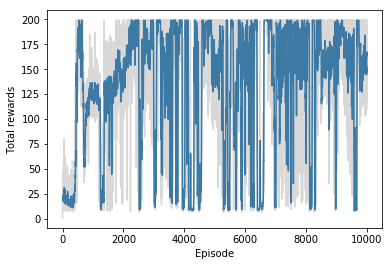

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

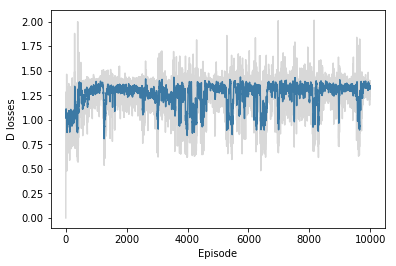

In [21]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

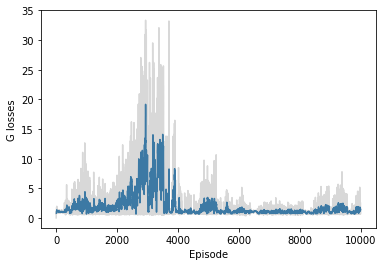

In [22]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

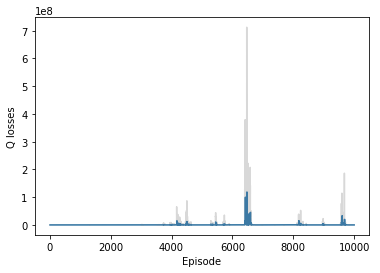

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [ ]:
test_episodes = 10
test_max_steps = 1000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


In [26]:
env.close()

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.